# RNN & LSTM

## import the data

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import pandas as pd
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
# from evaluation import smape
from sklearn.metrics import mean_squared_error
import ipdb

%matplotlib inline


Using TensorFlow backend.
/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/lightgbm/__init__.py:45: FutureWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS will be built by the Apple Clang compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you won't need to install the gcc compiler anymore.
Instead of that, you'll need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", FutureWarning)


In [2]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pyplot
from matplotlib.dates import DateFormatter
import os

# read files from directory
imputed_data_path = './imputed_data/'
aq_file_list = []
airQ_data_dict = {}

# read the file names into list
for aq_file in os.listdir(imputed_data_path):
    if '.csv' in aq_file:
        aq_file_list.append(aq_file)
        airQ_df = pd.read_csv(imputed_data_path+aq_file, header=0, index_col=0)
        airQ_df.time = airQ_df.time.apply(lambda x: pd.Timestamp(x))
        airQ_data_dict[aq_file.replace("_imputed.csv", '')] = airQ_df
 

## Important functions

In [3]:
# convert series to supervised learning
def series_to_supervised(data_df, n_in=1, dropnan=True):
	data = data_df.values
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, 1):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	agg.index = data_df.index
    
	# drop rows with NaN values
	if dropnan:
		agg.dropna()
        
	return agg
 


In [4]:
# return the dictionary dataframes according to the air quality type for further training & testing
# drop the NaN in the separated air types table
import ipdb

def airQualTypesDataDict(data_df):
    # dictionary for storing dataframes
    data_dict = {}
    
    # air quality types list
    air_types = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
    
    # features columns containing 'time' label
    feature_cols = list(set(data_df.columns) - set(air_types))
    
    for air in air_types:
        # get all the columns
        data_cols = feature_cols.copy()
        data_cols.append(air)
        
        # get the dataframe with the specific air type
        air_data_df = data_df[data_cols]
        
        # choose the 'time' as the index
        air_data_df.time = air_data_df.time.apply(lambda x: pd.Timestamp(x))
        air_data_df = air_data_df.set_index('time')
        data_dict[air] = air_data_df
        
    
    return data_dict
    
    
# drop the NaN in the concated air types table
def getTrainTestDataDropna(data_df):
    # dropna
    print ('Total rows before dropna: {}'.format(len(data_df)))
    data_df = data_df.dropna()
    data_df = data_df.set_index('time')
    print ('Total rows after dropna: {}'.format(len(data_df)))

    # labels columns
    label_cols = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3', 'SO2']
    feature_cols = list(set(data_df.columns) - set(label_cols))
    
    # validation set
    val_df = data_df[-48:]
    X_val = val_df[feature_cols]
    y_val = val_df[label_cols]

    # train set
    train_df = data_df[:-48]
    X_train = train_df[feature_cols]
    y_train = train_df[label_cols]
    
    return X_train, X_val, y_train, y_val


In [6]:
# return training & validation data
def splitTrainValData(data_df, label, n_in, is_predict):
    # pred_size
    pred_size = 48
    
    # reframed dataset
    data_df = data_df.astype(float)
    
    # extract the label column firstly
    features_df = data_df.drop(columns=[label])
    label_col = data_df[[label]]
    
    reframed = series_to_supervised(features_df, n_in)
    # concat the label column
    reframed = reframed.merge(label_col, on='time', how='left')
    
    # drop the NaN the last 48 hours before
    reframed_test = reframed[-pred_size:]
    reframed_train = reframed[:-pred_size]
    reframed_train = reframed_train.dropna()
    
    reframed_all = pd.DataFrame()
    if is_predict:
        # reframed data including the test set for final prediction
        reframed_all = pd.concat([reframed_train, reframed_test], ignore_index=False)
    else:
        # reframed data including the validation dataset
        reframed_all = reframed_train
    
    # split into train and test sets
    # index
    train_index = reframed_all.index[:-pred_size]
    test_index = reframed_all.index[-pred_size:]
    
    values = reframed_all.values
    # scaled features
    features_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = features_scaler.fit_transform(values[:,:-1])
    
    # scaled labels
    labels_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_label = labels_scaler.fit_transform(values[:,-1].reshape(-1,1))
    values = np.column_stack((scaled_features, scaled_label))

    # split the train & test
    train = values[:-pred_size, :]
    test = values[-pred_size:, :]
    
    # split into input and outputs
    # features take all values except the var1
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    
    return train_X, test_X, train_y, test_y, train_index, test_index, labels_scaler

## Evaluation

In [9]:
import numpy as np
import math
from evaluation import smape
from sklearn.metrics import r2_score

def evaluation(real, pred):
    mse_score = mean_squared_error(real, pred)
    rmse_score = math.sqrt(mse_score)
    smape_score = smape(real, pred)
    
    print ("MSE: {}".format(mse_score))
    print ("RMSE: {}".format(rmse_score))
    print ("SMAPE: {}".format(smape_score))
    print('R^2 score: {:2f}'.format(r2_score(real, pred)))
    return rmse_score, smape_score
    
A = np.array([2,3,4,5,6,7,8,9])
F = np.array([1,3,5,4,6,7,10,7])
print(smape(A, F))

0.0


## XGBoost

In [78]:
import ipdb
from xgboost import XGBRegressor

airQ_types = ['PM2.5', 'PM10', 'O3', 'CO', 'SO2', 'NO2']

def xgb(airQ_df, n_estimators, n_in, is_predict):
    rmse_dict = {}
    smape_dict = {}
    for air_type in airQ_types[:3]:
        # final optimal parameters
        n_in = 1
        n_est = 100
        
        if air_type == 'PM2.5':
            n_in = 12
            n_est = 1000
        elif air_type == 'PM10':
            n_in = 1
            n_est = 200
        elif air_type == 'O3':
            n_in = 15
            n_est = 100
            
#         n_estimators = n_est
            
            
        air_type_dict = airQualTypesDataDict(airQ_df)
        X_train, X_val, y_train, y_val, train_index, val_index, scaler = \
            splitTrainValData(air_type_dict[air_type], air_type, n_in, is_predict)
        
        # Model
        model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                 learning_rate=0.05, max_depth=3, 
                                 min_child_weight=1.7817, n_estimators=n_estimators,
                                 reg_alpha=0.4640, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state =7, nthread = -1)

        # time count
        start = time.time()

        # make a prediction
        model_xgb.fit(X_train, y_train)
        yhat = model_xgb.predict(X_val)

        # invert scaling for forecast
#         inv_yhat = concatenate((yhat, X_val[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(yhat.reshape(-1, 1))
        inv_yhat = inv_yhat[:,0]

        # invert scaling for actual
#         y_val = y_val.reshape((len(y_val), 1))
#         inv_y = concatenate((y_val, X_val[:, 1:]), axis=1)
        inv_y = scaler.inverse_transform(y_val.reshape(-1, 1))
        inv_y = inv_y[:,0]

        end = time.time()
        print('This took {} seconds.'.format(end - start))

        # inversed labels dataframe
        y_val_inversed = inv_y
        y_val_inversed_df = pd.DataFrame(y_val_inversed, index=val_index, columns=[air_type])

        pred_inversed = [x if x > 0 else 0 for x in inv_yhat]
        pred_inversed_df = pd.DataFrame(pred_inversed, index=val_index, columns=[air_type])

        # Evaluation result
        rmse_score, smape_score = evaluation(y_val_inversed, pred_inversed)
        rmse_dict[air_type] = rmse_score
        smape_dict[air_type] = smape_score

        # draw line chart
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(val_index, y_val_inversed_df[[air_type]], color='b', label='True')
        ax.plot(val_index, pred_inversed_df[[air_type]], color='orange', label='Prediction')

        ax.set_title(air_type, fontweight="bold", size=16)
        ax.legend(loc="upper right")
        myFmt = DateFormatter("%m %d %H")
        ax.xaxis.set_major_formatter(myFmt)

        ## Rotate date labels automatically
        fig.autofmt_xdate()
        plt.show()
        
    return rmse_dict, smape_dict


### Analysis

#### Suitable sequence hours for prediction

====================== 1 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 10.035153150558472 seconds.
MSE: 1693.0873789874356
RMSE: 41.1471430233915
SMAPE: 0.5523067254514681
R^2 score: 0.690203


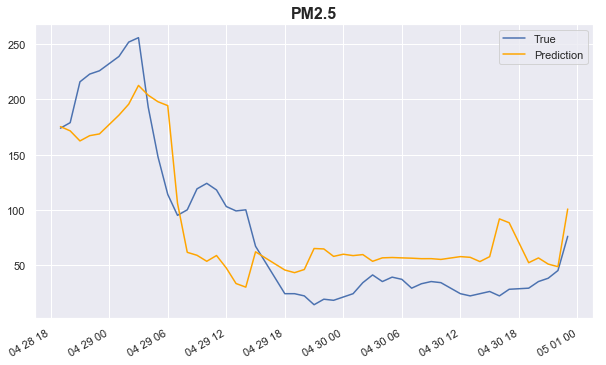

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 8.009604930877686 seconds.
MSE: 2944.78712351562
RMSE: 54.26589281966731
SMAPE: 0.4795680402585687
R^2 score: 0.325679


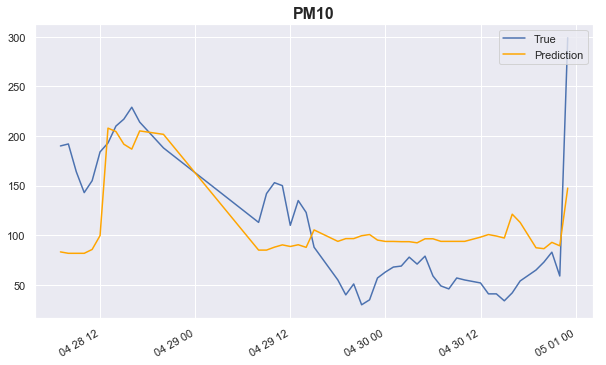

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 9.760246992111206 seconds.
MSE: 1087.2390204116098
RMSE: 32.973307695947184
SMAPE: 0.5463376435899583
R^2 score: 0.663371


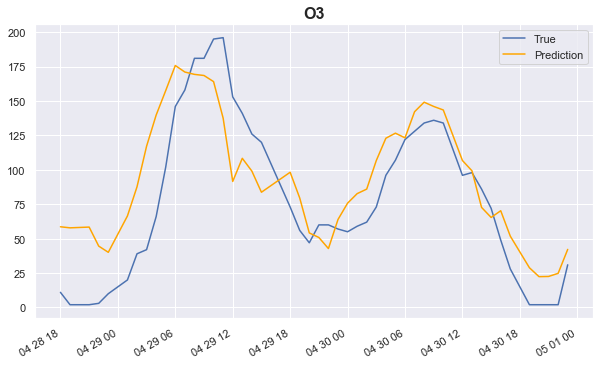

====================== 3 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 19.179062843322754 seconds.
MSE: 1579.1322749584142
RMSE: 39.738297333408916
SMAPE: 0.513248513275069
R^2 score: 0.711054


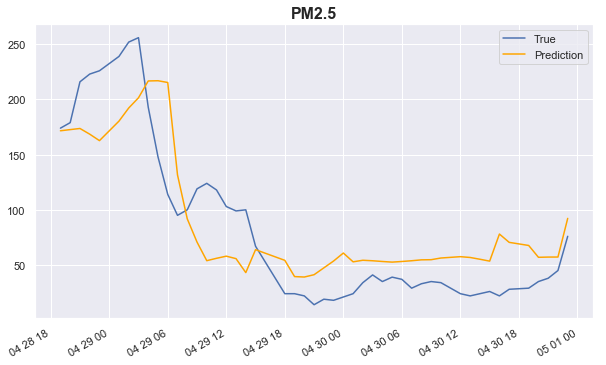

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 15.610528945922852 seconds.
MSE: 3878.997577605159
RMSE: 62.281599028968095
SMAPE: 0.4990100666336179
R^2 score: 0.111756


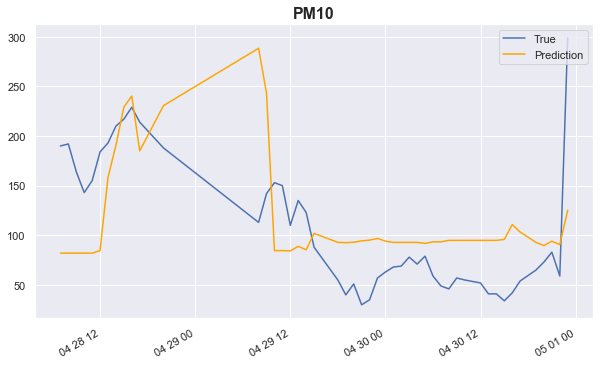

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 19.007256031036377 seconds.
MSE: 767.1659130949042
RMSE: 27.6977600736035
SMAPE: 0.5176529531143798
R^2 score: 0.762471


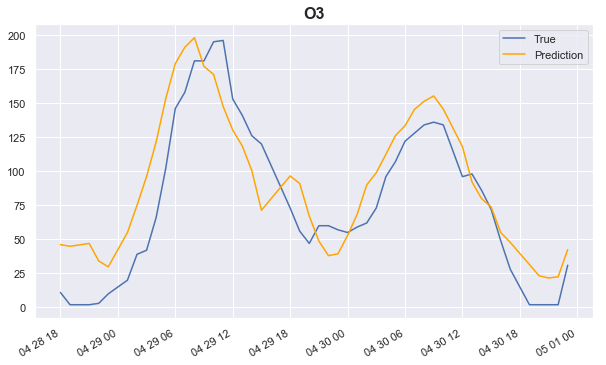

====================== 6 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 35.32155895233154 seconds.
MSE: 1307.8834684334327
RMSE: 36.16467155157686
SMAPE: 0.4419176827813822
R^2 score: 0.760687


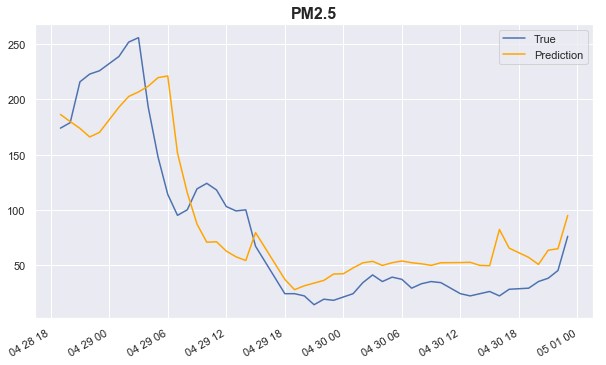

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 28.634167909622192 seconds.
MSE: 3260.491169669565
RMSE: 57.10071076326077
SMAPE: 0.48161922026423215
R^2 score: 0.253386


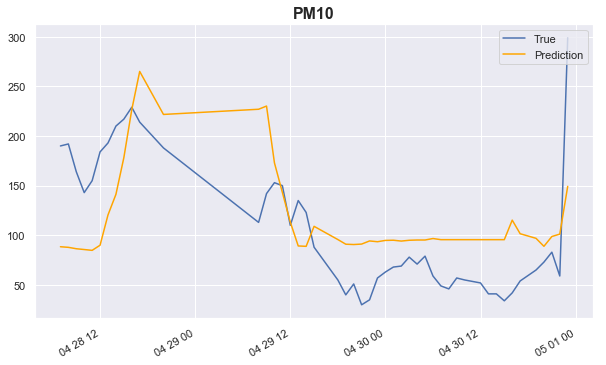

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 34.48283505439758 seconds.
MSE: 563.4126620182773
RMSE: 23.736315257812812
SMAPE: 0.4628966566802201
R^2 score: 0.825557


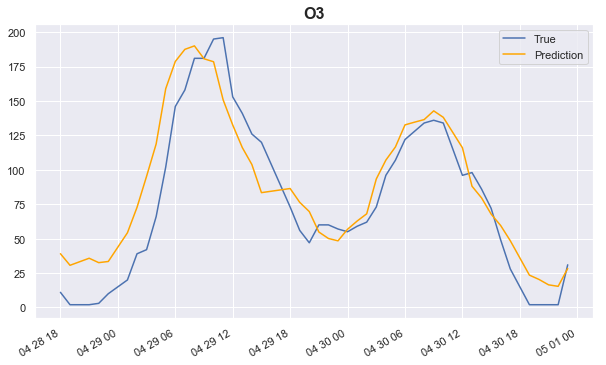

====================== 9 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 50.29667091369629 seconds.
MSE: 1173.3255848031351
RMSE: 34.25384043874694
SMAPE: 0.39419772888993004
R^2 score: 0.785308


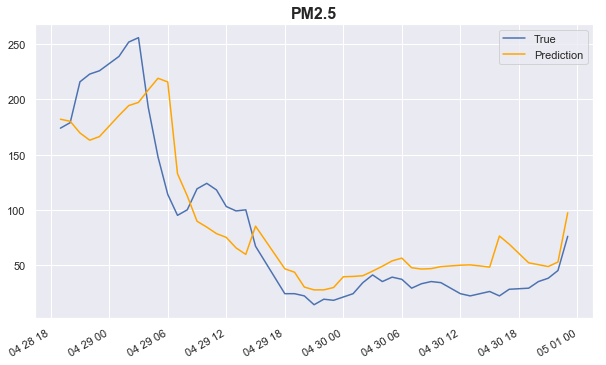

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 41.021095991134644 seconds.
MSE: 3595.1465432302284
RMSE: 59.959540885752524
SMAPE: 0.48260175325978044
R^2 score: 0.176754


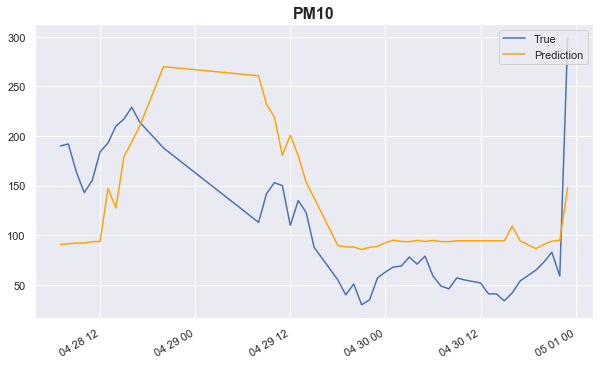

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 49.76694703102112 seconds.
MSE: 549.7300024584121
RMSE: 23.446321725558832
SMAPE: 0.4654432933326446
R^2 score: 0.829793


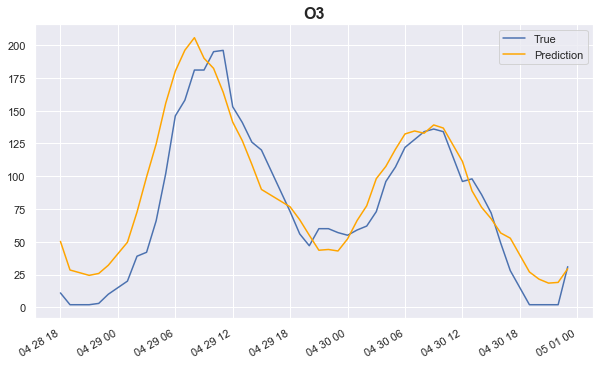

====================== 12 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 65.4103741645813 seconds.
MSE: 1275.712363093039
RMSE: 35.71711582831177
SMAPE: 0.3774762397648348
R^2 score: 0.766573


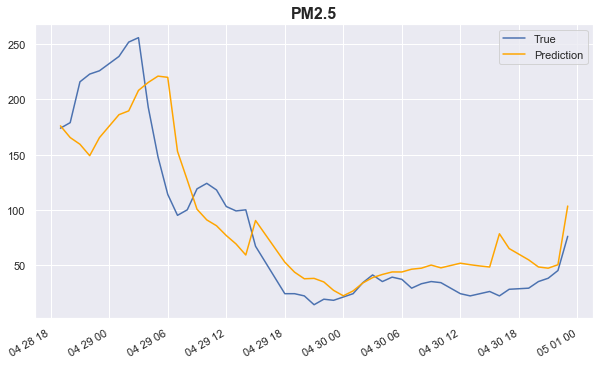

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 53.709288120269775 seconds.
MSE: 5256.949107630492
RMSE: 72.50482127162643
SMAPE: 0.5370771439795754
R^2 score: -0.203779


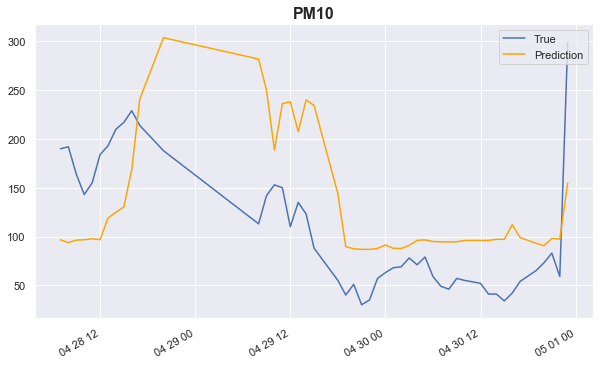

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 64.41680908203125 seconds.
MSE: 681.7963795339418
RMSE: 26.111230908058353
SMAPE: 0.4782246686206841
R^2 score: 0.788903


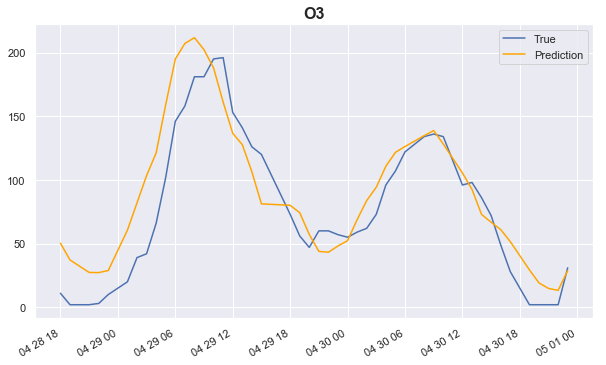

====================== 15 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 79.37806105613708 seconds.
MSE: 1502.9509034272708
RMSE: 38.76791074364559
SMAPE: 0.4018430321724067
R^2 score: 0.724994


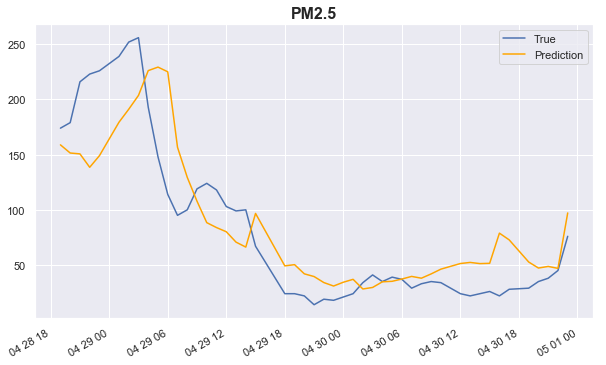

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 65.52657198905945 seconds.
MSE: 5170.865302425779
RMSE: 71.90872897239791
SMAPE: 0.546283167387164
R^2 score: -0.184066


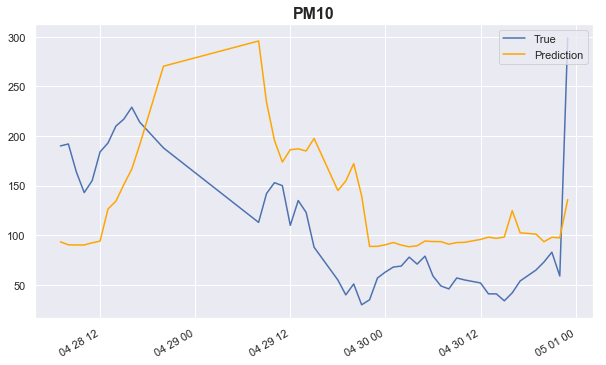

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 79.13270401954651 seconds.
MSE: 507.16919462259665
RMSE: 22.52041728349181
SMAPE: 0.45541624967080185
R^2 score: 0.842971


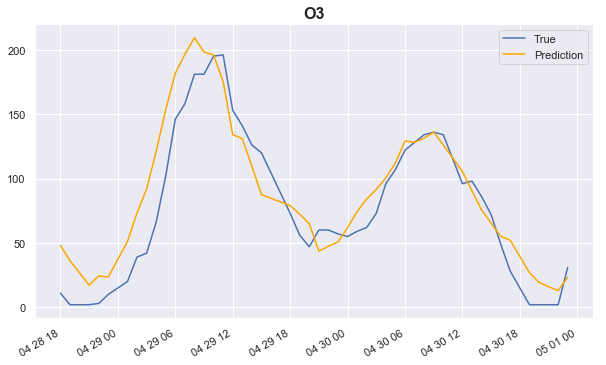

====================== 18 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 95.45220589637756 seconds.
MSE: 1589.7552586795412
RMSE: 39.871735084888655
SMAPE: 0.40986373542762383
R^2 score: 0.709111


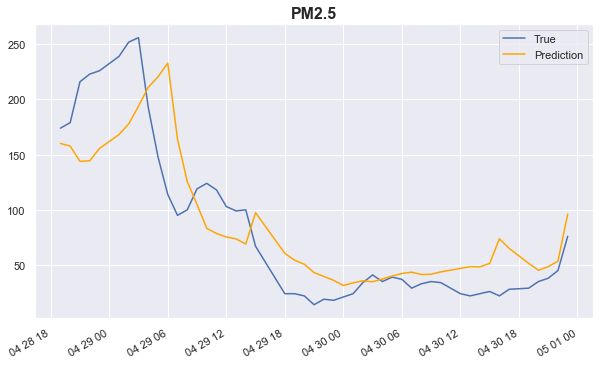

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 79.67537999153137 seconds.
MSE: 6916.804350317268
RMSE: 83.16732742079228
SMAPE: 0.5870562235461664
R^2 score: -0.583866


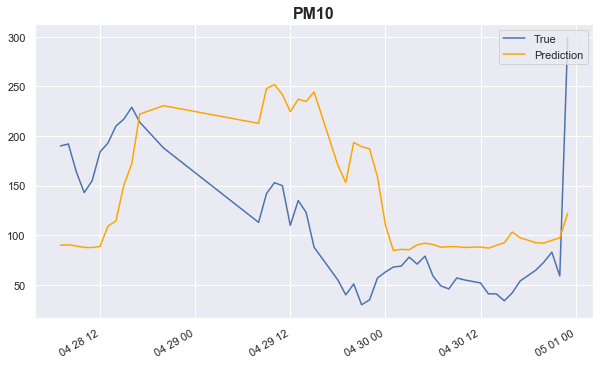

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 94.43432402610779 seconds.
MSE: 513.0498611299685
RMSE: 22.650603990400974
SMAPE: 0.4566223557168228
R^2 score: 0.841150


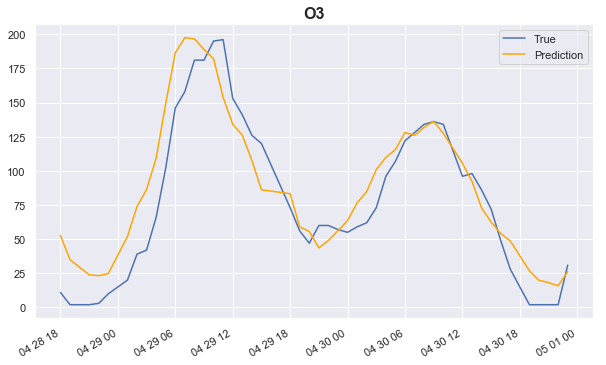

====================== 21 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 113.20994591712952 seconds.
MSE: 1456.3959697493858
RMSE: 38.16275631750655
SMAPE: 0.38541883939557814
R^2 score: 0.733512


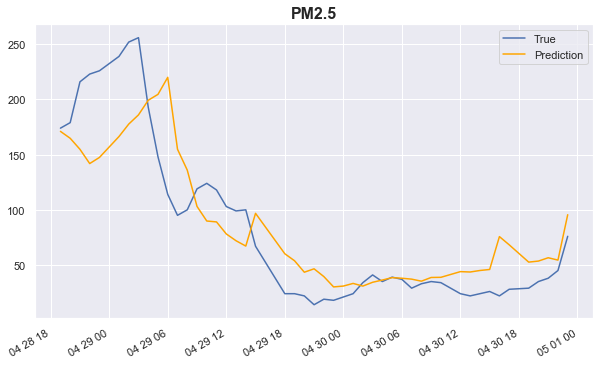

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 92.98729109764099 seconds.
MSE: 9195.669506951646
RMSE: 95.89405355365705
SMAPE: 0.6205425673890739
R^2 score: -1.105699


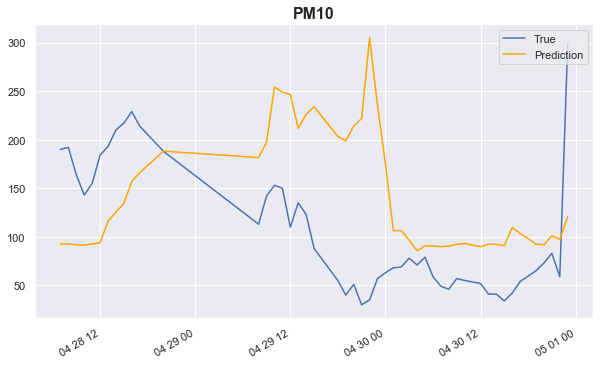

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 111.92143106460571 seconds.
MSE: 696.2872668923288
RMSE: 26.387255766606895
SMAPE: 0.48039914436118786
R^2 score: 0.784417


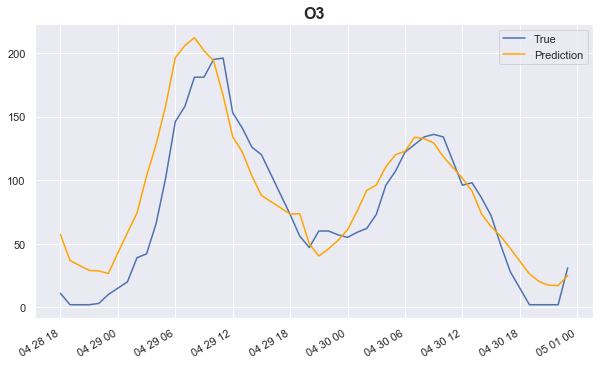

====================== 24 ===========================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 124.32814002037048 seconds.
MSE: 1290.5303162272673
RMSE: 35.923951845910096
SMAPE: 0.38356972351372826
R^2 score: 0.763862


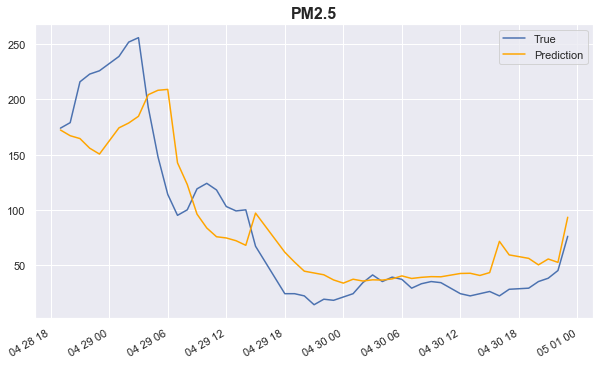

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 101.45915699005127 seconds.
MSE: 10373.618956540524
RMSE: 101.85096443598619
SMAPE: 0.6734591939724281
R^2 score: -1.375435


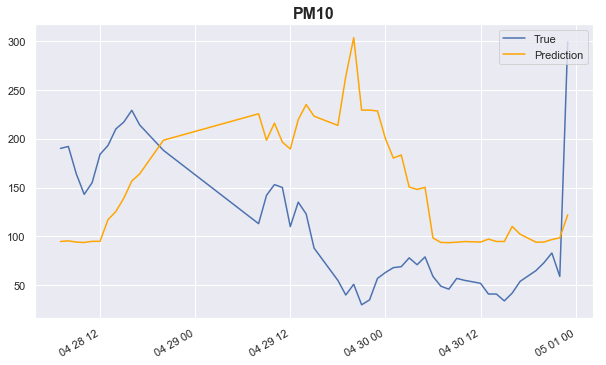

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 124.81582283973694 seconds.
MSE: 723.6781703095603
RMSE: 26.90126707628398
SMAPE: 0.48656651569460135
R^2 score: 0.775936


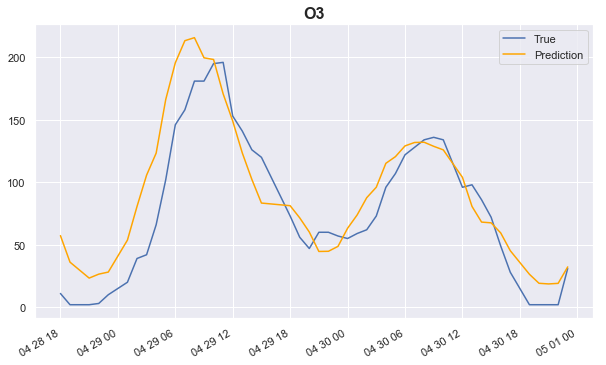

In [34]:
# make a comparison of the different sequence hours for prediction
o_3 = {'rmse': [], 'smape': []}
pm25 = {'rmse': [], 'smape': []}
pm10 = {'rmse': [], 'smape': []}
seq_hours = [1, 3, 6, 9, 12, 15, 18, 21, 24]

for i in seq_hours:
    print ("====================== {} ===========================".format(i))
    rmse_dict, smape_dict = xgb(airQ_data_dict['aotizhongxin_aq'], 1000, i, False)
    
    # O3
    o_3['rmse'].append(rmse_dict['O3'])
    o_3['smape'].append(smape_dict['O3'])
    
    # PM2.5
    pm25['rmse'].append(rmse_dict['PM2.5'])
    pm25['smape'].append(smape_dict['PM2.5'])
    
    # PM10
    pm10['rmse'].append(rmse_dict['PM10'])
    pm10['smape'].append(smape_dict['PM10'])
    

In [35]:
# Plot the result according to the metric
def plotResult(metric):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(seq_hours, pm25[metric], color='b', label='PM2.5')
    ax.plot(seq_hours, pm10[metric], color='orange', label='PM10')
    ax.plot(seq_hours, o_3[metric], color='g', label='O3')

    ax.set_title('{} of Different Sequence Hours'.format(metric), fontweight="bold", size=16)
    ax.legend(loc="upper right")

    plt.xlabel('Sequence Hours')
    plt.ylabel(metric)
    plt.show()

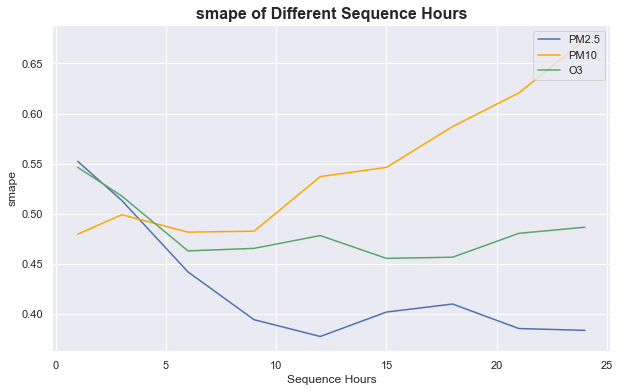

In [36]:
plotResult('smape')

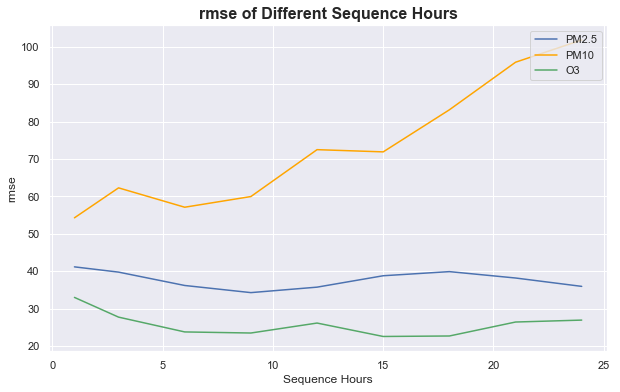

In [37]:
plotResult('rmse')

#### Suitable n_estimators

In [79]:
# Plot the result according to the metric
def plot_n_estimators_result(metric):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(n_estimators_list, pm25[metric], color='b', label='PM2.5')
    ax.plot(n_estimators_list, pm10[metric], color='orange', label='PM10')
    ax.plot(n_estimators_list, o_3[metric], color='g', label='O3')

    ax.set_title('{} of Different n_estimators'.format(metric), fontweight="bold", size=16)
    ax.legend(loc="upper right")

    plt.xlabel('n_estimators')
    plt.ylabel(metric)
    plt.show()

============== n_estimators: 10 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 0.9422690868377686 seconds.
MSE: 18520.562899805784
RMSE: 136.090274817144
SMAPE: 1.0274845230582716
R^2 score: -2.388844


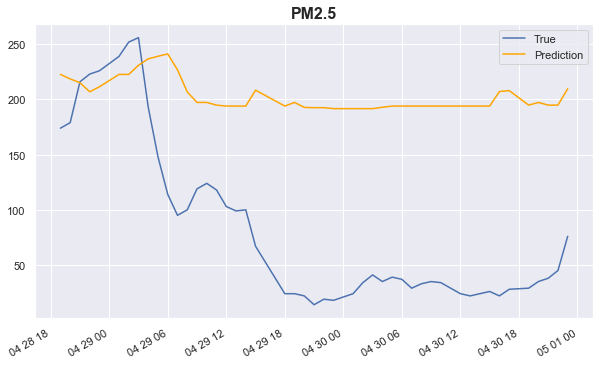

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 0.11487698554992676 seconds.
MSE: 342840.81712773925
RMSE: 585.5261028577114
SMAPE: 1.4891365882263117
R^2 score: -77.506453


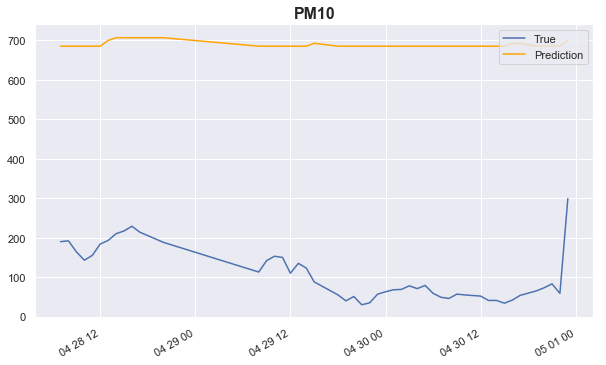

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 1.107841968536377 seconds.
MSE: 5115.361808300397
RMSE: 71.52175758676793
SMAPE: 0.7547737405426821
R^2 score: -0.583811


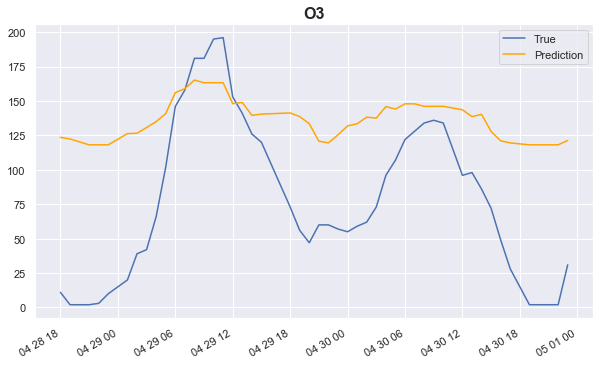

============== n_estimators: 20 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 1.542827844619751 seconds.
MSE: 7952.376838600477
RMSE: 89.1761001535752
SMAPE: 0.8780258768292916
R^2 score: -0.455105


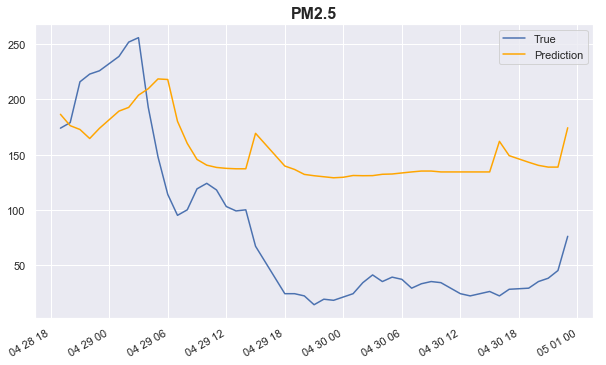

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 0.1928560733795166 seconds.
MSE: 120110.56346364885
RMSE: 346.56970938564274
SMAPE: 1.2797140807544813
R^2 score: -26.503885


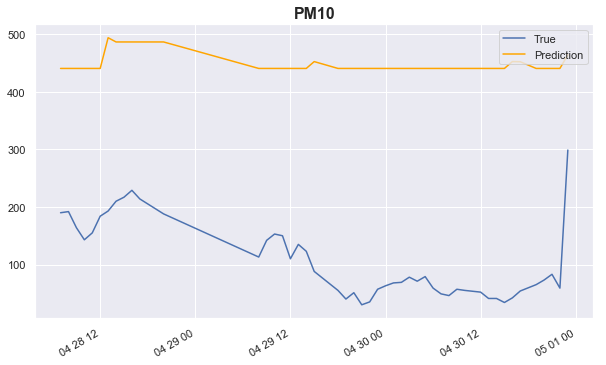

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 1.9773428440093994 seconds.
MSE: 2163.0387354185973
RMSE: 46.50848025273022
SMAPE: 0.6339914625276551
R^2 score: 0.330283


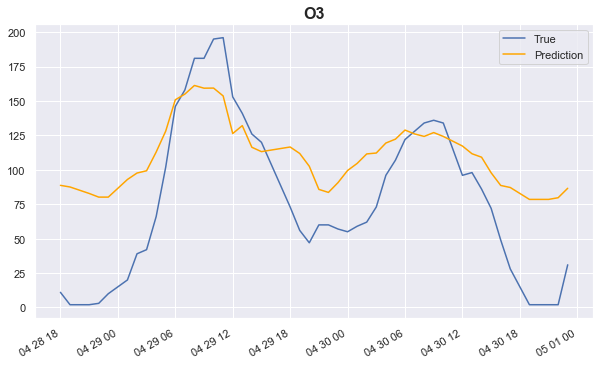

============== n_estimators: 30 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 2.13713002204895 seconds.
MSE: 4097.184872557002
RMSE: 64.00925614750574
SMAPE: 0.7434932179110726
R^2 score: 0.250308


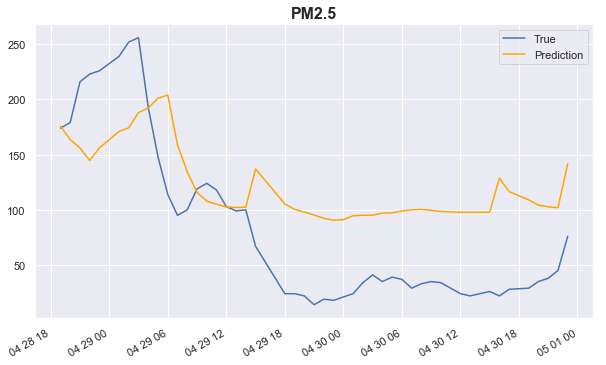

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 0.2397630214691162 seconds.
MSE: 43316.2977402434
RMSE: 208.12567775323495
SMAPE: 1.0460518729877413
R^2 score: -8.918915


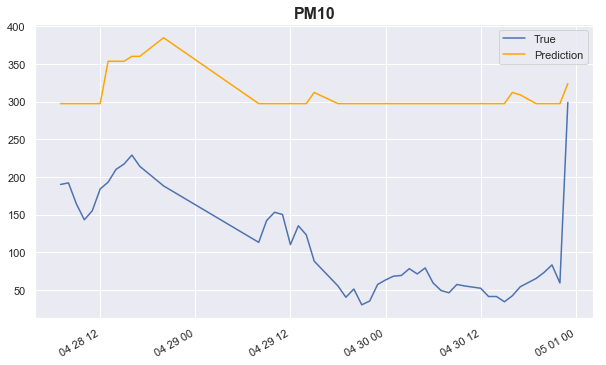

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 2.4088690280914307 seconds.
MSE: 1073.9051130866367
RMSE: 32.77049149900924
SMAPE: 0.5487400594097139
R^2 score: 0.667499


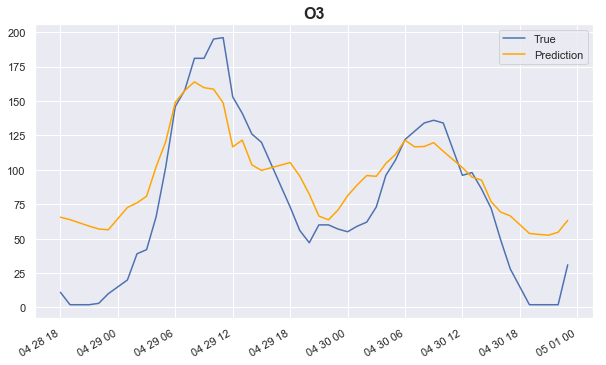

============== n_estimators: 50 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 3.20255708694458 seconds.
MSE: 1910.1609951646658
RMSE: 43.705388628459374
SMAPE: 0.5757565918079232
R^2 score: 0.650484


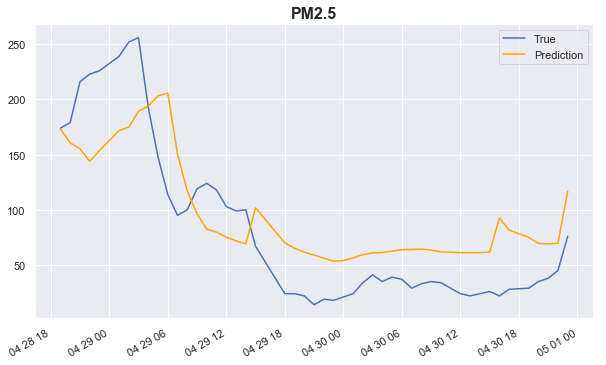

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 0.3879549503326416 seconds.
MSE: 7305.083491408285
RMSE: 85.46978115923946
SMAPE: 0.6408229696815914
R^2 score: -0.672777


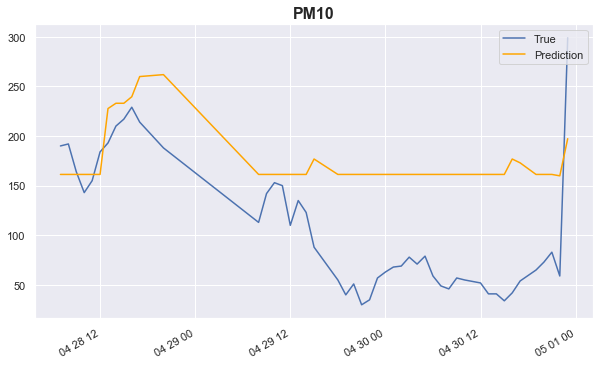

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 4.046527862548828 seconds.
MSE: 513.806093259514
RMSE: 22.6672912642758
SMAPE: 0.4770459918075338
R^2 score: 0.840916


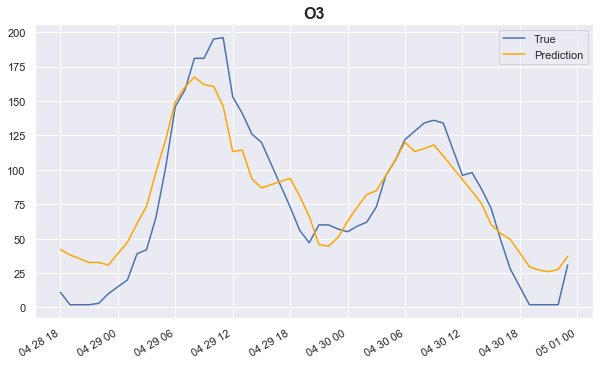

============== n_estimators: 80 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 4.991761207580566 seconds.
MSE: 1557.793388626859
RMSE: 39.46889140357072
SMAPE: 0.45827970562544795
R^2 score: 0.714959


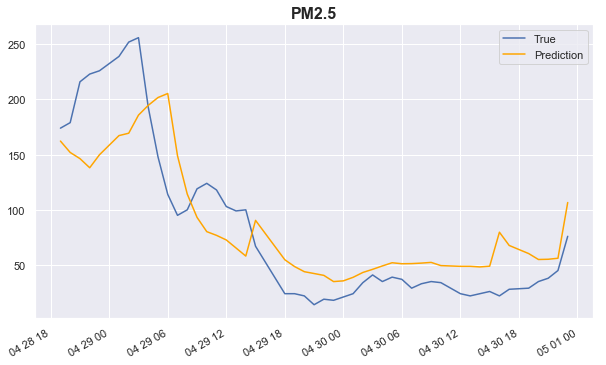

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 0.6177558898925781 seconds.
MSE: 2959.282863121464
RMSE: 54.39929101671697
SMAPE: 0.4930817841744386
R^2 score: 0.322360


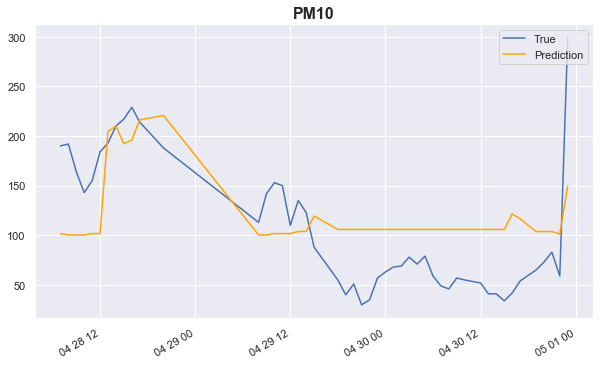

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 6.014087915420532 seconds.
MSE: 428.762541045055
RMSE: 20.70658207056527
SMAPE: 0.45396876544965375
R^2 score: 0.867247


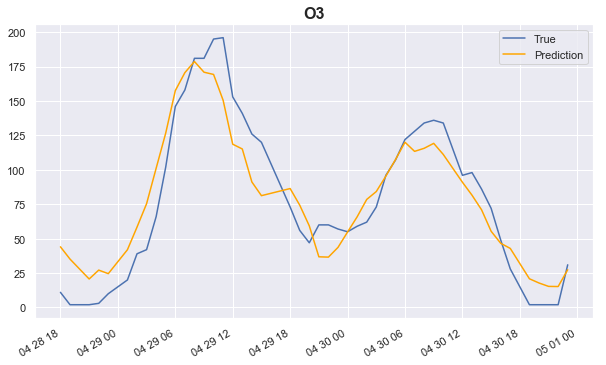

============== n_estimators: 100 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 6.132222890853882 seconds.
MSE: 1451.3387598817055
RMSE: 38.09644025209843
SMAPE: 0.42938616030251553
R^2 score: 0.734438


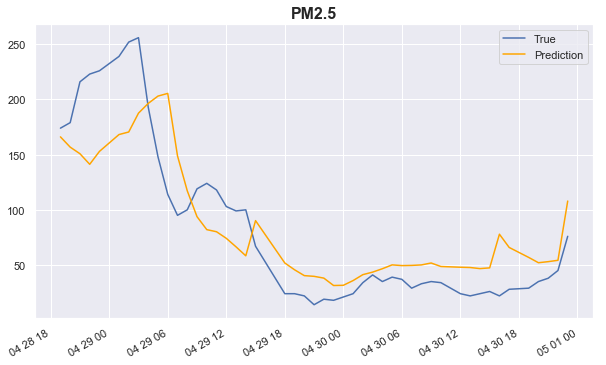

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 0.7720918655395508 seconds.
MSE: 2926.8796863926714
RMSE: 54.10064404785466
SMAPE: 0.4861136444560761
R^2 score: 0.329779


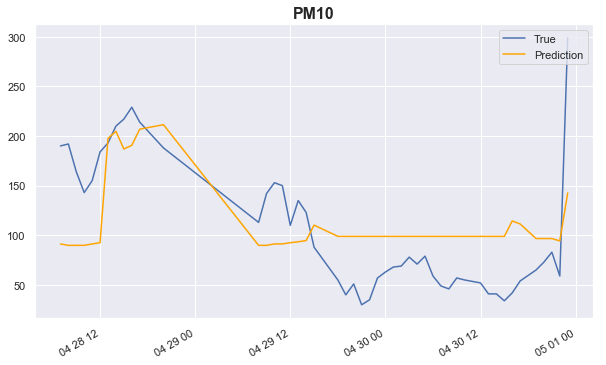

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 8.119842052459717 seconds.
MSE: 394.6390065084467
RMSE: 19.865523061536706
SMAPE: 0.4455550562993526
R^2 score: 0.877812


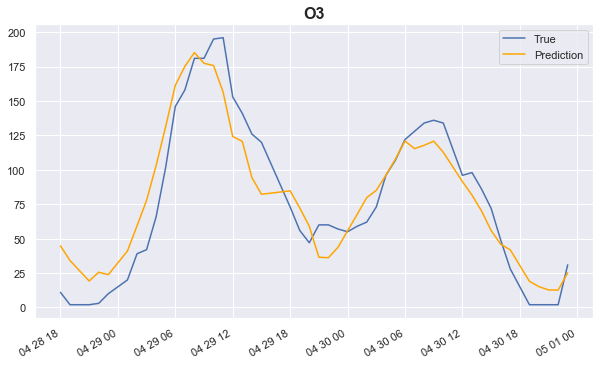

In [80]:
# make a comparison of the different sequence hours for prediction
o_3 = {'rmse': [], 'smape': []}
pm25 = {'rmse': [], 'smape': []}
pm10 = {'rmse': [], 'smape': []}
n_estimators_list = [10, 20, 30, 50, 80, 100]

for i in n_estimators_list:
    print ("============== n_estimators: {} ================".format(i))
    rmse_dict, smape_dict = xgb(airQ_data_dict['aotizhongxin_aq'], i, 1, False)
    
    # O3
    o_3['rmse'].append(rmse_dict['O3'])
    o_3['smape'].append(smape_dict['O3'])
    
    # PM2.5
    pm25['rmse'].append(rmse_dict['PM2.5'])
    pm25['smape'].append(smape_dict['PM2.5'])
    
    # PM10
    pm10['rmse'].append(rmse_dict['PM10'])
    pm10['smape'].append(smape_dict['PM10'])

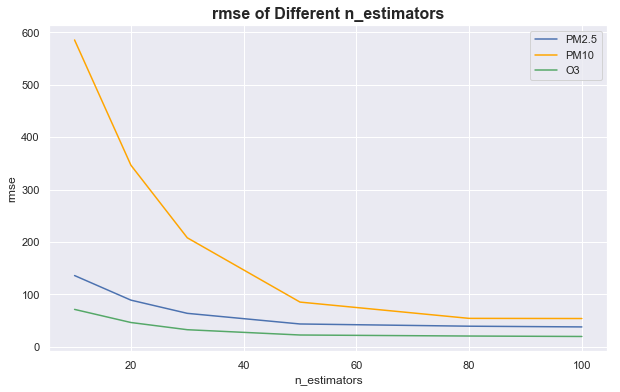

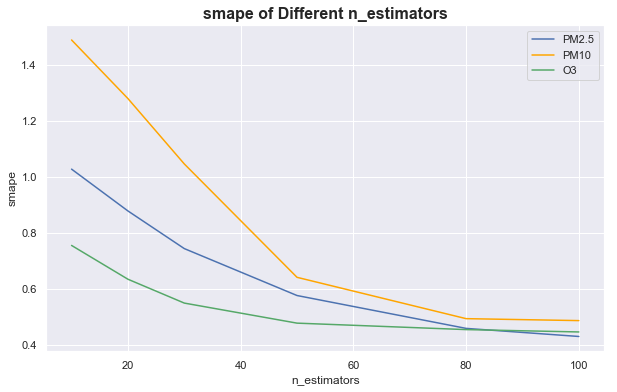

In [81]:
plot_n_estimators_result('rmse')
plot_n_estimators_result('smape')

============== n_estimators: 100 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 6.8277528285980225 seconds.
MSE: 1451.3387598817055
RMSE: 38.09644025209843
SMAPE: 0.42938616030251553
R^2 score: 0.734438


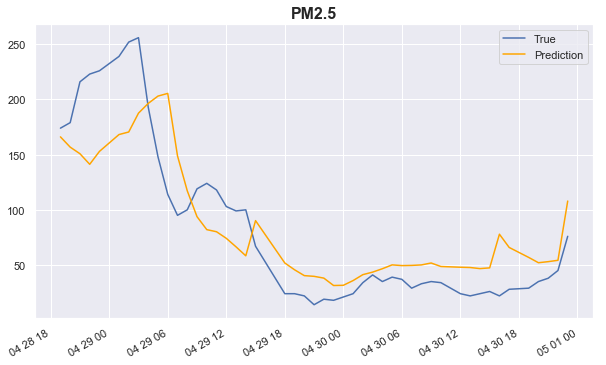

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 0.9072771072387695 seconds.
MSE: 2926.8796863926714
RMSE: 54.10064404785466
SMAPE: 0.4861136444560761
R^2 score: 0.329779


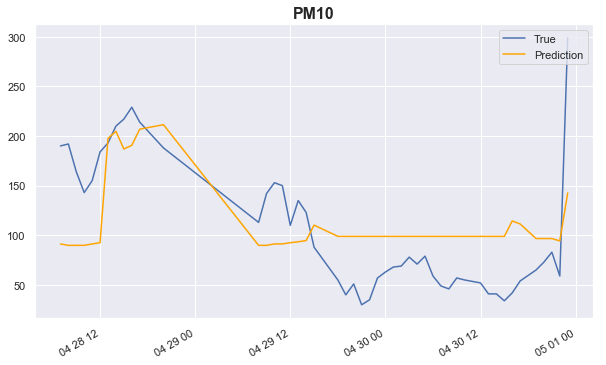

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 8.19440507888794 seconds.
MSE: 394.6390065084467
RMSE: 19.865523061536706
SMAPE: 0.4455550562993526
R^2 score: 0.877812


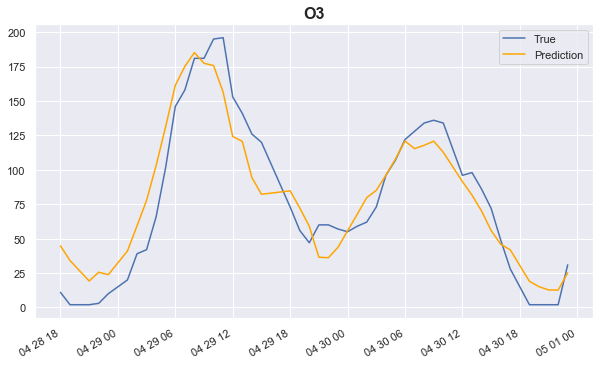

============== n_estimators: 200 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 13.388016939163208 seconds.
MSE: 1336.2581342461528
RMSE: 36.55486471382643
SMAPE: 0.401837471545128
R^2 score: 0.755495


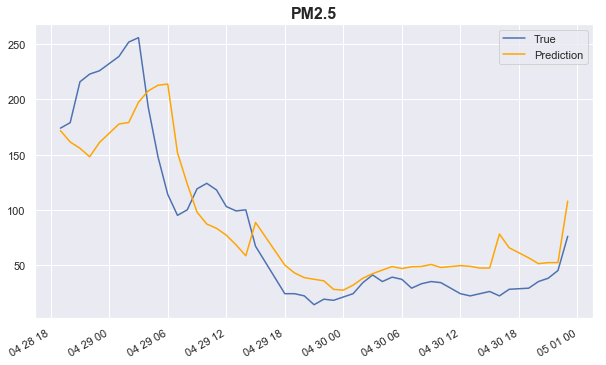

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 1.6379430294036865 seconds.
MSE: 2914.831589138897
RMSE: 53.98918029697151
SMAPE: 0.4761605575637878
R^2 score: 0.332538


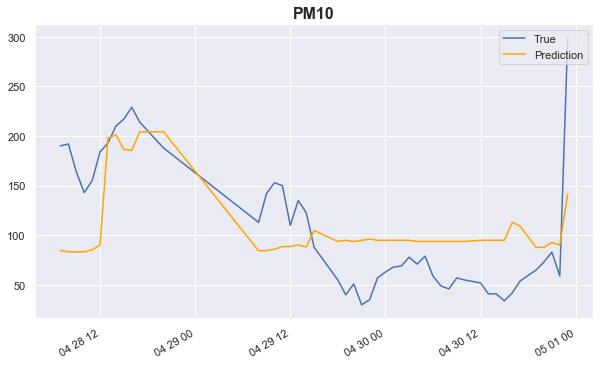

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 16.124428033828735 seconds.
MSE: 510.0192842742229
RMSE: 22.583606538244126
SMAPE: 0.46326585706126444
R^2 score: 0.842089


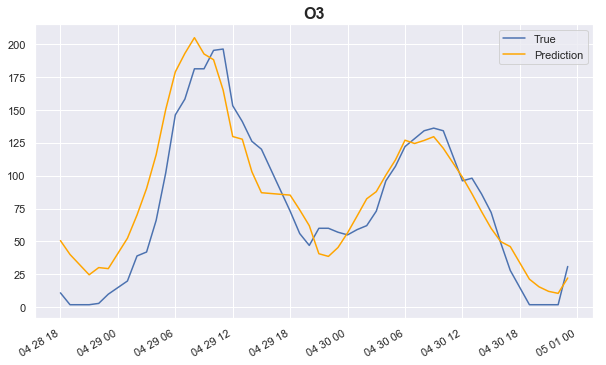

============== n_estimators: 300 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 19.79266905784607 seconds.
MSE: 1299.385076660329
RMSE: 36.046984293562325
SMAPE: 0.38948968013860913
R^2 score: 0.762242


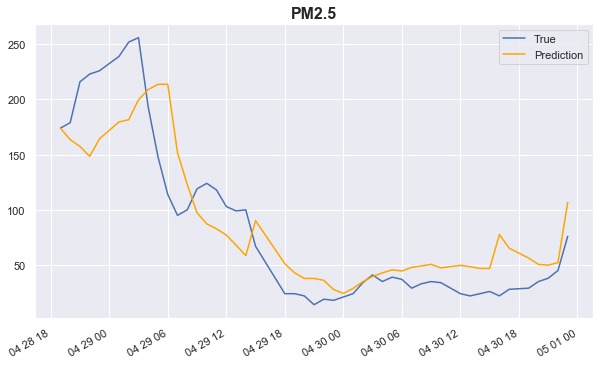

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 2.4487409591674805 seconds.
MSE: 2927.0235295119624
RMSE: 54.101973434542685
SMAPE: 0.47882079503466785
R^2 score: 0.329747


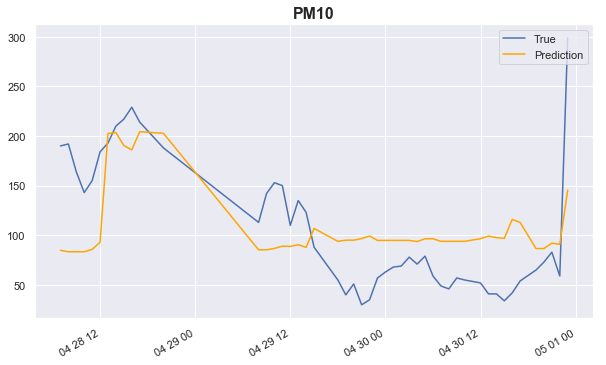

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 23.95224094390869 seconds.
MSE: 528.0654885593902
RMSE: 22.979675553832134
SMAPE: 0.46616291439742336
R^2 score: 0.836501


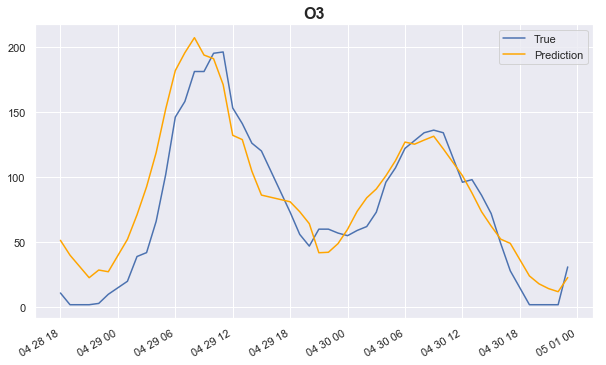

============== n_estimators: 500 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 34.49427580833435 seconds.
MSE: 1291.4693060971986
RMSE: 35.93701860334547
SMAPE: 0.3842297776698224
R^2 score: 0.763690


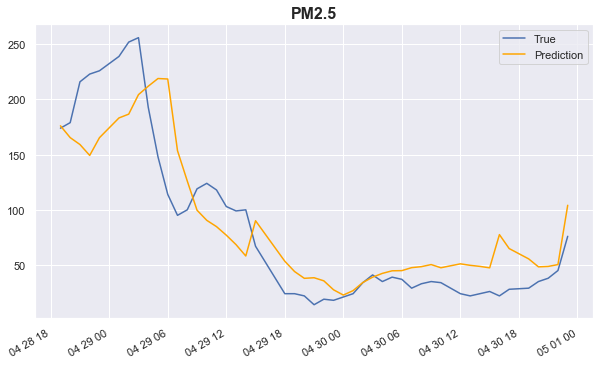

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 4.3166420459747314 seconds.
MSE: 2964.8511184554554
RMSE: 54.45044644863305
SMAPE: 0.4813866345531017
R^2 score: 0.321084


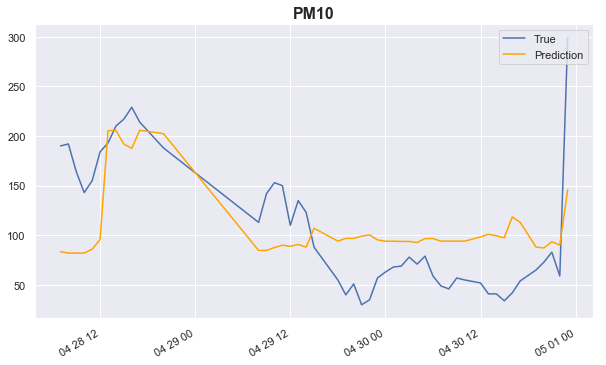

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 39.93581700325012 seconds.
MSE: 541.6911321883754
RMSE: 23.274259004066604
SMAPE: 0.4635971603827058
R^2 score: 0.832282


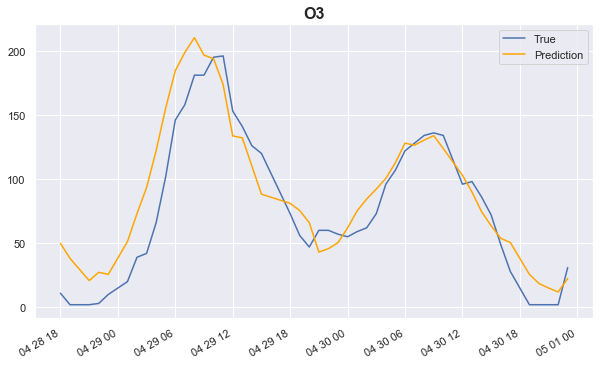

============== n_estimators: 800 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 54.33765697479248 seconds.
MSE: 1277.7352653435773
RMSE: 35.74542299852636
SMAPE: 0.37958486672083563
R^2 score: 0.766203


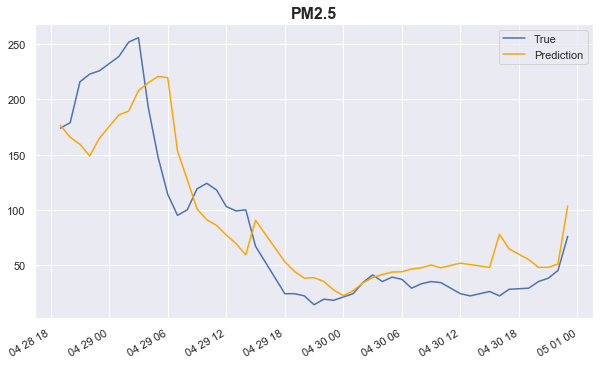

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 7.420527935028076 seconds.
MSE: 2942.0993423767563
RMSE: 54.24112224481308
SMAPE: 0.4797726333216097
R^2 score: 0.326294


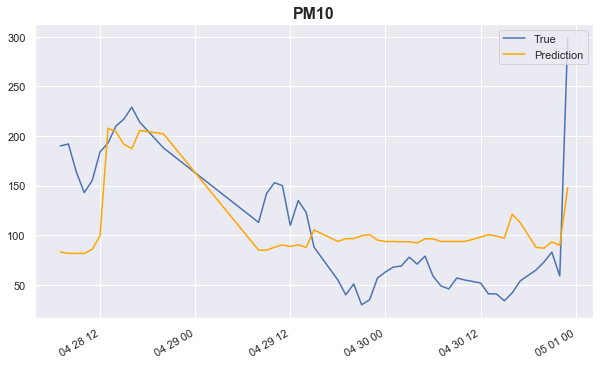

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 65.3468689918518 seconds.
MSE: 519.0776872587735
RMSE: 22.78327648207723
SMAPE: 0.45927406619348704
R^2 score: 0.839284


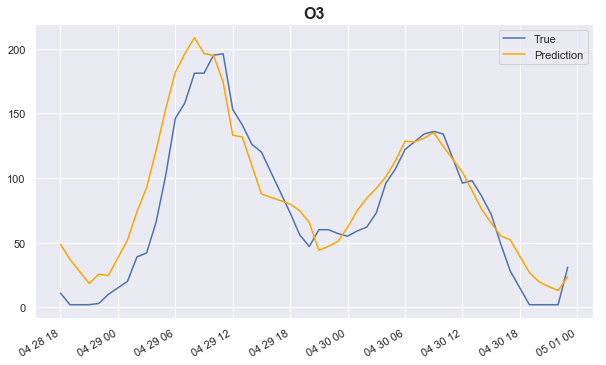

============== n_estimators: 1000 ================


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 67.40208292007446 seconds.
MSE: 1275.712363093039
RMSE: 35.71711582831177
SMAPE: 0.3774762397648348
R^2 score: 0.766573


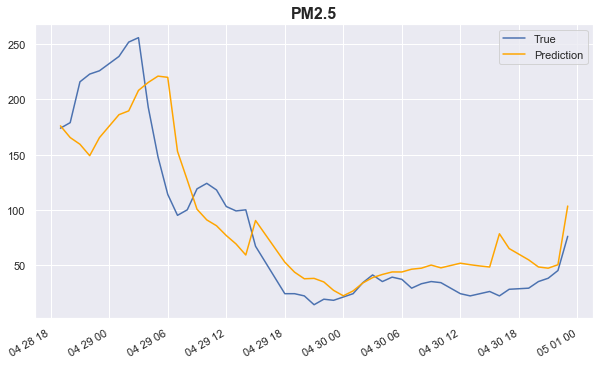

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 8.825856924057007 seconds.
MSE: 2944.78712351562
RMSE: 54.26589281966731
SMAPE: 0.4795680402585687
R^2 score: 0.325679


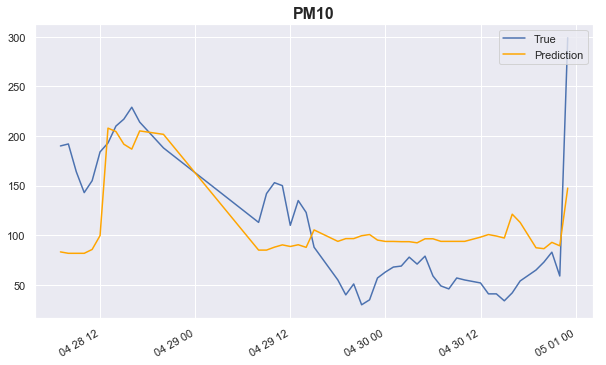

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 81.90356206893921 seconds.
MSE: 507.16919462259665
RMSE: 22.52041728349181
SMAPE: 0.45541624967080185
R^2 score: 0.842971


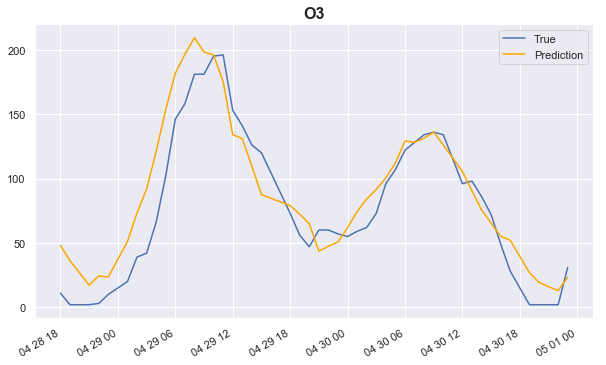

In [82]:
# make a comparison of the different sequence hours for prediction
o_3 = {'rmse': [], 'smape': []}
pm25 = {'rmse': [], 'smape': []}
pm10 = {'rmse': [], 'smape': []}
n_estimators_list = [100, 200, 300, 500, 800, 1000]

for i in n_estimators_list:
    print ("============== n_estimators: {} ================".format(i))
    rmse_dict, smape_dict = xgb(airQ_data_dict['aotizhongxin_aq'], i, 1, False)
    
    # O3
    o_3['rmse'].append(rmse_dict['O3'])
    o_3['smape'].append(smape_dict['O3'])
    
    # PM2.5
    pm25['rmse'].append(rmse_dict['PM2.5'])
    pm25['smape'].append(smape_dict['PM2.5'])
    
    # PM10
    pm10['rmse'].append(rmse_dict['PM10'])
    pm10['smape'].append(smape_dict['PM10'])

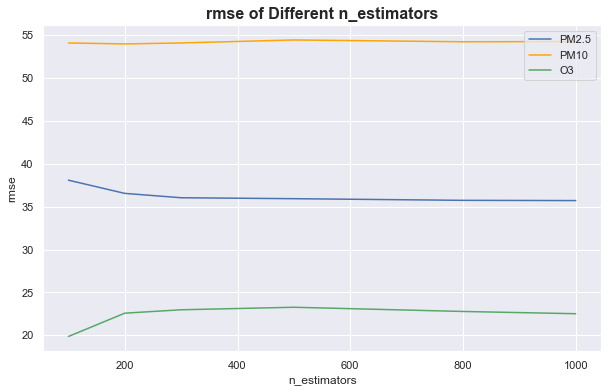

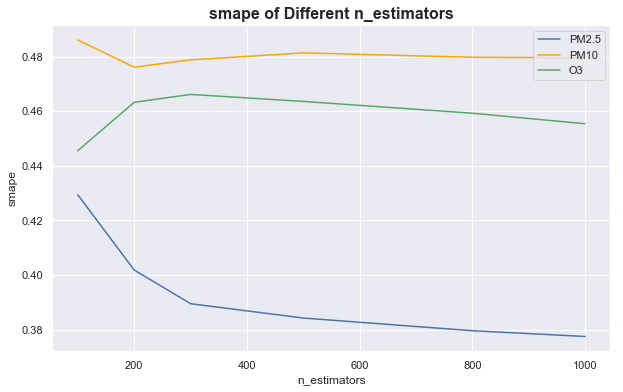

In [83]:
plot_n_estimators_result('rmse')
plot_n_estimators_result('smape')

#### Test on the data between 2018,04,29 00:00 and 2018,04,29 00:00 (48 hours)

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 62.64255499839783 seconds.
MSE: 1275.712363093039
RMSE: 35.71711582831177
SMAPE: 0.3774762397648348
R^2 score: 0.766573


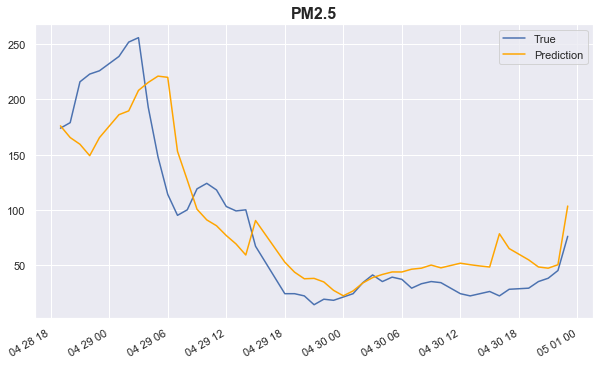

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 1.7225351333618164 seconds.
MSE: 2914.831589138897
RMSE: 53.98918029697151
SMAPE: 0.4761605575637878
R^2 score: 0.332538


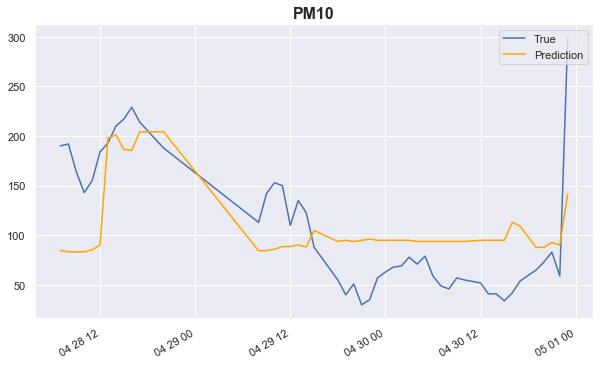

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 8.286745071411133 seconds.
MSE: 394.6390065084467
RMSE: 19.865523061536706
SMAPE: 0.4455550562993526
R^2 score: 0.877812


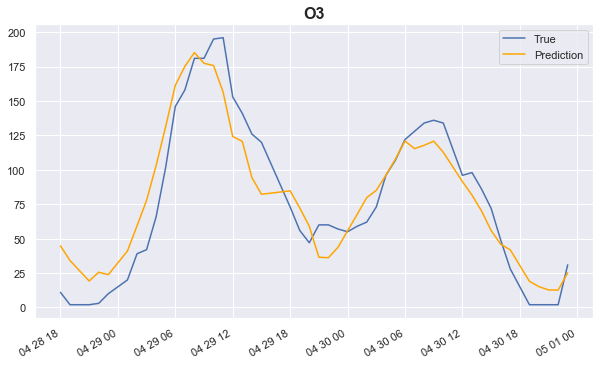

({'O3': 19.865523061536706,
  'PM10': 53.98918029697151,
  'PM2.5': 35.71711582831177},
 {'O3': 0.4455550562993526,
  'PM10': 0.4761605575637878,
  'PM2.5': 0.3774762397648348})

In [77]:
xgb(airQ_data_dict['aotizhongxin_aq'], i, 1, False)

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 52.04114103317261 seconds.
MSE: 1709.2142869371626
RMSE: 41.342644895279285
SMAPE: 0.4623457494904835
R^2 score: 0.669267


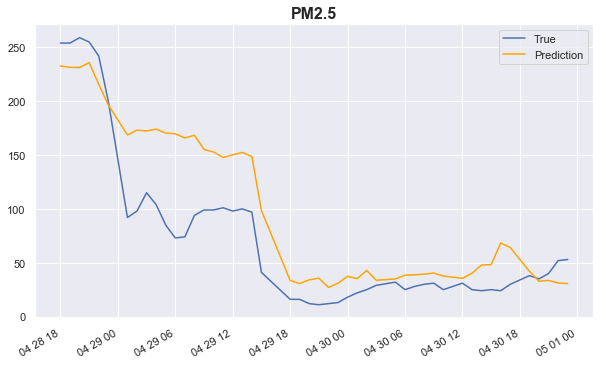

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 7.414983034133911 seconds.
MSE: 3226.6280357653545
RMSE: 56.803415705090785
SMAPE: 0.2974603086438717
R^2 score: 0.459478


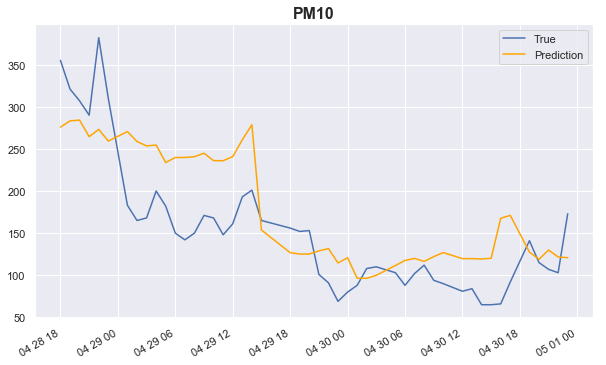

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 68.72479009628296 seconds.
MSE: 199.81172417423807
RMSE: 14.135477500751012
SMAPE: 0.4737038536992974
R^2 score: 0.921836


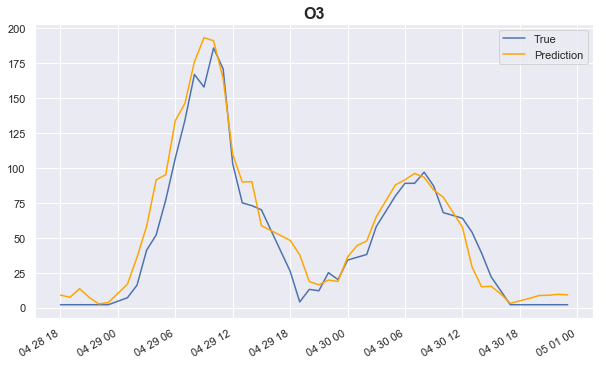

({'O3': 14.135477500751012,
  'PM10': 56.803415705090785,
  'PM2.5': 41.342644895279285},
 {'O3': 0.4737038536992974,
  'PM10': 0.2974603086438717,
  'PM2.5': 0.4623457494904835})

In [91]:
xgb(airQ_data_dict['dongsihuan_aq'], i, 1, False)

### Make Prediction on the 48 hours
Make prediction on the low missing rate air quality stations.

In [87]:
def submission(data_df, label):
    sub_df = pd.read_csv('submission.csv', header=0, index_col=0)
    for i in data_df.index:
        sub_df.at[i, 'PM2.5'] = data_df.at[i, 'PM2.5']
#         sub_df.at[i, 'PM10'] = data_df.at[i, 'PM10']
#         sub_df.at[i, 'O3'] = data_df.at[i, 'O3']
    display(sub_df[data_df.index[0]: data_df.index[-1]])
    sub_df.to_csv('submission.csv', index='test_id')
    

In [89]:
def xgb_final_prediction(airQ_df, airQ_station):
    # submission
    sub_index = []
    for i in range(48):
        sub_index.append('{}#{}'.format(airQ_station, i))
    series = pd.Series(sub_index)
    sub_df = pd.DataFrame(index=series)
    sub_df.index.name = 'test_id'
    
    for air_type in ['PM2.5']:
        n_in = 1
        n_est = 100
        
        if air_type == 'PM2.5':
            n_in = 12
            n_est = 1000
        elif air_type == 'PM10':
            n_in = 1
            n_est = 200
        elif air_type == 'O3':
            n_in = 15
            n_est = 100
        
        air_type_dict = airQualTypesDataDict(airQ_df)
        X_train, X_val, y_train, y_val, train_index, val_index, scaler = \
            splitTrainValData(air_type_dict[air_type], air_type, n_in, True)
        
        # Model
        model_xgb = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                                 learning_rate=0.05, max_depth=3, 
                                 min_child_weight=1.7817, n_estimators=n_est,
                                 reg_alpha=0.4640, reg_lambda=0.8571,
                                 subsample=0.5213, silent=1,
                                 random_state =7, nthread = -1)

        # time count
        start = time.time()

        # make a prediction
        model_xgb.fit(X_train, y_train)
        yhat = model_xgb.predict(X_val)

        # invert scaling for forecast
#         inv_yhat = concatenate((yhat, X_val[:, 1:]), axis=1)
        inv_yhat = scaler.inverse_transform(yhat.reshape(-1, 1))
        inv_yhat = inv_yhat[:,0]

        end = time.time()
        print('This took {} seconds.'.format(end - start))

        pred_inversed = [x if x > 0 else 0 for x in inv_yhat]
        pred_inversed_df = pd.DataFrame(pred_inversed, index=val_index, columns=[air_type])

        # draw line chart
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(val_index, pred_inversed_df[[air_type]], color='orange', label='Prediction')

        ax.set_title(air_type, fontweight="bold", size=16)
        ax.legend(loc="upper right")
        myFmt = DateFormatter("%m %d %H")
        ax.xaxis.set_major_formatter(myFmt)

        ## Rotate date labels automatically
        fig.autofmt_xdate()
        plt.show()
        
        ## store the result into submission
        sub_df[air_type] = pred_inversed
        
    return sub_df


/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 60.35976791381836 seconds.


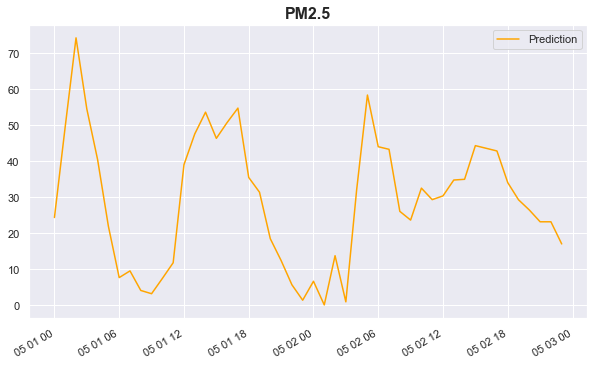

PM2.5        PM10          O3
test_id                                          
tongzhou_aq#0   24.308933   93.915207   36.274876
tongzhou_aq#1   49.630764  243.894379   71.458832
tongzhou_aq#2   74.282822  335.666077  100.003365
tongzhou_aq#3   54.509392  180.224030  106.057854
tongzhou_aq#4   40.403599   90.481316  100.244003
tongzhou_aq#5   21.863266  107.910263  109.597984
tongzhou_aq#6    7.598900   91.039490  112.277252
tongzhou_aq#7    9.462554   96.757179  116.255402
tongzhou_aq#8    4.022422  106.221725  108.619118
tongzhou_aq#9    3.114877   99.581818   88.047882
tongzhou_aq#10   7.365176   99.324814   75.820816
tongzhou_aq#11  11.728828   94.661728   67.631569
tongzhou_aq#12  38.991070  185.172379   61.099056
tongzhou_aq#13  47.550785  216.065903   50.309082
tongzhou_aq#14  53.611660  147.939072   39.922985
tongzhou_aq#15  46.326954  144.259033   32.358578
tongzhou_aq#16  50.736137  142.273758   23.211460
tongzhou_aq#17  54.744171  138.088165   19.798216
tongzhou_aq#18  35.459480  101.557098   17.761999
tongzhou_aq#19  31.349552   68.181938   21.773117
tongzhou_aq#20  18.414179   73.226952   30.116365
tongzhou_aq#21  12.359053   74.221466   36.062916
tongzhou_aq#22   5.612958   73.687408   39.743057
tongzhou_aq#23   1.308075   73.478401   36.136200
tongzhou_aq#24   6.572410   72.523491   47.982399
tongzhou_aq#25   0.000000   77.005508   70.685303
tongzhou_aq#26  13.688689   77.775780   96.102386
tongzhou_aq#27   0.854351   78.722366  100.038017
tongzhou_aq#28  32.005272  190.037308  111.316414
tongzhou_aq#29  58.375019  261.013275  112.141937
tongzhou_aq#30  44.002441  184.359100  114.441315
tongzhou_aq#31  43.282326   85.842224  117.336143
tongzhou_aq#32  26.024162   86.570793  107.446434
tongzhou_aq#33  23.595856   90.161324  103.701576
tongzhou_aq#34  32.484253   91.017960  108.696419
tongzhou_aq#35  29.280092   90.923943   89.725563
tongzhou_aq#36  30.324959   89.793587   78.591522
tongzhou_aq#37  34.739403   90.404572   54.111958
tongzhou_aq#38  34.939110   87.001701   39.312859
tongzhou_aq#39  44.304962   88.448479   35.201046
tongzhou_aq#40  43.564945   88.978035   33.944622
tongzhou_aq#41  42.819313   87.041122   29.665956
tongzhou_aq#42  34.016548   87.041122   29.589043
tongzhou_aq#43  29.239878   84.731110   28.766285
tongzhou_aq#44  26.399038   77.334320   15.744061
tongzhou_aq#45  23.121134   83.609695    9.049971
tongzhou_aq#46  23.121897   87.265190    9.083402
tongzhou_aq#47  16.957661   73.487473   15.210773

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 67.20824694633484 seconds.


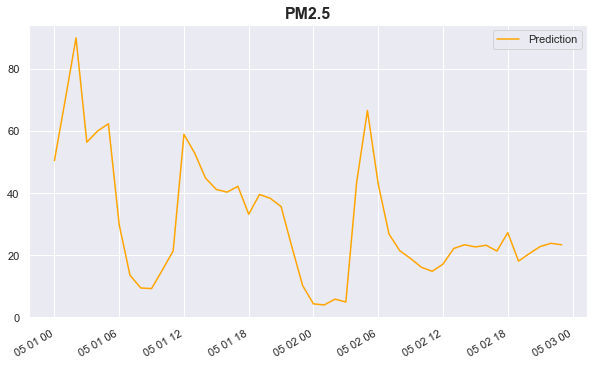

PM2.5        PM10          O3
test_id                                        
dongsi_aq#0   50.388428  570.983093   50.970940
dongsi_aq#1   69.966011  398.672913   74.373703
dongsi_aq#2   89.941780  212.454117   84.382736
dongsi_aq#3   56.327473  151.858902   92.035751
dongsi_aq#4   59.905754   86.468597   99.954247
dongsi_aq#5   62.254147   86.077606  108.889656
dongsi_aq#6   29.740425   86.077606  112.766685
dongsi_aq#7   13.430162   86.077606  107.009972
dongsi_aq#8    9.326347   89.911827   88.139473
dongsi_aq#9    9.136930   89.911827   75.807861
dongsi_aq#10  15.109191   90.906105   60.759861
dongsi_aq#11  21.282724   96.943550   59.123035
dongsi_aq#12  58.837040  575.494568   63.179134
dongsi_aq#13  52.742451  272.796967   47.460312
dongsi_aq#14  44.729153   95.344521   37.805477
dongsi_aq#15  41.077324   98.777863   30.005972
dongsi_aq#16  40.224178   87.086418   29.029089
dongsi_aq#17  42.089455   89.914734   28.027428
dongsi_aq#18  33.092342   90.617126   26.387426
dongsi_aq#19  39.464863   83.971130   32.055653
dongsi_aq#20  38.225262   83.971130   35.201523
dongsi_aq#21  35.571484   85.002914   25.565741
dongsi_aq#22  22.562660   84.340668   19.829653
dongsi_aq#23  10.068716   80.979988   22.653259
dongsi_aq#24   4.198102   81.016800   36.156643
dongsi_aq#25   3.871034   83.615303   63.182251
dongsi_aq#26   5.730595   83.330742   75.777924
dongsi_aq#27   4.808697   83.330742   97.297646
dongsi_aq#28  43.368008  160.403214  101.731636
dongsi_aq#29  66.531776  235.145126  104.374451
dongsi_aq#30  42.822460  153.678955  107.237030
dongsi_aq#31  26.684185   75.175751  103.381165
dongsi_aq#32  21.325104   74.902130  103.061562
dongsi_aq#33  18.827009   80.805183  113.465248
dongsi_aq#34  16.002428   84.187729  106.424088
dongsi_aq#35  14.704441   84.093758  106.980293
dongsi_aq#36  17.018433   83.155945   88.602203
dongsi_aq#37  22.068996   83.535789   81.230721
dongsi_aq#38  23.256229   82.101181   77.435387
dongsi_aq#39  22.562880   82.101181   76.857605
dongsi_aq#40  23.095211   82.101181   74.737610
dongsi_aq#41  21.220688   90.030304   66.470818
dongsi_aq#42  27.176825   89.874321   42.281509
dongsi_aq#43  17.976173   90.906105   31.681910
dongsi_aq#44  20.413635   88.439713   23.640841
dongsi_aq#45  22.683182   85.002914   19.440126
dongsi_aq#46  23.724237   80.979988   32.005142
dongsi_aq#47  23.250553   80.613983   32.585896

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 67.03809595108032 seconds.


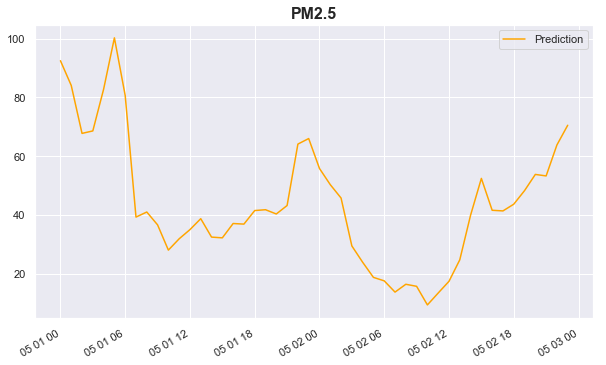

PM2.5        PM10          O3
test_id                                             
yongledian_aq#0    92.459793  112.719734   61.494316
yongledian_aq#1    84.043869  102.308212   76.528923
yongledian_aq#2    67.709167  103.781616   91.702156
yongledian_aq#3    68.557297  107.629974  106.077408
yongledian_aq#4    82.754578  135.141571  110.021049
yongledian_aq#5   100.244514  139.377380  111.880775
yongledian_aq#6    80.610130  135.704269  109.156921
yongledian_aq#7    39.214050  127.513100  109.519173
yongledian_aq#8    40.940186  116.761986   98.363617
yongledian_aq#9    36.565456  107.782135   77.168396
yongledian_aq#10   27.967861  111.980560   58.648224
yongledian_aq#11   31.820074  114.691566   39.053391
yongledian_aq#12   34.945641  112.174896   29.728830
yongledian_aq#13   38.667667  113.842064   29.906261
yongledian_aq#14   32.397430  122.850952   26.410141
yongledian_aq#15   32.142654  125.246292   21.474560
yongledian_aq#16   37.024948  112.844254   22.522760
yongledian_aq#17   36.819847  113.427902   21.293682
yongledian_aq#18   41.437729  116.556129   22.859861
yongledian_aq#19   41.721851   93.245880   24.598766
yongledian_aq#20   40.268093   94.907333   22.077602
yongledian_aq#21   43.148968   90.501778   22.281363
yongledian_aq#22   64.068748  112.595383   25.143631
yongledian_aq#23   65.956367  109.203369   42.595337
yongledian_aq#24   55.769279  102.351212   60.211311
yongledian_aq#25   50.258270  103.661766   91.039772
yongledian_aq#26   45.702541  103.258430  103.460251
yongledian_aq#27   29.392250   83.925652  113.695999
yongledian_aq#28   23.834229   69.767540  117.570335
yongledian_aq#29   18.680880   73.072243  124.587906
yongledian_aq#30   17.496145   73.935844  127.062683
yongledian_aq#31   13.667246   72.461563  126.564148
yongledian_aq#32   16.334478   75.057610  121.703857
yongledian_aq#33   15.639073   74.089485  128.959290
yongledian_aq#34    9.305340   79.815895  109.824142
yongledian_aq#35   13.355355  109.382065   84.835754
yongledian_aq#36   17.340576  115.675888   52.853680
yongledian_aq#37   24.664593  105.203461   38.521984
yongledian_aq#38   39.852871  101.454475   33.233028
yongledian_aq#39   52.382294  110.231133   32.858410
yongledian_aq#40   41.533806  122.795769   22.763611
yongledian_aq#41   41.313702  110.582687   15.408256
yongledian_aq#42   43.602486  112.713753   18.023165
yongledian_aq#43   48.223293  129.648743    5.597764
yongledian_aq#44   53.739773  143.127853    3.584886
yongledian_aq#45   53.228756  146.603867    6.448836
yongledian_aq#46   63.772606  128.633255    9.992882
yongledian_aq#47   70.484001  102.603874   21.857990

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 62.76133489608765 seconds.


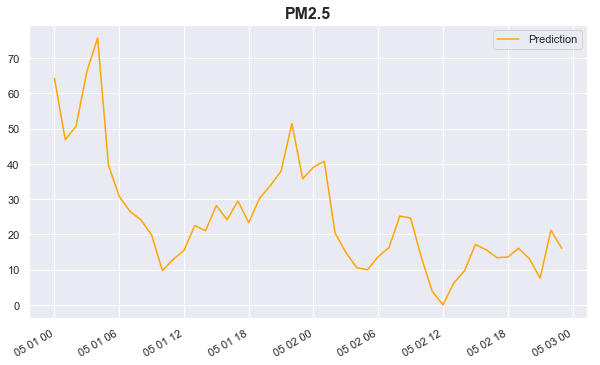

PM2.5        PM10          O3
test_id                                             
miyunshuiku_aq#0   64.349724   65.965782   71.076996
miyunshuiku_aq#1   46.879864   64.325050   78.631233
miyunshuiku_aq#2   50.684391  116.449661   87.662315
miyunshuiku_aq#3   66.149933  168.359070   94.682686
miyunshuiku_aq#4   75.772369  177.453171  100.987839
miyunshuiku_aq#5   39.778343   76.665390  108.139481
miyunshuiku_aq#6   30.790909   62.947296  107.923805
miyunshuiku_aq#7   26.550652   63.015610  104.813591
miyunshuiku_aq#8   24.161165   58.946918  101.881187
miyunshuiku_aq#9   19.879505   52.008492   97.035446
miyunshuiku_aq#10   9.745018   54.225311   98.069229
miyunshuiku_aq#11  12.915714   57.173584  100.524574
miyunshuiku_aq#12  15.461839   76.423195  102.564301
miyunshuiku_aq#13  22.515961   77.832512  102.492592
miyunshuiku_aq#14  21.033764   86.343262   90.040131
miyunshuiku_aq#15  28.202322   68.681114   79.078560
miyunshuiku_aq#16  24.169199   64.295799   74.061661
miyunshuiku_aq#17  29.497049   59.111683   66.108070
miyunshuiku_aq#18  23.333557   55.693729   55.330032
miyunshuiku_aq#19  30.229801   52.761238   53.013676
miyunshuiku_aq#20  33.832226   45.646290   55.316071
miyunshuiku_aq#21  37.954865   65.772736   59.373760
miyunshuiku_aq#22  51.487240   67.290588   64.447975
miyunshuiku_aq#23  35.781788   50.611069   70.389496
miyunshuiku_aq#24  39.085148   49.046150   74.965729
miyunshuiku_aq#25  40.773384   43.582069   83.515053
miyunshuiku_aq#26  20.396044   39.217537   91.403313
miyunshuiku_aq#27  14.885461   44.731552   98.088036
miyunshuiku_aq#28  10.591358   41.898479   98.742004
miyunshuiku_aq#29   9.957934   46.249729  103.958336
miyunshuiku_aq#30  13.699488   75.613518  108.578979
miyunshuiku_aq#31  16.294769   75.975128  115.114159
miyunshuiku_aq#32  25.208172   71.589859  125.146500
miyunshuiku_aq#33  24.651163   65.886452  126.531548
miyunshuiku_aq#34  13.434294   64.740067  123.330109
miyunshuiku_aq#35   3.892972   58.254292  109.380295
miyunshuiku_aq#36   0.000000   50.794811   94.520050
miyunshuiku_aq#37   6.233284   51.398388   89.687759
miyunshuiku_aq#38   9.705920   52.120033   87.722221
miyunshuiku_aq#39  17.150043   68.781776   84.517601
miyunshuiku_aq#40  15.649734   75.879135   78.039482
miyunshuiku_aq#41  13.408555   58.887768   69.086151
miyunshuiku_aq#42  13.576902   74.842072   62.705917
miyunshuiku_aq#43  16.067091   89.426727   62.396053
miyunshuiku_aq#44  13.097306   97.174316   59.896332
miyunshuiku_aq#45   7.580679   88.538605   60.043106
miyunshuiku_aq#46  21.196379   86.482346   58.600845
miyunshuiku_aq#47  16.068184   52.786648   66.899254

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 47.22442102432251 seconds.


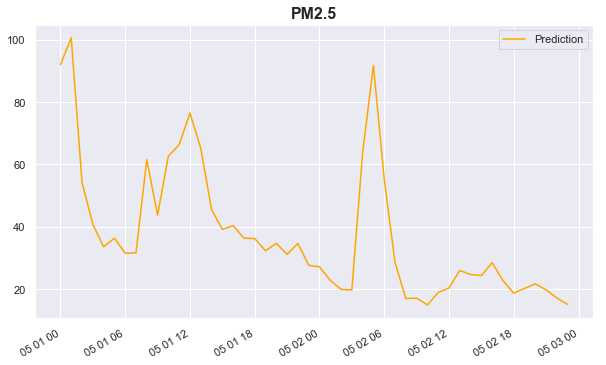

PM2.5        PM10          O3
test_id                                            
zhiwuyuan_aq#0    91.925285  100.680016   80.190384
zhiwuyuan_aq#1   100.541145  173.408356   89.393456
zhiwuyuan_aq#2    54.135933  124.372688   90.358978
zhiwuyuan_aq#3    40.731716   62.945080   95.398636
zhiwuyuan_aq#4    33.477875   62.437256  101.304329
zhiwuyuan_aq#5    36.240601   70.109322  100.119484
zhiwuyuan_aq#6    31.411039   68.871193  101.616837
zhiwuyuan_aq#7    31.584902   61.608532  101.652107
zhiwuyuan_aq#8    61.469086  103.733704   97.491890
zhiwuyuan_aq#9    43.636166   97.309235   92.141945
zhiwuyuan_aq#10   62.584164   76.330063   84.282486
zhiwuyuan_aq#11   66.265030  130.470154   81.821846
zhiwuyuan_aq#12   76.419800   76.468529   64.673744
zhiwuyuan_aq#13   65.134636   81.462044   53.306084
zhiwuyuan_aq#14   45.464745   70.930283   42.196438
zhiwuyuan_aq#15   39.080421   56.337666   36.164436
zhiwuyuan_aq#16   40.277641   51.434155   33.885014
zhiwuyuan_aq#17   36.272064   44.139175   35.230167
zhiwuyuan_aq#18   36.139519   34.219685   38.018604
zhiwuyuan_aq#19   32.239513   35.571629   32.040855
zhiwuyuan_aq#20   34.604130   33.893482   33.505520
zhiwuyuan_aq#21   31.048944   33.504417   37.510616
zhiwuyuan_aq#22   34.588676   35.571629   39.332550
zhiwuyuan_aq#23   27.570242   36.661854   46.068027
zhiwuyuan_aq#24   27.070892   33.746094   58.420586
zhiwuyuan_aq#25   22.729876   41.470543   69.879883
zhiwuyuan_aq#26   19.819426   47.990856   87.210976
zhiwuyuan_aq#27   19.633430   32.582214   94.689766
zhiwuyuan_aq#28   63.793552  125.531868  102.364265
zhiwuyuan_aq#29   91.693840  258.740265   99.541710
zhiwuyuan_aq#30   55.217545  166.598831   94.717430
zhiwuyuan_aq#31   28.461409   39.816540   94.920876
zhiwuyuan_aq#32   16.886318   54.889400   99.575920
zhiwuyuan_aq#33   17.026285   65.443230  101.269630
zhiwuyuan_aq#34   14.848534   60.477837  101.719040
zhiwuyuan_aq#35   18.828365   64.549240   90.728043
zhiwuyuan_aq#36   20.270668   63.051765   86.638268
zhiwuyuan_aq#37   25.918476   56.621037   79.237457
zhiwuyuan_aq#38   24.601791   48.067623   80.703789
zhiwuyuan_aq#39   24.280067   48.067623   84.697197
zhiwuyuan_aq#40   28.370064   47.234226   83.887253
zhiwuyuan_aq#41   22.653154   39.555782   79.780724
zhiwuyuan_aq#42   18.625452   39.810188   74.771919
zhiwuyuan_aq#43   20.122292   33.000484   59.736130
zhiwuyuan_aq#44   21.628376   33.380539   51.135498
zhiwuyuan_aq#45   19.658464   39.122177   46.454033
zhiwuyuan_aq#46   17.070650   34.696598   47.914818
zhiwuyuan_aq#47   14.983552   34.006489   49.853535

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 73.37929701805115 seconds.


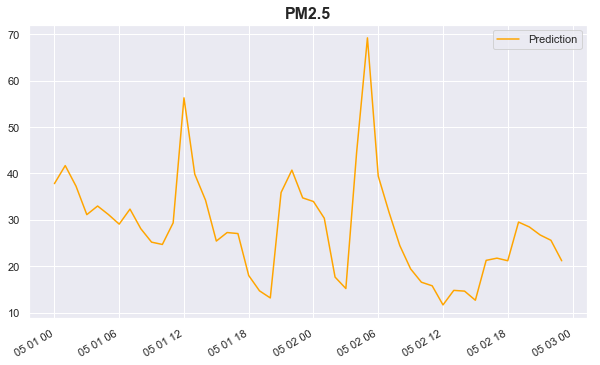

PM2.5        PM10          O3
test_id                                            
donggaocun_aq#0   37.792595   58.378841   48.568146
donggaocun_aq#1   41.677677   64.211533   60.209682
donggaocun_aq#2   37.236198   60.381477   79.766243
donggaocun_aq#3   31.103815   61.840508   88.729340
donggaocun_aq#4   32.962379   63.805077   91.764290
donggaocun_aq#5   31.127640   65.444420   91.557373
donggaocun_aq#6   29.057100   65.725655   90.990067
donggaocun_aq#7   32.294178   73.063705   98.222977
donggaocun_aq#8   28.076334   74.613899  100.163605
donggaocun_aq#9   25.171749   74.465942   89.251617
donggaocun_aq#10  24.673529   79.067123   90.689690
donggaocun_aq#11  29.339298   62.653572   73.776459
donggaocun_aq#12  56.288013   89.576218   71.702782
donggaocun_aq#13  39.838120   67.676239   64.255615
donggaocun_aq#14  34.212910   52.252480   57.370064
donggaocun_aq#15  25.406240   31.621052   47.944874
donggaocun_aq#16  27.244310   33.175964   49.838730
donggaocun_aq#17  27.021656   31.202253   43.766232
donggaocun_aq#18  17.973387   27.287060   40.417694
donggaocun_aq#19  14.672360   25.646338   40.614033
donggaocun_aq#20  13.142246   27.531862   37.939899
donggaocun_aq#21  35.882519   66.699829   34.609585
donggaocun_aq#22  40.702057   92.473686   37.455647
donggaocun_aq#23  34.717167   75.571465   35.303993
donggaocun_aq#24  33.931873   63.818546   43.953205
donggaocun_aq#25  30.330357   52.106735   56.304707
donggaocun_aq#26  17.640448   51.304123   78.018845
donggaocun_aq#27  15.166535   49.987823   83.794838
donggaocun_aq#28  44.576405  169.261566   90.945229
donggaocun_aq#29  69.220291  296.068878   93.628601
donggaocun_aq#30  39.425499  187.772888   97.919098
donggaocun_aq#31  31.621130   42.029617   98.700821
donggaocun_aq#32  24.425623   43.778728  112.001038
donggaocun_aq#33  19.404547   47.741478  124.047050
donggaocun_aq#34  16.533751   50.185551  115.716232
donggaocun_aq#35  15.757673   55.109421  103.561577
donggaocun_aq#36  11.638306   46.682999  102.634247
donggaocun_aq#37  14.774140   44.881748   98.411377
donggaocun_aq#38  14.609693   54.425491   97.190826
donggaocun_aq#39  12.645751   78.442863   93.336945
donggaocun_aq#40  21.245977   94.797508   88.613724
donggaocun_aq#41  21.719572   63.787762   79.524193
donggaocun_aq#42  21.165108   56.512688   75.700218
donggaocun_aq#43  29.497084   73.413620   67.674309
donggaocun_aq#44  28.447166  100.489296   60.372955
donggaocun_aq#45  26.723070   97.928177   49.032612
donggaocun_aq#46  25.573305   79.882080   43.619122
donggaocun_aq#47  21.151218   52.442318   44.782627

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 74.09047508239746 seconds.


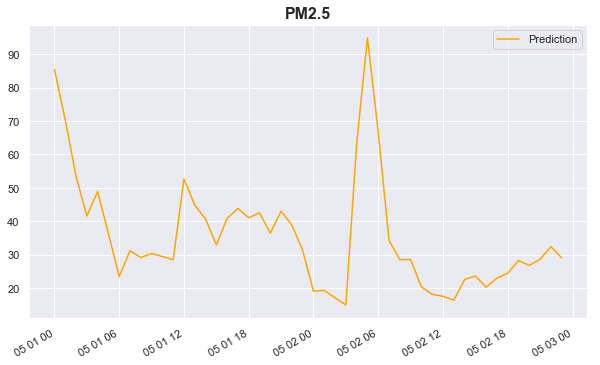

PM2.5        PM10          O3
test_id                                               
wanshouxigong_aq#0   85.421585  296.997040   65.694183
wanshouxigong_aq#1   70.372459  259.855164   79.389435
wanshouxigong_aq#2   53.464653   99.412537   86.882896
wanshouxigong_aq#3   41.589565   99.412537   91.870102
wanshouxigong_aq#4   48.859707   93.003098   97.473457
wanshouxigong_aq#5   36.290012   91.574280  104.897545
wanshouxigong_aq#6   23.469078   91.574280  107.979797
wanshouxigong_aq#7   31.179893   98.044861  103.246353
wanshouxigong_aq#8   29.153215   99.412537   98.435532
wanshouxigong_aq#9   30.342827   99.412537   85.186859
wanshouxigong_aq#10  29.469234  100.214592   72.489555
wanshouxigong_aq#11  28.491692  102.713104   62.550541
wanshouxigong_aq#12  52.650543  119.857109   51.759113
wanshouxigong_aq#13  44.822548  113.913208   43.030186
wanshouxigong_aq#14  40.742355   94.985634   32.340759
wanshouxigong_aq#15  32.916573   95.765892   26.145996
wanshouxigong_aq#16  40.856148   89.154869   25.245001
wanshouxigong_aq#17  43.838173   90.729919   22.229679
wanshouxigong_aq#18  41.039600   92.647881   23.581150
wanshouxigong_aq#19  42.516468   79.175674   24.548410
wanshouxigong_aq#20  36.453575   79.175674   18.768639
wanshouxigong_aq#21  43.035755   75.921783   17.544065
wanshouxigong_aq#22  38.847145   75.921783   18.985575
wanshouxigong_aq#23  31.263975   79.850327   21.178139
wanshouxigong_aq#24  19.073509   87.371368   38.910946
wanshouxigong_aq#25  19.298882   83.358475   61.633003
wanshouxigong_aq#26  17.096716   82.809738   80.902664
wanshouxigong_aq#27  14.980808   84.626869   91.707336
wanshouxigong_aq#28  63.110931  213.419785  103.622467
wanshouxigong_aq#29  94.875610  326.616394  104.285126
wanshouxigong_aq#30  66.629219  184.871323  106.798210
wanshouxigong_aq#31  34.316113   78.327339  103.254852
wanshouxigong_aq#32  28.523956   77.979652  100.973305
wanshouxigong_aq#33  28.570663   90.482452  105.123024
wanshouxigong_aq#34  20.348225   90.134766  102.899971
wanshouxigong_aq#35  18.138243   92.853233   84.460785
wanshouxigong_aq#36  17.582167   94.009972   76.963425
wanshouxigong_aq#37  16.367386   94.009972   73.847740
wanshouxigong_aq#38  22.586555   82.591125   71.756584
wanshouxigong_aq#39  23.623615   80.523369   70.106514
wanshouxigong_aq#40  20.318588   80.523369   72.523354
wanshouxigong_aq#41  22.993355   93.961945   58.952599
wanshouxigong_aq#42  24.484509   98.883102   43.015965
wanshouxigong_aq#43  28.241508   98.883102   27.261169
wanshouxigong_aq#44  26.809740   84.687675   22.475300
wanshouxigong_aq#45  28.652758   83.518425   21.414980
wanshouxigong_aq#46  32.433338   85.421860   23.479761
wanshouxigong_aq#47  29.046841   81.667458   31.212425

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 65.52434182167053 seconds.


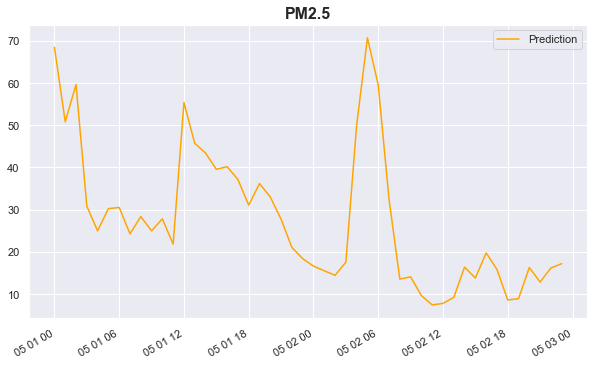

PM2.5        PM10          O3
test_id                                           
pingchang_aq#0   68.431984  179.119415   67.467087
pingchang_aq#1   50.786919  101.209824   78.406090
pingchang_aq#2   59.602768  126.856644   80.597862
pingchang_aq#3   30.804657   98.328827   91.122086
pingchang_aq#4   24.953569   83.898041   92.807632
pingchang_aq#5   30.208899   84.563232   87.332993
pingchang_aq#6   30.488703   86.401802   84.914490
pingchang_aq#7   24.231565   86.174461   95.269386
pingchang_aq#8   28.320391   88.241409   98.117569
pingchang_aq#9   24.937994   87.637405   93.530724
pingchang_aq#10  27.787306   87.181564   84.563416
pingchang_aq#11  21.789495   87.507195   74.197960
pingchang_aq#12  55.346603  140.040878   69.544975
pingchang_aq#13  45.681965  122.370461   65.532753
pingchang_aq#14  43.386990   87.497124   63.619205
pingchang_aq#15  39.522827   84.260155   45.098240
pingchang_aq#16  40.148579   75.843163   34.947697
pingchang_aq#17  37.106186   74.016121   24.289467
pingchang_aq#18  31.037983   65.057396   24.367104
pingchang_aq#19  36.146450   65.163399   25.334455
pingchang_aq#20  32.968903   64.422882   35.321491
pingchang_aq#21  27.686071   61.150715   36.173542
pingchang_aq#22  21.019512   61.619694   33.553780
pingchang_aq#23  18.357138   61.619694   46.761215
pingchang_aq#24  16.578371   56.123631   56.135300
pingchang_aq#25  15.492420   59.765743   66.393112
pingchang_aq#26  14.394636   60.945511   77.195816
pingchang_aq#27  17.517149   59.886211   83.184113
pingchang_aq#28  49.981209  234.055328   92.659515
pingchang_aq#29  70.674004  346.749420   98.894905
pingchang_aq#30  59.494576  203.175858   97.959663
pingchang_aq#31  32.436081   63.892426  100.952789
pingchang_aq#32  13.516582   66.229576  104.402420
pingchang_aq#33  14.043588   84.704468  104.564705
pingchang_aq#34   9.595673   86.025101  105.476418
pingchang_aq#35   7.393238   83.551437  101.113503
pingchang_aq#36   7.756768   80.202744   89.322853
pingchang_aq#37   9.171449   62.089504   78.554230
pingchang_aq#38  16.352160   70.718369   71.512939
pingchang_aq#39  13.760086   65.211441   64.728394
pingchang_aq#40  19.724363   62.112720   53.766178
pingchang_aq#41  15.805913   64.111145   47.416180
pingchang_aq#42   8.548298   62.929756   36.335808
pingchang_aq#43   8.872433   62.217064   29.340094
pingchang_aq#44  16.262001   62.508118   30.145868
pingchang_aq#45  12.802128   63.065479   34.611576
pingchang_aq#46  16.144480   62.508118   33.312439
pingchang_aq#47  17.166798   61.375484   34.901688

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 61.72194290161133 seconds.


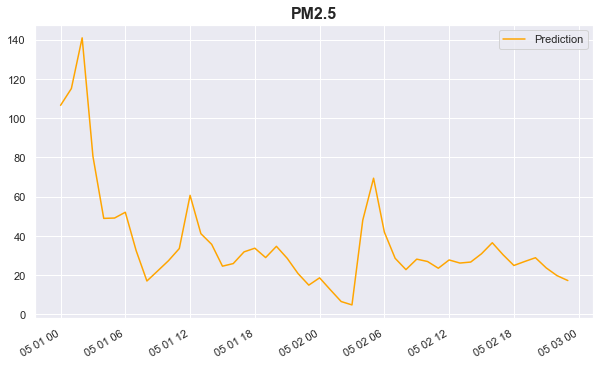

PM2.5        PM10          O3
test_id                                           
fangshan_aq#0   106.516151  211.165955   59.918983
fangshan_aq#1   115.060677  223.524902   87.190163
fangshan_aq#2   140.907867  264.378235  100.733047
fangshan_aq#3    80.502136  164.344269  107.285507
fangshan_aq#4    48.896492  104.162857  110.977303
fangshan_aq#5    49.075432  104.162857  116.146645
fangshan_aq#6    52.021942  104.162857  114.903084
fangshan_aq#7    32.525127  104.162857  112.088501
fangshan_aq#8    16.987122  104.162857   98.495239
fangshan_aq#9    22.136013  104.832687   82.191689
fangshan_aq#10   27.339767  102.515190   64.076881
fangshan_aq#11   33.525986   95.547218   61.226749
fangshan_aq#12   60.648434  163.196930   50.448444
fangshan_aq#13   41.117287  340.828461   52.712837
fangshan_aq#14   35.669987   92.723518   37.633366
fangshan_aq#15   24.547516   93.095451   30.305422
fangshan_aq#16   25.866293   89.498367   24.185230
fangshan_aq#17   31.832766   88.834900   21.207273
fangshan_aq#18   33.701355   93.715508   17.262888
fangshan_aq#19   28.923658   91.147209   11.857360
fangshan_aq#20   34.652966   88.303688   10.573058
fangshan_aq#21   28.538097   87.336967    7.117566
fangshan_aq#22   20.788734   86.066574   12.334183
fangshan_aq#23   14.884938   90.502144   14.608452
fangshan_aq#24   18.604273   92.549606   45.165188
fangshan_aq#25   12.486119   93.781509   77.224686
fangshan_aq#26    6.514699   93.781509   96.867714
fangshan_aq#27    4.798670   93.781509  106.303276
fangshan_aq#28   47.996155  254.037949  109.263474
fangshan_aq#29   69.373482  298.114990  109.888741
fangshan_aq#30   41.909443  173.567749  113.232056
fangshan_aq#31   28.554794  104.624802  113.875443
fangshan_aq#32   22.790319  104.624802  102.834961
fangshan_aq#33   28.121130  109.048737   99.525078
fangshan_aq#34   26.923889  109.048737  105.572273
fangshan_aq#35   23.491888  109.048737  104.312271
fangshan_aq#36   27.712606  107.552063   99.185341
fangshan_aq#37   26.136068  104.162857   95.517097
fangshan_aq#38   26.640224  104.832687   89.747353
fangshan_aq#39   30.862452  104.624802   73.121025
fangshan_aq#40   36.480289  100.902313   61.359081
fangshan_aq#41   30.353254  103.954971   51.719685
fangshan_aq#42   24.893343  103.513695   43.502495
fangshan_aq#43   26.922762  104.162857   28.464167
fangshan_aq#44   28.844418  100.855133   22.944393
fangshan_aq#45   23.644695   97.300377   16.440691
fangshan_aq#46   19.714632   96.739052   18.654400
fangshan_aq#47   17.216190   95.520027   22.561193

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 73.60036706924438 seconds.


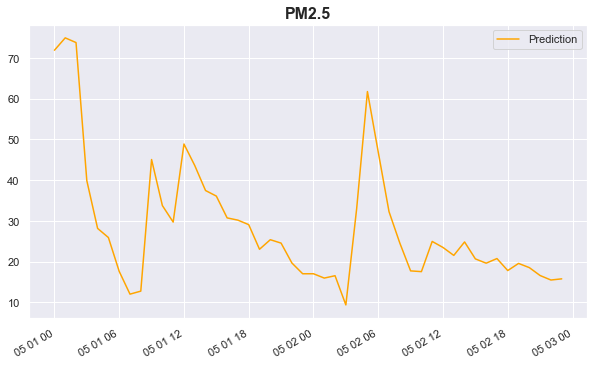

PM2.5        PM10          O3
test_id                                       
miyun_aq#0   71.861107  150.011093   69.513077
miyun_aq#1   74.899094  161.074005  101.258438
miyun_aq#2   73.743469  107.096245  114.181519
miyun_aq#3   39.857647   63.478184  113.806793
miyun_aq#4   28.142941   63.478184  117.079460
miyun_aq#5   25.903980   63.478184  118.608177
miyun_aq#6   17.600491   64.150948  116.202148
miyun_aq#7   12.014133   67.646721  114.961647
miyun_aq#8   12.753231   68.868988  102.293015
miyun_aq#9   45.044472  100.053040  109.048416
miyun_aq#10  33.749058   85.022820   96.306770
miyun_aq#11  29.695618   77.577621   86.427757
miyun_aq#12  48.849632  105.142960   75.606247
miyun_aq#13  43.574646   92.071465   65.179871
miyun_aq#14  37.439243   73.117210   61.922726
miyun_aq#15  36.073162   65.783951   41.413322
miyun_aq#16  30.724346   60.282799   32.484188
miyun_aq#17  30.168869   57.500072   17.220661
miyun_aq#18  29.067127   57.173088   20.916513
miyun_aq#19  23.021652   59.124832   17.904810
miyun_aq#20  25.371429   58.536697   18.659868
miyun_aq#21  24.533379   56.914963   19.951498
miyun_aq#22  19.659321   61.284527   26.153685
miyun_aq#23  17.015507   57.440720   31.162167
miyun_aq#24  17.015793   61.510998   47.783741
miyun_aq#25  15.955326   58.589291   73.253105
miyun_aq#26  16.534874   53.265533   94.490891
miyun_aq#27   9.371140   53.265533  106.147163
miyun_aq#28  32.951347  135.576813  105.877251
miyun_aq#29  61.722725  380.768280  108.366730
miyun_aq#30  46.886665  213.793900  108.442757
miyun_aq#31  32.249138   67.380302  113.078278
miyun_aq#32  24.550888   69.323196  119.710922
miyun_aq#33  17.721035   71.206131  106.766060
miyun_aq#34  17.537491   68.028992   94.142647
miyun_aq#35  24.948246   66.727264   85.962181
miyun_aq#36  23.467876   69.371719   68.399673
miyun_aq#37  21.520016   67.241753   70.570183
miyun_aq#38  24.821484   63.286556   71.483086
miyun_aq#39  20.665066   62.933136   49.780991
miyun_aq#40  19.610245   61.791821   47.678154
miyun_aq#41  20.748512   61.127792   43.765259
miyun_aq#42  17.799847   61.127792   46.374950
miyun_aq#43  19.552528   62.475521   35.042892
miyun_aq#44  18.521778   59.921795   24.333223
miyun_aq#45  16.578686   63.573204   23.742630
miyun_aq#46  15.479557   60.559555   33.197498
miyun_aq#47  15.765564   55.533985   31.448236

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 64.64475417137146 seconds.


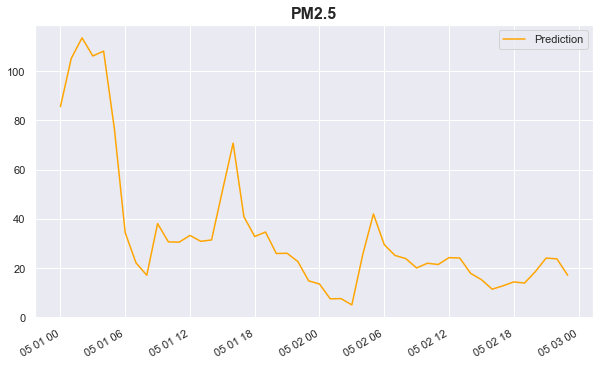

PM2.5        PM10          O3
test_id                                           
yizhuang_aq#0    85.529160  197.804794   52.220844
yizhuang_aq#1   105.092346  196.119385   75.442543
yizhuang_aq#2   113.468071  192.507523   87.720940
yizhuang_aq#3   106.114517  447.749847   93.667366
yizhuang_aq#4   108.075600  298.859802  102.168213
yizhuang_aq#5    76.466370  196.633347   99.615334
yizhuang_aq#6    34.354385  115.304459  101.902550
yizhuang_aq#7    22.110432   93.747314   99.261414
yizhuang_aq#8    17.069633   91.061508   99.664459
yizhuang_aq#9    38.042191  116.473465   93.361076
yizhuang_aq#10   30.629059  108.111786   83.619904
yizhuang_aq#11   30.503593   78.082527   77.553040
yizhuang_aq#12   33.245781   75.952049   68.940880
yizhuang_aq#13   30.850626   73.000404   64.681877
yizhuang_aq#14   31.406717   72.455788   55.723499
yizhuang_aq#15   51.210602   93.783188   54.174259
yizhuang_aq#16   70.716660  135.986237   55.798523
yizhuang_aq#17   40.827126  101.686035   46.907619
yizhuang_aq#18   32.795895   66.763367   32.866852
yizhuang_aq#19   34.624153   65.322968   21.567766
yizhuang_aq#20   25.896532   64.738052   29.638632
yizhuang_aq#21   26.005932   69.511253   27.832640
yizhuang_aq#22   22.615957   68.327637   29.420458
yizhuang_aq#23   14.785431   68.327637   42.839279
yizhuang_aq#24   13.513219   75.404213   67.878944
yizhuang_aq#25    7.501705   72.269073   89.863113
yizhuang_aq#26    7.581782   72.269073  102.481064
yizhuang_aq#27    5.027684   65.777412  105.174660
yizhuang_aq#28   25.303385  152.248672  111.057144
yizhuang_aq#29   41.960022  187.500183  107.792000
yizhuang_aq#30   29.508734  109.145050   91.422058
yizhuang_aq#31   25.106024   68.946098   93.760559
yizhuang_aq#32   23.834642   69.329971  110.501434
yizhuang_aq#33   20.031601   72.725403  114.789200
yizhuang_aq#34   21.945417   76.590996  107.396210
yizhuang_aq#35   21.441362   84.185364  100.626694
yizhuang_aq#36   24.226233   79.276138   88.974236
yizhuang_aq#37   24.065351   76.552132   87.100037
yizhuang_aq#38   17.857010   73.130714   85.488998
yizhuang_aq#39   15.298863   71.693253   83.680435
yizhuang_aq#40   11.416723   70.594810   78.160217
yizhuang_aq#41   12.772103   76.437035   60.468246
yizhuang_aq#42   14.369209   75.338593   39.949844
yizhuang_aq#43   13.898906   80.775719   13.629059
yizhuang_aq#44   18.536970   74.103455    9.679608
yizhuang_aq#45   24.052011   68.912560   27.882065
yizhuang_aq#46   23.719725   68.327637   32.545719
yizhuang_aq#47   17.061941   66.598694   42.136116

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 70.65155696868896 seconds.


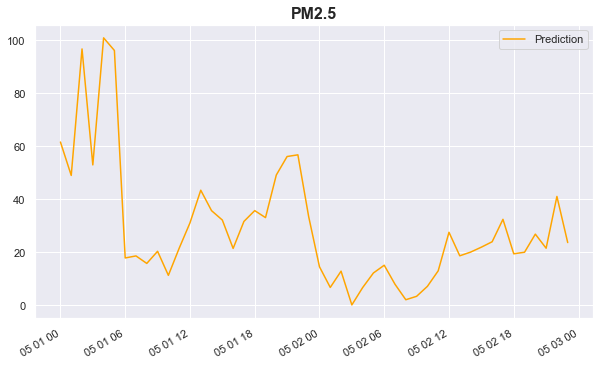

PM2.5        PM10          O3
test_id                                                 
yongdingmennei_aq#0    61.483139  103.729172   62.656498
yongdingmennei_aq#1    48.878960  103.729172   75.086128
yongdingmennei_aq#2    96.617790  103.729172   79.391144
yongdingmennei_aq#3    52.851063  102.613190   82.098923
yongdingmennei_aq#4   100.803192  102.613190   88.685944
yongdingmennei_aq#5    96.042595  102.613190   91.521629
yongdingmennei_aq#6    17.726995  102.613190   91.753960
yongdingmennei_aq#7    18.491531  105.319946   91.730682
yongdingmennei_aq#8    15.659984  111.655212   74.904419
yongdingmennei_aq#9    20.238510  103.729172   46.000870
yongdingmennei_aq#10   11.161175  106.801064   35.745445
yongdingmennei_aq#11   21.380690  108.608963   32.283184
yongdingmennei_aq#12   30.950684  107.195656   46.186432
yongdingmennei_aq#13   43.296711  104.855537   40.471813
yongdingmennei_aq#14   35.577118  102.114182   27.213495
yongdingmennei_aq#15   32.035515  104.380051   20.401932
yongdingmennei_aq#16   21.320963  101.858337   26.172100
yongdingmennei_aq#17   31.509302   99.496506   26.191282
yongdingmennei_aq#18   35.590256  103.533875   26.367636
yongdingmennei_aq#19   32.951591   83.870560   28.885544
yongdingmennei_aq#20   49.030045   81.977333   33.777008
yongdingmennei_aq#21   56.011974   79.470314   38.715134
yongdingmennei_aq#22   56.651089   83.822639   47.322838
yongdingmennei_aq#23   33.307537   72.141174   55.151291
yongdingmennei_aq#24   14.398211   80.879868   56.868858
yongdingmennei_aq#25    6.596069   81.650978   62.143353
yongdingmennei_aq#26   12.740653   82.189896   69.203606
yongdingmennei_aq#27    0.000000   78.499641   73.742813
yongdingmennei_aq#28    6.538562   66.718834   79.438995
yongdingmennei_aq#29   12.064361   75.303391   80.165031
yongdingmennei_aq#30   14.974744   82.418655   86.143555
yongdingmennei_aq#31    7.784025   85.347610   93.386070
yongdingmennei_aq#32    1.954382   93.467384   99.378555
yongdingmennei_aq#33    3.246854   98.306831  105.894913
yongdingmennei_aq#34    7.007848   98.306831   91.525391
yongdingmennei_aq#35   12.868613  111.990883   73.537621
yongdingmennei_aq#36   27.412197  110.979050   54.888428
yongdingmennei_aq#37   18.535704  115.551079   40.324841
yongdingmennei_aq#38   19.928377   98.406235   29.174000
yongdingmennei_aq#39   21.800852   92.353905   25.184217
yongdingmennei_aq#40   23.842447   92.353905   30.611513
yongdingmennei_aq#41   32.301544  103.729172   18.359205
yongdingmennei_aq#42   19.289671  105.313126   15.718058
yongdingmennei_aq#43   19.886299  101.683746   12.131003
yongdingmennei_aq#44   26.713306   92.098053    9.199339
yongdingmennei_aq#45   21.397141   80.379677   14.337681
yongdingmennei_aq#46   40.941460   73.188721   23.947655
yongdingmennei_aq#47   23.531786   72.141174   40.870846

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 73.21502113342285 seconds.


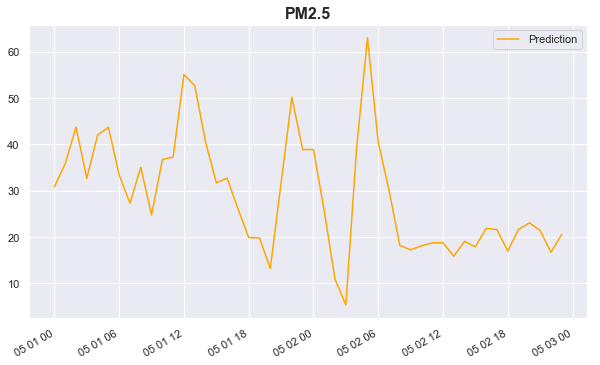

PM2.5        PM10          O3
test_id                                        
pinggu_aq#0   30.842909   65.238838   47.178463
pinggu_aq#1   35.808754   68.414650   72.260033
pinggu_aq#2   43.699497   69.530449   89.318901
pinggu_aq#3   32.644581   69.530449  107.772018
pinggu_aq#4   42.017311   70.761887  111.962921
pinggu_aq#5   43.668430   72.109947  115.560471
pinggu_aq#6   33.380432   72.109947  114.594185
pinggu_aq#7   27.269318   73.349052  116.790649
pinggu_aq#8   35.030647   72.117615  115.322365
pinggu_aq#9   24.749735   67.314819   99.736824
pinggu_aq#10  36.692940   66.477951   91.877281
pinggu_aq#11  37.260918   65.863441   79.989563
pinggu_aq#12  55.066975   85.263512   80.203407
pinggu_aq#13  52.627731   88.529884   82.491028
pinggu_aq#14  40.529659   62.267097   69.612404
pinggu_aq#15  31.676666   59.938244   57.677544
pinggu_aq#16  32.703144   59.842678   54.623760
pinggu_aq#17  26.109110   59.842678   50.842991
pinggu_aq#18  19.881172   59.842678   48.275448
pinggu_aq#19  19.774866   59.842678   38.633102
pinggu_aq#20  13.191472   59.842678   35.348118
pinggu_aq#21  31.679846   79.529709   29.774292
pinggu_aq#22  50.140812  112.944138   27.195511
pinggu_aq#23  38.852448   91.200043   26.199871
pinggu_aq#24  38.851433   69.189774   46.097797
pinggu_aq#25  25.593313   68.455872   82.375252
pinggu_aq#26  10.852921   69.803932   93.950508
pinggu_aq#27   5.336946   69.803932  106.434311
pinggu_aq#28  39.243641  129.792648  106.338249
pinggu_aq#29  62.958076  197.527328  106.357880
pinggu_aq#30  40.475769  137.538635  106.079353
pinggu_aq#31  30.097200   66.170296  111.005486
pinggu_aq#32  18.163855   66.538536  123.971977
pinggu_aq#33  17.218639   69.803932  121.528252
pinggu_aq#34  18.069626   69.803932  103.233047
pinggu_aq#35  18.725086   69.803932  100.624176
pinggu_aq#36  18.773062   66.170296   98.251648
pinggu_aq#37  15.836563   68.572495   98.772102
pinggu_aq#38  19.055693   67.244865  100.400475
pinggu_aq#39  17.870565   67.496490   97.373718
pinggu_aq#40  21.856701   68.414650   95.471825
pinggu_aq#41  21.588829   66.129066   89.817108
pinggu_aq#42  16.973894   67.496490   80.200684
pinggu_aq#43  21.621672   69.653763   64.760674
pinggu_aq#44  23.049450   66.108635   53.818699
pinggu_aq#45  21.415009   62.653900   40.202728
pinggu_aq#46  16.687513   61.428085   33.780880
pinggu_aq#47  20.536314   65.998619   33.564415

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 56.662561893463135 seconds.


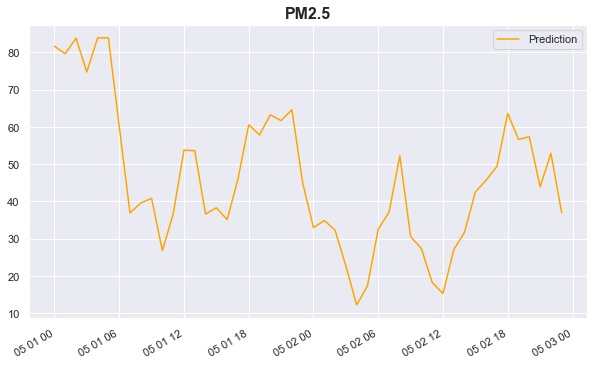

PM2.5        PM10         O3
test_id                                           
nansanhuan_aq#0   81.618301  132.822754  39.672401
nansanhuan_aq#1   79.636421  117.999634  46.373295
nansanhuan_aq#2   83.770325  183.218658  62.799252
nansanhuan_aq#3   74.724556  212.464325  72.472939
nansanhuan_aq#4   83.879105  217.296234  78.233582
nansanhuan_aq#5   83.877388  232.607956  86.249023
nansanhuan_aq#6   60.204952  221.639694  87.392509
nansanhuan_aq#7   36.942436  165.425766  86.403656
nansanhuan_aq#8   39.597420  146.757568  73.650826
nansanhuan_aq#9   40.845917  127.204277  49.746941
nansanhuan_aq#10  26.839830  152.948029  30.779360
nansanhuan_aq#11  36.599430  156.045593  24.801950
nansanhuan_aq#12  53.759624  151.575287  28.088268
nansanhuan_aq#13  53.623272  132.749344  28.261787
nansanhuan_aq#14  36.638878  143.397568  20.838940
nansanhuan_aq#15  38.299007  153.595612  19.469501
nansanhuan_aq#16  35.147629  143.013321  16.566900
nansanhuan_aq#17  45.937649  141.987671  16.032242
nansanhuan_aq#18  60.569973  148.113358  16.559252
nansanhuan_aq#19  57.832127  130.382782  19.046295
nansanhuan_aq#20  63.238136  119.636612  20.509024
nansanhuan_aq#21  61.694302   98.961334  20.970352
nansanhuan_aq#22  64.639404  101.111473  25.791956
nansanhuan_aq#23  45.000374  100.931107  37.930946
nansanhuan_aq#24  32.982140  105.297020  43.693604
nansanhuan_aq#25  34.898697   96.233826  50.621002
nansanhuan_aq#26  32.301868   94.461060  59.622925
nansanhuan_aq#27  22.739712   88.731255  64.700745
nansanhuan_aq#28  12.265702   89.224915  70.997368
nansanhuan_aq#29  17.347437   97.244385  71.575645
nansanhuan_aq#30  32.558296  114.495789  69.606270
nansanhuan_aq#31  37.100948  114.495789  71.123077
nansanhuan_aq#32  52.266556  110.510933  74.423088
nansanhuan_aq#33  30.591078  116.545647  72.006432
nansanhuan_aq#34  27.369001  117.974579  63.214199
nansanhuan_aq#35  18.309517  139.761185  45.511383
nansanhuan_aq#36  15.305680  136.875275  39.486912
nansanhuan_aq#37  27.055571  136.812683  32.473198
nansanhuan_aq#38  31.766563  135.205460  29.358992
nansanhuan_aq#39  42.567532  133.679703  27.934526
nansanhuan_aq#40  45.720440  126.561920  21.778883
nansanhuan_aq#41  49.417103  118.477081  18.974596
nansanhuan_aq#42  63.619411  134.840195  16.745127
nansanhuan_aq#43  56.649269  152.184540  11.860485
nansanhuan_aq#44  57.339329  133.960159   9.408167
nansanhuan_aq#45  43.907230  130.245926  13.049821
nansanhuan_aq#46  52.898209  156.375519  21.286392
nansanhuan_aq#47  36.972321   96.391380  31.320911

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 69.43308305740356 seconds.


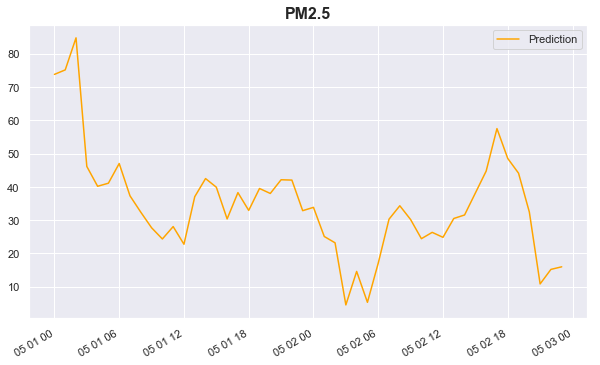

PM2.5        PM10          O3
test_id                                            
beibuxinqu_aq#0   73.815155   71.929382   48.197865
beibuxinqu_aq#1   75.166824  179.451294   71.228775
beibuxinqu_aq#2   84.792908  201.593506   85.782768
beibuxinqu_aq#3   46.145542  118.156105   92.554077
beibuxinqu_aq#4   40.185017  126.933632   98.369392
beibuxinqu_aq#5   41.110165  119.538002  110.401482
beibuxinqu_aq#6   47.026131  126.532875  120.300674
beibuxinqu_aq#7   37.314209  150.181198  119.437386
beibuxinqu_aq#8   32.402428  116.668594  115.012192
beibuxinqu_aq#9   27.717175  126.013107   97.368973
beibuxinqu_aq#10  24.346729  156.299423   60.486160
beibuxinqu_aq#11  28.072716  119.847557   43.500980
beibuxinqu_aq#12  22.762299  139.226257   44.448193
beibuxinqu_aq#13  37.055660  102.428596   32.776951
beibuxinqu_aq#14  42.500145  102.313072   27.703657
beibuxinqu_aq#15  39.905949  129.027191   11.051418
beibuxinqu_aq#16  30.371355  134.826904   10.269247
beibuxinqu_aq#17  38.275150  143.449951    7.401699
beibuxinqu_aq#18  32.931690  102.068298    9.393868
beibuxinqu_aq#19  39.519733   85.980331   14.867067
beibuxinqu_aq#20  38.028103  120.445831   21.013248
beibuxinqu_aq#21  42.146305   97.359550   29.147886
beibuxinqu_aq#22  42.044884   94.555901   36.902454
beibuxinqu_aq#23  32.853306   65.962364   45.625053
beibuxinqu_aq#24  33.849747   60.817387   59.730331
beibuxinqu_aq#25  25.092976   56.946011   67.895256
beibuxinqu_aq#26  23.191315   59.436623   74.336411
beibuxinqu_aq#27   4.529491   53.364635   85.846779
beibuxinqu_aq#28  14.593263   87.568359   92.140068
beibuxinqu_aq#29   5.306496   64.844589   94.379677
beibuxinqu_aq#30  17.081570   81.802879   99.962219
beibuxinqu_aq#31  30.296600   91.180870  104.627724
beibuxinqu_aq#32  34.331802   98.989326  108.178055
beibuxinqu_aq#33  30.184500  106.812996  107.498131
beibuxinqu_aq#34  24.431639  103.094383  106.958412
beibuxinqu_aq#35  26.334160  114.657890   97.302849
beibuxinqu_aq#36  24.841856  121.237968   63.253601
beibuxinqu_aq#37  30.504730  115.678299   32.973862
beibuxinqu_aq#38  31.559269   93.897667   22.532333
beibuxinqu_aq#39  38.158161  119.034302   23.493141
beibuxinqu_aq#40  44.746120   89.437286   28.242933
beibuxinqu_aq#41  57.521332  107.610924   28.721001
beibuxinqu_aq#42  48.551624   87.614769   26.589949
beibuxinqu_aq#43  44.119003  134.582779   19.611311
beibuxinqu_aq#44  32.458424  153.333313   20.043041
beibuxinqu_aq#45  10.839226  107.353981   22.126711
beibuxinqu_aq#46  15.205148   71.460411   25.583456
beibuxinqu_aq#47  15.982949   55.080307   33.923862

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 61.060630083084106 seconds.


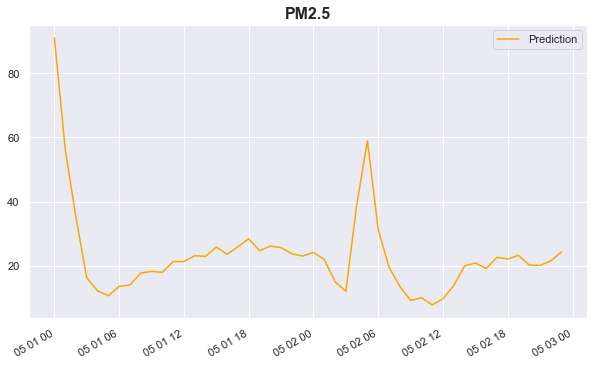

PM2.5        PM10          O3
test_id                                        
yanqin_aq#0   90.922630  356.707001   45.173702
yanqin_aq#1   56.233273  392.052490   74.311356
yanqin_aq#2   34.849609   71.273117   87.433273
yanqin_aq#3   16.216438   67.443535  100.844025
yanqin_aq#4   12.204943   81.548523   91.068825
yanqin_aq#5   10.672581   85.669502   97.105965
yanqin_aq#6   13.586745   85.669502  102.010201
yanqin_aq#7   14.067186   85.669502  102.757347
yanqin_aq#8   17.753605   85.175644  100.314728
yanqin_aq#9   18.254705   77.158005   97.109016
yanqin_aq#10  17.964197   81.542732   95.263023
yanqin_aq#11  21.317858   76.076805   93.228470
yanqin_aq#12  21.322229   71.228905   85.019394
yanqin_aq#13  23.132311   78.151947   48.018696
yanqin_aq#14  22.940044   73.519745   32.599728
yanqin_aq#15  25.842028   68.505486   23.381773
yanqin_aq#16  23.594006   68.505486   20.365398
yanqin_aq#17  25.920496   68.505486   20.936892
yanqin_aq#18  28.421051   66.007477   18.051506
yanqin_aq#19  24.685099   66.139023   13.753874
yanqin_aq#20  26.105295   66.139023   14.948845
yanqin_aq#21  25.651611   64.362366   12.205824
yanqin_aq#22  23.734858   59.174877   12.318752
yanqin_aq#23  23.015541   61.785049   22.057329
yanqin_aq#24  24.180685   54.593258   31.131519
yanqin_aq#25  21.965223   54.593258   45.770828
yanqin_aq#26  15.024226   54.593258   64.844620
yanqin_aq#27  12.078248   60.023445   91.064430
yanqin_aq#28  38.759174  122.998817  110.182976
yanqin_aq#29  58.878304  217.898514  117.984985
yanqin_aq#30  31.213327  169.515259  118.553627
yanqin_aq#31  19.568758   69.995453  115.628410
yanqin_aq#32  13.570660   74.941765  108.585716
yanqin_aq#33   9.198946   75.955238  106.083153
yanqin_aq#34  10.064403   75.955238  105.736450
yanqin_aq#35   7.826524   75.955238  103.167282
yanqin_aq#36   9.752769   75.955238   76.926628
yanqin_aq#37  13.867655   77.053230   52.534576
yanqin_aq#38  19.954926   68.505486   27.794039
yanqin_aq#39  20.883200   68.505486   37.144596
yanqin_aq#40  19.145691   68.505486   39.406586
yanqin_aq#41  22.638741   68.505486   25.892225
yanqin_aq#42  22.118380   67.188026   21.924694
yanqin_aq#43  23.273474   66.139023   17.722553
yanqin_aq#44  20.169750   66.139023   16.292601
yanqin_aq#45  20.118786   60.924541   13.672490
yanqin_aq#46  21.560808   60.924541   11.552263
yanqin_aq#47  24.341915   54.593258   15.077134

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 60.005450963974 seconds.


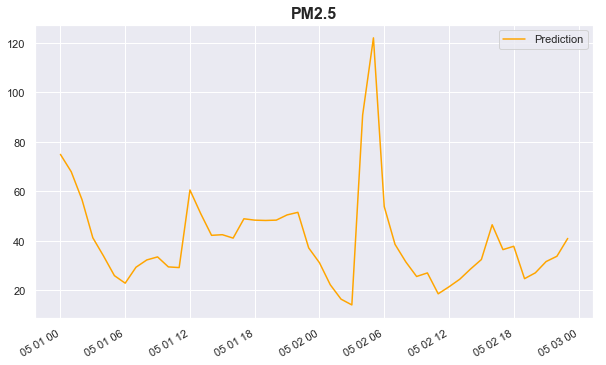

PM2.5        PM10          O3
test_id                                              
xizhimenbei_aq#0    74.956337  194.611954   48.716335
xizhimenbei_aq#1    67.943413   99.034866   66.887535
xizhimenbei_aq#2    56.643517   97.188652   77.356018
xizhimenbei_aq#3    41.259182   93.058098   87.140396
xizhimenbei_aq#4    33.814167   91.715874   97.141167
xizhimenbei_aq#5    25.936041   91.715874  100.654091
xizhimenbei_aq#6    22.888290   91.715874  101.089951
xizhimenbei_aq#7    29.338085   97.322845   99.692581
xizhimenbei_aq#8    32.283012   98.131233   87.909462
xizhimenbei_aq#9    33.513268   99.566544   73.281998
xizhimenbei_aq#10   29.469080   99.566544   67.078880
xizhimenbei_aq#11   29.199057  101.588005   55.711372
xizhimenbei_aq#12   60.567009  195.947968   44.435909
xizhimenbei_aq#13   50.979858  180.298950   35.375805
xizhimenbei_aq#14   42.235729   96.046074   28.031269
xizhimenbei_aq#15   42.491241   94.316811   26.723623
xizhimenbei_aq#16   41.115017   91.861794   25.926403
xizhimenbei_aq#17   48.925625   94.769592   27.484335
xizhimenbei_aq#18   48.376102   91.231537   24.226454
xizhimenbei_aq#19   48.247128   83.801628   22.612547
xizhimenbei_aq#20   48.380901   82.140869   21.971920
xizhimenbei_aq#21   50.489796   84.478813   19.609081
xizhimenbei_aq#22   51.533642   84.759575   20.776051
xizhimenbei_aq#23   37.158386   80.752190   23.640589
xizhimenbei_aq#24   31.142553   80.064331   30.872362
xizhimenbei_aq#25   22.255449   71.259468   57.200645
xizhimenbei_aq#26   16.423594   69.038589   72.980049
xizhimenbei_aq#27   14.102647   69.177010   86.771561
xizhimenbei_aq#28   90.886856  211.998749   90.789551
xizhimenbei_aq#29  122.075790  374.044678   95.995796
xizhimenbei_aq#30   53.870464  209.850540   97.402588
xizhimenbei_aq#31   38.594677   78.011139   95.624374
xizhimenbei_aq#32   31.490177   88.743675   89.091904
xizhimenbei_aq#33   25.595089   90.235756   90.252716
xizhimenbei_aq#34   27.039028   90.235756   86.148651
xizhimenbei_aq#35   18.590830   91.352470   78.104240
xizhimenbei_aq#36   21.419176   91.864143   73.132286
xizhimenbei_aq#37   24.496290   90.610710   68.361549
xizhimenbei_aq#38   28.625795   79.322632   68.390816
xizhimenbei_aq#39   32.448071   79.322632   61.217285
xizhimenbei_aq#40   46.509521   85.375526   52.282883
xizhimenbei_aq#41   36.458366   98.401970   45.179287
xizhimenbei_aq#42   37.813869   99.512817   33.849926
xizhimenbei_aq#43   24.718714   85.263443   25.750790
xizhimenbei_aq#44   27.068514   84.837051   20.105621
xizhimenbei_aq#45   31.634733   85.623795   19.798731
xizhimenbei_aq#46   33.773312   82.198700   20.859905
xizhimenbei_aq#47   40.978054   80.064331   22.861519

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 71.50193810462952 seconds.


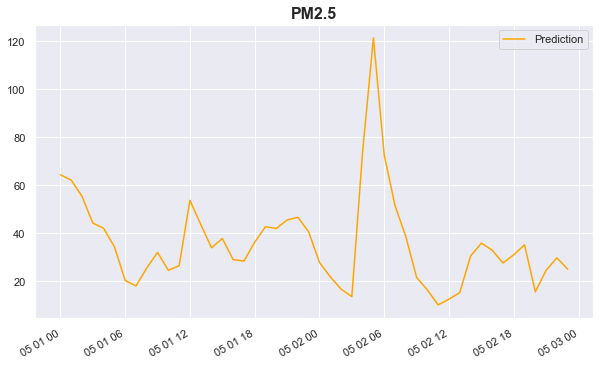

PM2.5        PM10          O3
test_id                                           
guanyuan_aq#0    64.352226  165.364044   52.475548
guanyuan_aq#1    62.072044  100.405884   73.226700
guanyuan_aq#2    55.297665   98.302956   85.642250
guanyuan_aq#3    44.171017   95.950310   94.346764
guanyuan_aq#4    41.969547   91.662773  105.732979
guanyuan_aq#5    34.278625   92.575867  106.987427
guanyuan_aq#6    20.216179   92.575867  112.980865
guanyuan_aq#7    17.886393   97.028801  111.110725
guanyuan_aq#8    25.423838   98.083778   99.178917
guanyuan_aq#9    31.903275   99.357933   98.064629
guanyuan_aq#10   24.446260   99.841942   75.944862
guanyuan_aq#11   26.359434  102.584351   69.110176
guanyuan_aq#12   53.653408  320.624115   66.912910
guanyuan_aq#13   43.588142  218.180603   51.345604
guanyuan_aq#14   33.831715   95.597305   32.878162
guanyuan_aq#15   37.723053   96.454391   38.756817
guanyuan_aq#16   28.927038   92.167122   31.903120
guanyuan_aq#17   28.284859   90.866890   28.375433
guanyuan_aq#18   36.173454   84.287582   26.799028
guanyuan_aq#19   42.648869   80.099289   27.479927
guanyuan_aq#20   41.901775   78.884727   28.431995
guanyuan_aq#21   45.422344   79.888557   29.018591
guanyuan_aq#22   46.586903   84.366699   26.284559
guanyuan_aq#23   40.478390   77.562408   35.192791
guanyuan_aq#24   27.728008   91.971733   40.135483
guanyuan_aq#25   21.710651   86.463814   58.343700
guanyuan_aq#26   16.596096   85.321617   79.099548
guanyuan_aq#27   13.468251   85.321617   97.519966
guanyuan_aq#28   74.069771  257.949890  105.393715
guanyuan_aq#29  121.469429  443.643188  101.246132
guanyuan_aq#30   72.563660  258.586914  104.607254
guanyuan_aq#31   51.481731   78.992485  105.330017
guanyuan_aq#32   38.497383   79.905586  107.672913
guanyuan_aq#33   21.503727   92.575867  109.763916
guanyuan_aq#34   16.208525   92.575867  103.537636
guanyuan_aq#35    9.993071   93.059883  102.236298
guanyuan_aq#36   12.409349   93.059883  104.995529
guanyuan_aq#37   15.118588   94.334030  101.955582
guanyuan_aq#38   30.405222   82.380104   86.212265
guanyuan_aq#39   35.782597   81.798599   75.454483
guanyuan_aq#40   32.857231   87.306519   67.351074
guanyuan_aq#41   27.476841   99.492783   54.285229
guanyuan_aq#42   30.899170   99.976799   39.552761
guanyuan_aq#43   35.067291   99.260033   27.545307
guanyuan_aq#44   15.438829   86.589752   22.887602
guanyuan_aq#45   24.473101   85.073463   19.533365
guanyuan_aq#46   29.636816   85.073463   22.182121
guanyuan_aq#47   24.912157   79.301445   23.778671

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 59.78927707672119 seconds.


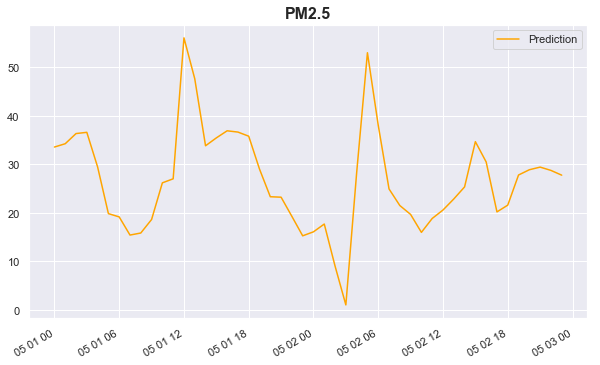

PM2.5        PM10          O3
test_id                                        
shunyi_aq#0   33.594391   80.669479   57.192005
shunyi_aq#1   34.277699   81.510017   79.923447
shunyi_aq#2   36.372551   82.229134  111.998718
shunyi_aq#3   36.626717   86.930435  119.942276
shunyi_aq#4   29.486950   86.930435  113.404861
shunyi_aq#5   19.863331   86.930435  110.243996
shunyi_aq#6   19.184711   82.229134  110.382126
shunyi_aq#7   15.442987   82.229134  111.193832
shunyi_aq#8   15.864204   82.229134  102.598770
shunyi_aq#9   18.647255   87.018181   94.543350
shunyi_aq#10  26.211674   86.561722   76.386490
shunyi_aq#11  27.041746   89.112335   76.656387
shunyi_aq#12  56.108925  135.887299   74.015244
shunyi_aq#13  47.679966  116.170563   74.671356
shunyi_aq#14  33.853664   82.347847   69.051598
shunyi_aq#15  35.480122   84.742493   63.252678
shunyi_aq#16  36.942127   68.300209   54.329857
shunyi_aq#17  36.679890   69.156479   34.870350
shunyi_aq#18  35.829639   62.240730   24.282583
shunyi_aq#19  29.044954   63.770107   30.321609
shunyi_aq#20  23.345398   61.592361   37.034206
shunyi_aq#21  23.251556   62.685925   37.694153
shunyi_aq#22  19.296696   62.369762   36.558678
shunyi_aq#23  15.285226   65.569382   43.378925
shunyi_aq#24  16.109463   65.399185   50.139587
shunyi_aq#25  17.714270   65.120667   60.323521
shunyi_aq#26   9.046506   64.401550   75.933823
shunyi_aq#27   1.037436   65.341156   96.119415
shunyi_aq#28  28.259695  170.857269  107.446930
shunyi_aq#29  53.040966  237.352188  110.461838
shunyi_aq#30  38.096451  136.692200  114.983871
shunyi_aq#31  24.956257   71.397797  116.498497
shunyi_aq#32  21.532873   82.644936  117.499657
shunyi_aq#33  19.697680   82.644936  117.330376
shunyi_aq#34  15.997024   82.644936  115.037827
shunyi_aq#35  18.862900   81.692108   95.950508
shunyi_aq#36  20.604959   72.970100   80.628242
shunyi_aq#37  22.882641   72.183823   62.266335
shunyi_aq#38  25.370930   70.262886   63.835979
shunyi_aq#39  34.705952   79.832848   69.043663
shunyi_aq#40  30.518286   84.193001   58.209465
shunyi_aq#41  20.217375   84.486946   39.912659
shunyi_aq#42  21.612755   84.486946   30.329296
shunyi_aq#43  27.825315   83.931793   21.943039
shunyi_aq#44  28.911880   71.605576   14.270334
shunyi_aq#45  29.455772   69.472893   13.594148
shunyi_aq#46  28.776516   66.118309   18.010529
shunyi_aq#47  27.792192   66.118309   24.030128

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 73.34761905670166 seconds.


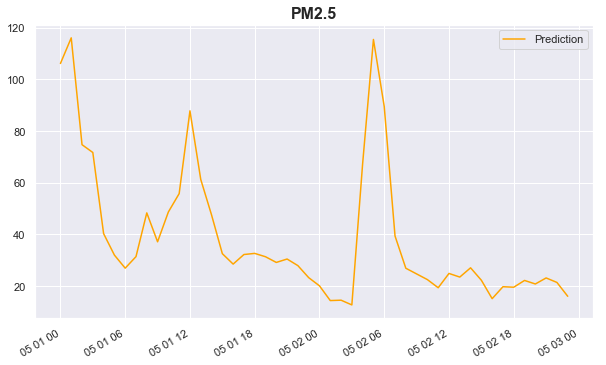

PM2.5        PM10          O3
test_id                                          
gucheng_aq#0   106.124268  735.247131   79.739487
gucheng_aq#1   116.031273  546.377502   97.365540
gucheng_aq#2    74.722412  150.680283   95.726456
gucheng_aq#3    71.697861   96.078255   98.815674
gucheng_aq#4    40.327202   97.196777  104.729027
gucheng_aq#5    32.027676   91.708771  108.329987
gucheng_aq#6    26.969812   88.606667  112.521370
gucheng_aq#7    31.437523   91.205116  107.702393
gucheng_aq#8    48.345078  128.682114   95.875862
gucheng_aq#9    37.170059  130.632172   84.060913
gucheng_aq#10   48.703346  127.899117   80.553497
gucheng_aq#11   55.796833  181.737488   79.501900
gucheng_aq#12   87.810921  185.051910   64.422897
gucheng_aq#13   61.283371  110.218811   37.660122
gucheng_aq#14   47.570637   85.749092   26.674696
gucheng_aq#15   32.581215   77.398567   17.700911
gucheng_aq#16   28.546568   78.952126   15.166440
gucheng_aq#17   32.247299   68.912186   13.586547
gucheng_aq#18   32.683846   84.771873   18.042006
gucheng_aq#19   31.388128   78.691246   20.029428
gucheng_aq#20   29.189899   67.158516   20.486614
gucheng_aq#21   30.505188   65.387115   23.129452
gucheng_aq#22   27.953905   79.905426   26.133806
gucheng_aq#23   23.308880   84.646057   31.693850
gucheng_aq#24   20.140018   68.161247   52.289303
gucheng_aq#25   14.442333   81.885078   70.564629
gucheng_aq#26   14.588999   67.920792   89.704399
gucheng_aq#27   12.761429   85.437912  101.012642
gucheng_aq#28   67.423546  245.518768  102.894653
gucheng_aq#29  115.411201  352.223328  101.215401
gucheng_aq#30   89.467018  176.522064   97.251923
gucheng_aq#31   39.413090   84.505547   94.460312
gucheng_aq#32   26.949099   85.166428  101.306129
gucheng_aq#33   24.747196   88.556221  102.344276
gucheng_aq#34   22.546831   87.540771  100.842041
gucheng_aq#35   19.402567   87.680115   92.026299
gucheng_aq#36   24.929310   88.932022   86.990395
gucheng_aq#37   23.527809   82.692352   83.273582
gucheng_aq#38   27.108587   71.293076   79.418404
gucheng_aq#39   22.296238   79.584290   76.536407
gucheng_aq#40   15.178757   78.481544   75.945656
gucheng_aq#41   19.796881   63.532772   73.616066
gucheng_aq#42   19.605675   75.065506   61.078659
gucheng_aq#43   22.223656   83.953773   46.856777
gucheng_aq#44   20.856123   84.060623   30.195997
gucheng_aq#45   23.189056   73.992264   34.179058
gucheng_aq#46   21.456583   68.009109   23.443214
gucheng_aq#47   16.104212   63.417782   36.023232

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 71.96468210220337 seconds.


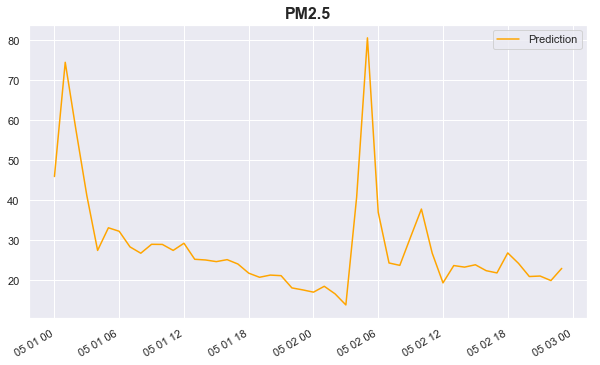

PM2.5        PM10          O3
test_id                                         
huairou_aq#0   45.922344  212.583847   61.727009
huairou_aq#1   74.532387  213.435898   82.595139
huairou_aq#2   57.488255  144.165375   95.093773
huairou_aq#3   41.173656   65.991661  105.798820
huairou_aq#4   27.416187   65.991661  105.908371
huairou_aq#5   33.084805   65.991661  110.803413
huairou_aq#6   32.212334   67.419518  108.712921
huairou_aq#7   28.300093   67.419518  110.080345
huairou_aq#8   26.715651   65.432640  107.502495
huairou_aq#9   28.946611   63.011513   93.166679
huairou_aq#10  28.916534   62.959030   93.000366
huairou_aq#11  27.419092   71.368469   92.291878
huairou_aq#12  29.212809   69.706757   90.191788
huairou_aq#13  25.196844   65.763069   84.982918
huairou_aq#14  25.021160   62.802025   71.556824
huairou_aq#15  24.610994   60.535854   63.891861
huairou_aq#16  25.105911   49.201435   67.629021
huairou_aq#17  24.010014   45.381905   56.842842
huairou_aq#18  21.723770   46.454697   51.305134
huairou_aq#19  20.691305   48.734974   44.968094
huairou_aq#20  21.236538   47.541325   37.484856
huairou_aq#21  21.092007   47.223656   33.271004
huairou_aq#22  18.027739   47.223656   31.371447
huairou_aq#23  17.533760   47.839535   32.569233
huairou_aq#24  16.963137   55.336578   42.666561
huairou_aq#25  18.429939   56.358852   68.599823
huairou_aq#26  16.540134   60.611813   85.853172
huairou_aq#27  13.767407   65.991661   97.033302
huairou_aq#28  40.738850  223.500626  100.023834
huairou_aq#29  80.656662  518.265930  106.419159
huairou_aq#30  36.963596  312.804626  101.183708
huairou_aq#31  24.269793   62.643951  108.567101
huairou_aq#32  23.674103   61.583656  103.620987
huairou_aq#33  30.781181   61.583656   90.876442
huairou_aq#34  37.776245   63.011513   92.440941
huairou_aq#35  26.739965   61.642029   91.953400
huairou_aq#36  19.288874   61.219929   90.634766
huairou_aq#37  23.625006   59.151821   87.195389
huairou_aq#38  23.233345   59.093449   93.779602
huairou_aq#39  23.821257   60.925289   95.467140
huairou_aq#40  22.344803   62.640827   90.462708
huairou_aq#41  21.778629   62.618690   81.416855
huairou_aq#42  26.791311   59.751812   66.482346
huairou_aq#43  24.161383   58.507469   46.392620
huairou_aq#44  20.879967   58.507469   57.163059
huairou_aq#45  20.999199   58.507469   61.762680
huairou_aq#46  19.868212   60.081532   57.252705
huairou_aq#47  22.912428   57.253395   53.800076

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 81.44472694396973 seconds.


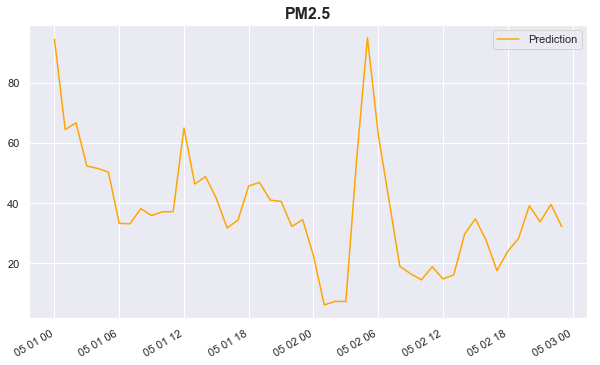

PM2.5        PM10          O3
test_id                                                
fengtaihuayuan_aq#0   94.352196  242.537155   61.182613
fengtaihuayuan_aq#1   64.396523  289.740417   79.916420
fengtaihuayuan_aq#2   66.611488  105.661873   89.072083
fengtaihuayuan_aq#3   52.294567  104.493942   93.967865
fengtaihuayuan_aq#4   51.479469   97.315857  103.221840
fengtaihuayuan_aq#5   50.257736   92.383774  109.570511
fengtaihuayuan_aq#6   33.235683   93.005005  109.902809
fengtaihuayuan_aq#7   33.110409  103.047394  107.920731
fengtaihuayuan_aq#8   38.125710  107.993546   94.310730
fengtaihuayuan_aq#9   35.824310  108.614769   88.416924
fengtaihuayuan_aq#10  37.081432  108.614769   81.557625
fengtaihuayuan_aq#11  37.127617  108.614769   63.727520
fengtaihuayuan_aq#12  64.908447  142.584656   44.549412
fengtaihuayuan_aq#13  46.317028  119.787636   37.685703
fengtaihuayuan_aq#14  48.758816  101.922707   32.202049
fengtaihuayuan_aq#15  41.501869  100.890350   21.229362
fengtaihuayuan_aq#16  31.720415   96.337662   15.623888
fengtaihuayuan_aq#17  34.310822   88.205421   17.552412
fengtaihuayuan_aq#18  45.671021   98.624123   17.141321
fengtaihuayuan_aq#19  46.804070   93.279602   13.709565
fengtaihuayuan_aq#20  40.977390   94.169708   10.641057
fengtaihuayuan_aq#21  40.509853   88.899712   10.042122
fengtaihuayuan_aq#22  32.232048   99.132713    9.579279
fengtaihuayuan_aq#23  34.462418  100.426323    8.925335
fengtaihuayuan_aq#24  22.455814   94.283958   28.810917
fengtaihuayuan_aq#25   6.166866   86.944496   60.115204
fengtaihuayuan_aq#26   7.337412   81.030266   78.912109
fengtaihuayuan_aq#27   7.298642   88.618965   88.333603
fengtaihuayuan_aq#28  54.498997  262.568787   96.172981
fengtaihuayuan_aq#29  94.828682  352.182648  101.063316
fengtaihuayuan_aq#30  62.818638  172.183578   96.621506
fengtaihuayuan_aq#31  40.925159   85.661957   95.174995
fengtaihuayuan_aq#32  18.997498   85.661957   96.640190
fengtaihuayuan_aq#33  16.518579   92.166634   95.125908
fengtaihuayuan_aq#34  14.473049   93.334564   93.481659
fengtaihuayuan_aq#35  18.821714   93.334564   75.417900
fengtaihuayuan_aq#36  14.802422   93.334564   78.650177
fengtaihuayuan_aq#37  16.140755   92.313644   72.018723
fengtaihuayuan_aq#38  29.650589   92.147873   64.527618
fengtaihuayuan_aq#39  34.760494   86.829880   65.728981
fengtaihuayuan_aq#40  27.597353   87.761467   61.070358
fengtaihuayuan_aq#41  17.544838   91.479164   54.213932
fengtaihuayuan_aq#42  23.935442  105.514130   34.186211
fengtaihuayuan_aq#43  28.252737  108.128609   16.599970
fengtaihuayuan_aq#44  39.090359  102.331848   17.835283
fengtaihuayuan_aq#45  33.705154  101.145164   18.063528
fengtaihuayuan_aq#46  39.559429   99.239632   14.672535
fengtaihuayuan_aq#47  32.174431   96.907959   11.026110

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 69.59407687187195 seconds.


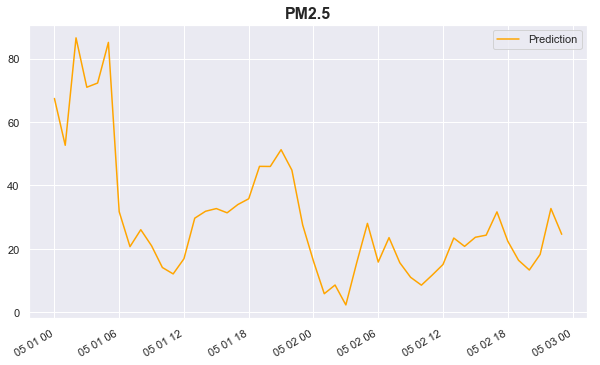

PM2.5        PM10          O3
test_id                                         
qianmen_aq#0   67.432030  108.361603   54.915646
qianmen_aq#1   52.667431  100.757271   64.057632
qianmen_aq#2   86.559128  130.186157   72.668419
qianmen_aq#3   70.978203  129.028152   78.329941
qianmen_aq#4   72.309700  136.014130   80.296638
qianmen_aq#5   85.121529  135.725266   86.572968
qianmen_aq#6   31.707155  103.332108   88.354042
qianmen_aq#7   20.687536   99.271759   90.524361
qianmen_aq#8   26.039427  107.927353   83.057785
qianmen_aq#9   20.954006   96.965607   64.395233
qianmen_aq#10  14.109259   99.047012   44.596119
qianmen_aq#11  12.085814  112.287994   31.995680
qianmen_aq#12  16.872784  118.463593   34.551983
qianmen_aq#13  29.671980  116.039543   32.315998
qianmen_aq#14  31.851479  121.016960   26.246645
qianmen_aq#15  32.701607  119.721947   17.425941
qianmen_aq#16  31.364315  106.195564   13.127620
qianmen_aq#17  33.983803  107.435509   13.250517
qianmen_aq#18  35.794479   99.565071   15.684923
qianmen_aq#19  46.018028   88.695877   21.127037
qianmen_aq#20  45.986843   87.612823   23.963589
qianmen_aq#21  51.279488   80.697762   29.538052
qianmen_aq#22  44.826389   86.195061   44.516426
qianmen_aq#23  27.527411   79.875534   51.046497
qianmen_aq#24  16.108644   84.897987   61.787804
qianmen_aq#25   5.839280   83.811127   69.885590
qianmen_aq#26   8.581041   83.312599   77.373268
qianmen_aq#27   2.306847   72.849731   84.096130
qianmen_aq#28  15.545421   57.307518   89.220695
qianmen_aq#29  28.028742   69.343872   90.188011
qianmen_aq#30  15.821331   72.381584   92.195511
qianmen_aq#31  23.531195   79.801865   89.613121
qianmen_aq#32  15.616426   75.613838   96.178230
qianmen_aq#33  11.017572   87.599808  107.088837
qianmen_aq#34   8.536264   87.599808   94.098274
qianmen_aq#35  11.710174   91.905548   61.180439
qianmen_aq#36  15.056415   93.724319   48.252453
qianmen_aq#37  23.400652   87.875465   37.688663
qianmen_aq#38  20.777662   85.005028   32.413029
qianmen_aq#39  23.648205   86.406021   32.123947
qianmen_aq#40  24.312101   93.532883   30.281481
qianmen_aq#41  31.661785   99.351173   29.814388
qianmen_aq#42  22.440248  100.722610   23.813536
qianmen_aq#43  16.391190  101.812576   21.218273
qianmen_aq#44  13.316129   99.277451   18.167006
qianmen_aq#45  18.234808   90.287018   22.590536
qianmen_aq#46  32.714485   76.935417   31.050915
qianmen_aq#47  24.586393   70.551025   42.406040

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 46.70580196380615 seconds.


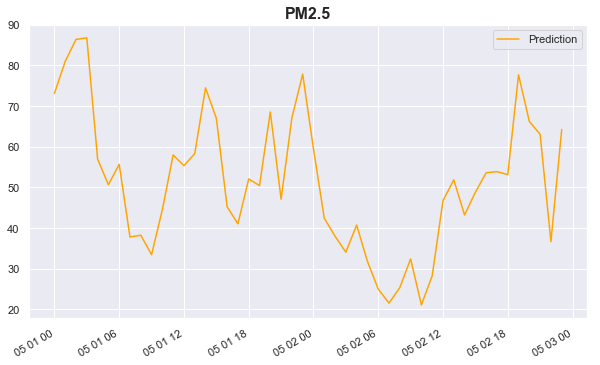

PM2.5        PM10          O3
test_id                                         
liulihe_aq#0   73.080414  157.630493   38.723145
liulihe_aq#1   80.927391  158.319168   62.047722
liulihe_aq#2   86.330147  164.462387   75.112091
liulihe_aq#3   86.705505  181.447372   93.810165
liulihe_aq#4   56.944630  166.055511  106.378242
liulihe_aq#5   50.644825  177.366745  111.778503
liulihe_aq#6   55.641571  178.515625  114.127319
liulihe_aq#7   37.789196  169.730240  115.699219
liulihe_aq#8   38.239944  153.826996  111.165184
liulihe_aq#9   33.454456  156.572357   87.908531
liulihe_aq#10  44.530312  152.006088   55.522800
liulihe_aq#11  57.948639  152.146866   33.286671
liulihe_aq#12  55.308243  163.539902   35.568459
liulihe_aq#13  58.267612  155.749176   37.803726
liulihe_aq#14  74.427742  153.148331   32.250019
liulihe_aq#15  66.947739  161.756516   31.355804
liulihe_aq#16  45.218914  158.717361   24.769714
liulihe_aq#17  41.035160  161.756516   15.815246
liulihe_aq#18  52.053394  162.649887   16.258507
liulihe_aq#19  50.426708  152.853485   16.829464
liulihe_aq#20  68.511551  143.823669   20.970570
liulihe_aq#21  47.090034  142.519272   21.905716
liulihe_aq#22  67.058640  143.037537   24.338717
liulihe_aq#23  77.810860  161.360077   31.036192
liulihe_aq#24  59.432804  140.146118   50.341167
liulihe_aq#25  42.425697  133.172165   66.657227
liulihe_aq#26  37.975483  117.054520   79.358101
liulihe_aq#27  34.063156  117.603180   85.513092
liulihe_aq#28  40.727486  122.488045   93.058266
liulihe_aq#29  31.813234  122.471321  112.313919
liulihe_aq#30  25.008169  122.294342  118.356987
liulihe_aq#31  21.556496  123.804054  118.615715
liulihe_aq#32  25.359161  138.051773  120.685501
liulihe_aq#33  32.416885  140.251068  119.795341
liulihe_aq#34  21.117657  149.081223  108.968033
liulihe_aq#35  28.277105  152.363251   96.672745
liulihe_aq#36  46.725082  153.216156   75.173950
liulihe_aq#37  51.829544  153.019699   61.982300
liulihe_aq#38  43.211506  151.676193   44.287281
liulihe_aq#39  48.764481  149.764618   36.872162
liulihe_aq#40  53.574753  149.907990   27.880615
liulihe_aq#41  53.851833  141.019714   19.448771
liulihe_aq#42  53.108395  147.239380   15.897042
liulihe_aq#43  77.629410  147.731293   14.041093
liulihe_aq#44  66.179199  147.731293   14.689662
liulihe_aq#45  63.016644  152.318726   18.625483
liulihe_aq#46  36.659126  161.315247   22.420658
liulihe_aq#47  64.190872  151.231262   32.036987

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 58.18219208717346 seconds.


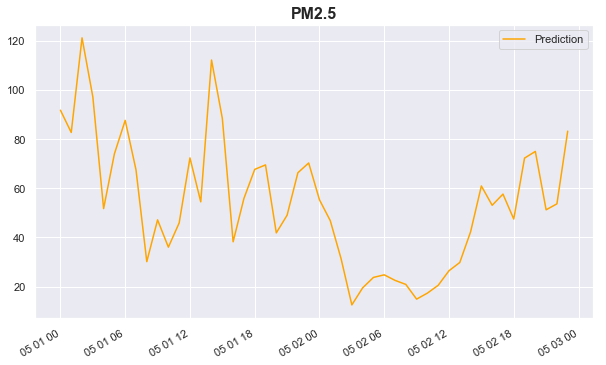

PM2.5        PM10          O3
test_id                                       
yufa_aq#0    91.704247  104.502174   39.163231
yufa_aq#1    82.660416  109.222878   63.899689
yufa_aq#2   121.101311  112.685997   75.901550
yufa_aq#3    97.171608  112.685997   88.676949
yufa_aq#4    51.725842  119.054482   96.876976
yufa_aq#5    73.977188  116.773987  100.345245
yufa_aq#6    87.571770  121.694389   99.931747
yufa_aq#7    67.495270  111.959328   98.169098
yufa_aq#8    30.154751   99.487816   92.546310
yufa_aq#9    47.146515   99.049889   86.590469
yufa_aq#10   36.048298   99.159546   56.527744
yufa_aq#11   45.887119   98.024033   40.459503
yufa_aq#12   72.322838  100.113846   42.707684
yufa_aq#13   54.464687  100.113846   41.934349
yufa_aq#14  112.083725  100.113846   40.677490
yufa_aq#15   88.370819   99.675911   32.853958
yufa_aq#16   38.236881   99.675911   26.924963
yufa_aq#17   55.832333   99.675911   20.453310
yufa_aq#18   67.650612   99.675911   13.373486
yufa_aq#19   69.481720   99.675911   13.895578
yufa_aq#20   41.853397   99.675911   14.614567
yufa_aq#21   49.029938   99.675911   12.904232
yufa_aq#22   66.289597  112.530388   21.427916
yufa_aq#23   70.260277  192.872299   27.493532
yufa_aq#24   55.294102  194.066620   46.353085
yufa_aq#25   46.826900  118.284981   62.581730
yufa_aq#26   31.395332  107.884277   91.254097
yufa_aq#27   12.584500  105.765556   94.922722
yufa_aq#28   19.509809  112.719460   99.693054
yufa_aq#29   23.755817  102.458672  108.493477
yufa_aq#30   24.811317  102.676567  117.023071
yufa_aq#31   22.558235  102.676567  121.075882
yufa_aq#32   20.915293  100.178177  122.206429
yufa_aq#33   14.934813  102.458672  119.722458
yufa_aq#34   17.377041  103.679047  108.298317
yufa_aq#35   20.551544   99.533058   90.643272
yufa_aq#36   26.465609   99.533058   82.538010
yufa_aq#37   29.829226   99.049889   71.267967
yufa_aq#38   42.261044   99.049889   59.610466
yufa_aq#39   60.916355  107.424927   45.962231
yufa_aq#40   53.062252  112.084778   39.202213
yufa_aq#41   57.612999  117.167664   27.993263
yufa_aq#42   47.483238  118.142395   20.087891
yufa_aq#43   72.233765  117.525200   14.723911
yufa_aq#44   74.952065  118.142395   13.617236
yufa_aq#45   51.230343  117.525200   11.930364
yufa_aq#46   53.654621  117.087265   16.631428
yufa_aq#47   83.203270  127.582817   30.922249

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 71.37665510177612 seconds.


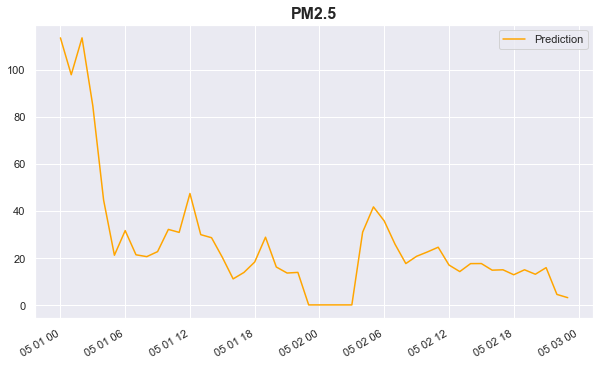

PM2.5        PM10          O3
test_id                                          
yungang_aq#0   113.445175  186.532318   59.710426
yungang_aq#1    97.784103  208.871307   91.536446
yungang_aq#2   113.450104  234.518311  101.547363
yungang_aq#3    84.574936  166.644470  112.201012
yungang_aq#4    44.531086   88.573250  111.103523
yungang_aq#5    21.107727   91.855331  110.405342
yungang_aq#6    31.573982   88.050385  121.490097
yungang_aq#7    21.291491   89.764000  124.403816
yungang_aq#8    20.506910   87.073975  112.871613
yungang_aq#9    22.636366   86.626617   83.378464
yungang_aq#10   32.079933   72.773125   78.530464
yungang_aq#11   30.810579   82.505440   71.422722
yungang_aq#12   47.332394  251.596344   61.430073
yungang_aq#13   29.847843  272.794891   47.847534
yungang_aq#14   28.546368   76.611137   42.593086
yungang_aq#15   20.217361   75.765480   33.085125
yungang_aq#16   11.052608   67.901932   27.734112
yungang_aq#17   13.785438   81.291435   30.424835
yungang_aq#18   18.225435   72.819450   24.894529
yungang_aq#19   28.762630   65.594025   25.547209
yungang_aq#20   16.106283   61.758430   25.649731
yungang_aq#21   13.544677   58.482719   27.424635
yungang_aq#22   13.813102   58.964233   28.612917
yungang_aq#23    0.000000   63.985096   32.946903
yungang_aq#24    0.000000   78.240204   51.423264
yungang_aq#25    0.000000   89.221634   77.217239
yungang_aq#26    0.000000   83.860962   91.785355
yungang_aq#27    0.000000   78.483917  107.757812
yungang_aq#28   30.908905  158.896942  115.952606
yungang_aq#29   41.644947  240.896805  117.474609
yungang_aq#30   35.674240  163.289307  120.089043
yungang_aq#31   25.790541   67.755699  134.570496
yungang_aq#32   17.563276   73.405777  115.585022
yungang_aq#33   20.659996   75.495705  112.625580
yungang_aq#34   22.500834   80.368683  106.423347
yungang_aq#35   24.507954   97.649086  100.647324
yungang_aq#36   16.942432   84.350571   95.777954
yungang_aq#37   14.159605   84.762505   93.997719
yungang_aq#38   17.546124   79.925079   90.877625
yungang_aq#39   17.568747   71.949707   89.584000
yungang_aq#40   14.761895   73.500778   73.088654
yungang_aq#41   14.921509   70.279861   68.886208
yungang_aq#42   12.813258   71.195229   60.006226
yungang_aq#43   14.923175   80.345169   47.991051
yungang_aq#44   13.024659   73.701614   39.299664
yungang_aq#45   15.834804   70.279861   38.292908
yungang_aq#46    4.453808   70.761375   41.938412
yungang_aq#47    3.080102   70.761375   44.084122

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 62.748496770858765 seconds.


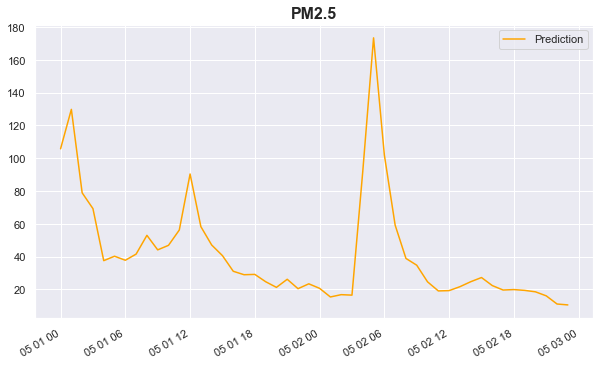

PM2.5        PM10          O3
test_id                                            
mentougou_aq#0   105.762238  272.082550   90.668716
mentougou_aq#1   129.821686  597.639771  103.450676
mentougou_aq#2    78.932411  206.094254   99.515900
mentougou_aq#3    69.295349  102.762535  109.403328
mentougou_aq#4    37.561390  102.995811  111.380959
mentougou_aq#5    40.267467  102.995811  118.526840
mentougou_aq#6    37.802242  100.594307  121.436951
mentougou_aq#7    41.559746  100.594307  115.803947
mentougou_aq#8    52.996620  117.526657   91.873184
mentougou_aq#9    44.140789  114.990105   86.807503
mentougou_aq#10   46.903034  119.023560   72.731255
mentougou_aq#11   56.235672  143.484085   76.606934
mentougou_aq#12   90.406807  169.212051   57.005863
mentougou_aq#13   58.304062   98.317574   37.204060
mentougou_aq#14   47.109528   75.708023   27.462303
mentougou_aq#15   40.615379   67.538437   25.454882
mentougou_aq#16   31.089552   64.912033   21.852119
mentougou_aq#17   28.980705   58.682617   27.209782
mentougou_aq#18   29.180912   58.130566   30.719891
mentougou_aq#19   24.726765   56.175541   33.762638
mentougou_aq#20   21.270432   54.947594   39.908314
mentougou_aq#21   26.204441   60.396854   47.502983
mentougou_aq#22   20.474440   64.687515   50.771252
mentougou_aq#23   23.432388   65.871674   57.228401
mentougou_aq#24   20.677120   72.958649   79.901367
mentougou_aq#25   15.413697   81.878105   97.518250
mentougou_aq#26   16.822403   78.422104  112.036034
mentougou_aq#27   16.532818   77.098000  113.890488
mentougou_aq#28   91.999901  264.883087  115.425087
mentougou_aq#29  173.431564  576.078613  119.714447
mentougou_aq#30  102.023941  287.722565  110.614624
mentougou_aq#31   59.222157   93.339821  106.786987
mentougou_aq#32   38.917046   82.693619  105.133133
mentougou_aq#33   34.783722   91.466003  108.082146
mentougou_aq#34   24.655174   83.775253  104.347595
mentougou_aq#35   19.100889   87.664680   93.999634
mentougou_aq#36   19.288988   84.404213   87.674522
mentougou_aq#37   21.677763   85.499504   86.944511
mentougou_aq#38   24.712791   81.574234   84.889297
mentougou_aq#39   27.268272   73.978500   81.896736
mentougou_aq#40   22.363049   77.397789   76.784569
mentougou_aq#41   19.653976   70.960983   79.673050
mentougou_aq#42   19.921417   72.720314   69.000145
mentougou_aq#43   19.432022   76.046432   45.738617
mentougou_aq#44   18.556374   75.813156   45.312931
mentougou_aq#45   16.096952   76.152115   47.489819
mentougou_aq#46   11.122905   72.521141   43.219902
mentougou_aq#47   10.570656   68.124969   52.708675

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 59.33038902282715 seconds.


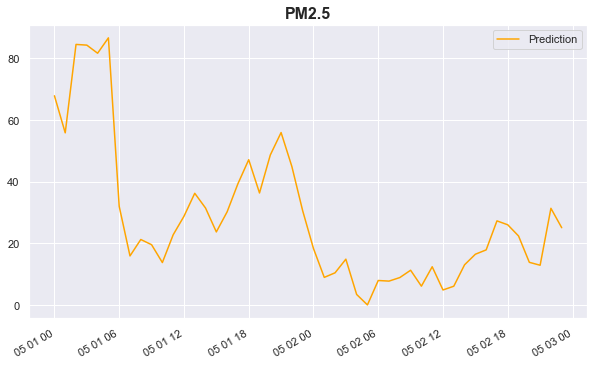

PM2.5        PM10          O3
test_id                                         
tiantan_aq#0   67.830605  123.141029   56.581242
tiantan_aq#1   55.828728  106.559052   67.403389
tiantan_aq#2   84.468620  101.457893   74.889893
tiantan_aq#3   84.240219  101.598572   79.832748
tiantan_aq#4   81.615189  107.328667   83.158264
tiantan_aq#5   86.594368  101.723793   95.748001
tiantan_aq#6   32.019753  101.723793   99.117523
tiantan_aq#7   15.959292   97.860909   94.603951
tiantan_aq#8   21.274857   97.860909   76.932785
tiantan_aq#9   19.593706   98.938362   61.229359
tiantan_aq#10  13.811042  102.027153   52.760654
tiantan_aq#11  22.794607  105.820831   47.031971
tiantan_aq#12  28.799295  104.335358   49.836514
tiantan_aq#13  36.247238  105.745705   42.026775
tiantan_aq#14  31.467112  106.970039   29.111494
tiantan_aq#15  23.733555  109.164963   19.569925
tiantan_aq#16  30.243399  101.979340   12.852221
tiantan_aq#17  39.345432  102.789726   13.930870
tiantan_aq#18  47.122871   96.175766   13.868128
tiantan_aq#19  36.349922   89.990395   16.557003
tiantan_aq#20  48.649933   87.636101   27.042933
tiantan_aq#21  55.923424   86.709534   33.250652
tiantan_aq#22  44.896431   91.796410   37.290173
tiantan_aq#23  30.585228   83.645721   51.369335
tiantan_aq#24  18.356985   89.824333   60.426914
tiantan_aq#25   9.007182   89.053551   67.537064
tiantan_aq#26  10.487392   85.522171   75.276550
tiantan_aq#27  14.904820   84.478111   83.903473
tiantan_aq#28   3.479109   73.585526   86.889923
tiantan_aq#29   0.089559   79.707977   96.876236
tiantan_aq#30   7.999348   85.061508   96.865257
tiantan_aq#31   7.799701   84.611198   97.995049
tiantan_aq#32   8.949801   98.290802  105.855080
tiantan_aq#33  11.319735   96.230408  107.072365
tiantan_aq#34   6.159998   96.230408   91.191269
tiantan_aq#35  12.448582  110.502998   62.316574
tiantan_aq#36   4.929230   97.709885   49.698971
tiantan_aq#37   6.144763   94.451653   37.338848
tiantan_aq#38  13.089457   88.081581   31.630819
tiantan_aq#39  16.507633   88.081581   27.805714
tiantan_aq#40  17.913744   88.426613   33.830723
tiantan_aq#41  27.308786  103.435837   28.775995
tiantan_aq#42  26.041023  106.882492   21.509598
tiantan_aq#43  22.420889  101.665215   17.826199
tiantan_aq#44  13.882959   94.662697   15.071102
tiantan_aq#45  12.941702   89.400024   18.471840
tiantan_aq#46  31.384367   85.900185   28.322538
tiantan_aq#47  25.099915   81.001656   35.655170

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 61.33911180496216 seconds.


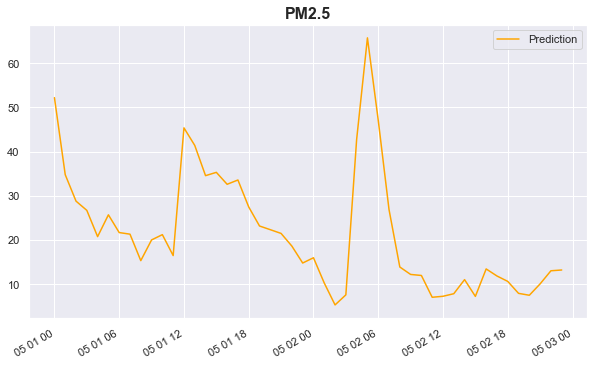

PM2.5        PM10          O3
test_id                                          
dingling_aq#0   52.223602  111.690384   87.529587
dingling_aq#1   34.761200   56.650009   93.134598
dingling_aq#2   28.763714   71.801994   98.224083
dingling_aq#3   26.674217   70.852203  101.614578
dingling_aq#4   20.721895   69.883041  111.221489
dingling_aq#5   25.666227   75.420868  104.399254
dingling_aq#6   21.641487   75.420868  101.660301
dingling_aq#7   21.277819   75.420868  106.089325
dingling_aq#8   15.277435   73.444160  108.144531
dingling_aq#9   19.972887   69.808243   99.732216
dingling_aq#10  21.168835   69.716843   89.964859
dingling_aq#11  16.424299   67.660423   80.166031
dingling_aq#12  45.377262  104.126221   74.750847
dingling_aq#13  41.398457   86.165474   76.955063
dingling_aq#14  34.542103   59.341049   74.371567
dingling_aq#15  35.291489   48.399719   65.844032
dingling_aq#16  32.586426   46.856003   55.939812
dingling_aq#17  33.557926   48.026711   46.581295
dingling_aq#18  27.450188   47.106194   43.515190
dingling_aq#19  23.131706   47.106194   48.741791
dingling_aq#20  22.294178   48.118469   55.383636
dingling_aq#21  21.445328   49.452873   60.035175
dingling_aq#22  18.568836   49.452873   60.578304
dingling_aq#23  14.736757   49.452873   69.108147
dingling_aq#24  15.932495   48.431850   76.642960
dingling_aq#25  10.198560   47.926205   86.313538
dingling_aq#26   5.240250   47.303185   93.328369
dingling_aq#27   7.519060   47.861584   99.705048
dingling_aq#28  42.767387  201.641083  108.133896
dingling_aq#29  65.780357  426.804993  109.053703
dingling_aq#30  47.120026  209.185074  107.907631
dingling_aq#31  26.846205   49.603630  105.077072
dingling_aq#32  13.834221   55.408878   99.480682
dingling_aq#33  12.149275   62.047081  110.591003
dingling_aq#34  11.913500   74.762947  101.839760
dingling_aq#35   6.971913   70.350479   99.974144
dingling_aq#36   7.196575   67.974968   90.472534
dingling_aq#37   7.778918   53.178501   81.188629
dingling_aq#38  10.969554   50.288597   76.209641
dingling_aq#39   7.173819   49.452873   74.748795
dingling_aq#40  13.395439   49.505627   68.339302
dingling_aq#41  11.797248   49.452873   66.719154
dingling_aq#42  10.571835   48.493351   61.926720
dingling_aq#43   7.859702   48.493351   57.404133
dingling_aq#44   7.429032   48.546101   59.506512
dingling_aq#45  10.012035   48.493351   59.166805
dingling_aq#46  12.979684   48.546101   61.143223
dingling_aq#47  13.156964   48.484604   68.135826

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 61.86039590835571 seconds.


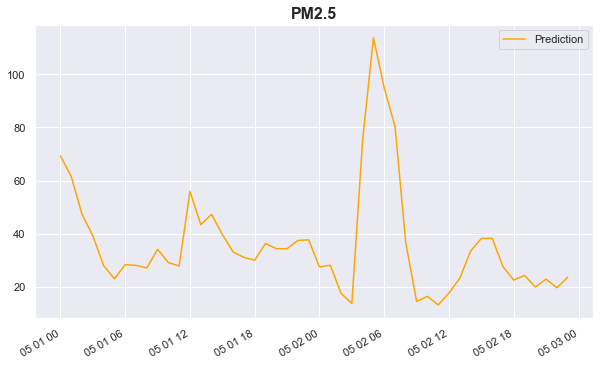

PM2.5        PM10          O3
test_id                                         
wanliu_aq#0    69.271515  179.653168   50.584591
wanliu_aq#1    61.514645  101.441917   70.977531
wanliu_aq#2    47.274883   99.972252   80.749794
wanliu_aq#3    39.178673   99.188736   88.733490
wanliu_aq#4    27.953873   90.106903  100.030785
wanliu_aq#5    22.983002   93.253021  109.467110
wanliu_aq#6    28.308029   95.618256  105.045586
wanliu_aq#7    28.023609  100.566826  104.019272
wanliu_aq#8    27.065256  102.680061   95.793564
wanliu_aq#9    34.112022  102.806160   82.007118
wanliu_aq#10   29.084280  102.403114   76.386658
wanliu_aq#11   27.827681   99.217155   61.452976
wanliu_aq#12   55.937191  238.559982   49.663975
wanliu_aq#13   43.363247  160.595367   34.111576
wanliu_aq#14   47.263851   96.702507   28.702351
wanliu_aq#15   39.675392   90.122902   25.065500
wanliu_aq#16   33.087601   87.512726   28.955605
wanliu_aq#17   31.027010   88.609558   31.281200
wanliu_aq#18   29.990587   82.071693   28.909195
wanliu_aq#19   36.283520   77.145386   25.570944
wanliu_aq#20   34.330036   76.118668   23.781807
wanliu_aq#21   34.318314   77.126549   20.717037
wanliu_aq#22   37.447239   80.113297   18.151285
wanliu_aq#23   37.646950   76.506187   26.548868
wanliu_aq#24   27.455225   76.719604   32.024754
wanliu_aq#25   28.089602   66.599785   56.576412
wanliu_aq#26   17.514841   83.330254   73.146637
wanliu_aq#27   13.663838   66.643784   86.334045
wanliu_aq#28   75.246025  191.952118   94.732262
wanliu_aq#29  113.746117  341.213287  104.407852
wanliu_aq#30   94.876755  202.674194  104.598557
wanliu_aq#31   80.375359   68.847969  100.811455
wanliu_aq#32   36.441589   72.443604  108.464363
wanliu_aq#33   14.437844   90.571793  116.672668
wanliu_aq#34   16.369030   90.432793  112.355957
wanliu_aq#35   13.146435   90.571793  101.483742
wanliu_aq#36   17.651003   90.475639   91.592575
wanliu_aq#37   23.190042   90.475639   82.690224
wanliu_aq#38   33.455269   71.309937   79.326340
wanliu_aq#39   38.176704   82.205589   68.102699
wanliu_aq#40   38.219688   79.937141   55.683868
wanliu_aq#41   27.562212   93.396019   49.990517
wanliu_aq#42   22.477497   91.026367   31.439735
wanliu_aq#43   24.278982   91.079575   17.484615
wanliu_aq#44   19.883707   92.136719   16.012577
wanliu_aq#45   22.859428   90.952049   22.009380
wanliu_aq#46   19.626373   78.508736   21.420788
wanliu_aq#47   23.589565   78.508736   20.049967

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 61.64988112449646 seconds.


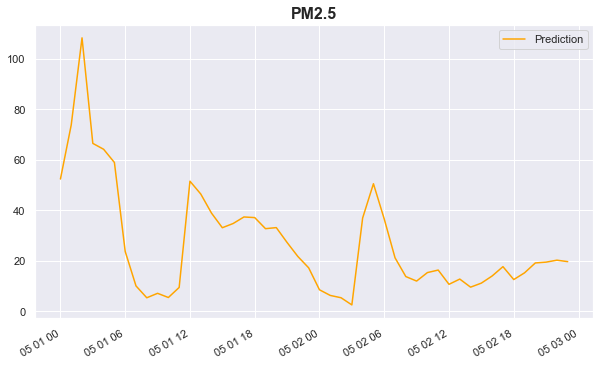

PM2.5        PM10          O3
test_id                                               
nongzhanguan_aq#0    52.293198  553.849182   48.125378
nongzhanguan_aq#1    73.731216  415.197235   75.148247
nongzhanguan_aq#2   108.227135  240.042007   93.327354
nongzhanguan_aq#3    66.417603  155.957916   98.898323
nongzhanguan_aq#4    64.087700   86.021210  101.805038
nongzhanguan_aq#5    58.856213   88.660583  115.839973
nongzhanguan_aq#6    23.603006   89.322060  118.449356
nongzhanguan_aq#7     9.947906   93.575226  110.966171
nongzhanguan_aq#8     5.250047   91.809654   86.303246
nongzhanguan_aq#9     7.012656   87.347084   70.510422
nongzhanguan_aq#10    5.356042   87.347084   67.102364
nongzhanguan_aq#11    9.341239   94.600067   61.744148
nongzhanguan_aq#12   51.436237  518.533447   68.821518
nongzhanguan_aq#13   46.363235  265.633057   53.057137
nongzhanguan_aq#14   38.768410   88.462296   36.427189
nongzhanguan_aq#15   33.001751   88.195999   28.405077
nongzhanguan_aq#16   34.671444   80.220993   29.884773
nongzhanguan_aq#17   37.261047   75.815659   29.018736
nongzhanguan_aq#18   37.016338   75.729980   30.629509
nongzhanguan_aq#19   32.624184   75.054604   37.458920
nongzhanguan_aq#20   33.047379   76.257019   37.133068
nongzhanguan_aq#21   27.151295   78.672096   30.208881
nongzhanguan_aq#22   21.591454   82.903900   24.491611
nongzhanguan_aq#23   17.103928   77.426880   23.658556
nongzhanguan_aq#24    8.413716   74.684036   34.907970
nongzhanguan_aq#25    6.175435   74.273239   64.820045
nongzhanguan_aq#26    5.257612   80.571121   80.868279
nongzhanguan_aq#27    2.419425   81.697052   96.059357
nongzhanguan_aq#28   36.862118  189.814377  107.956360
nongzhanguan_aq#29   50.427788  272.276764  110.798538
nongzhanguan_aq#30   36.468071  171.077866  112.137016
nongzhanguan_aq#31   21.094793   82.498726  104.621811
nongzhanguan_aq#32   13.652362   81.663307   95.456955
nongzhanguan_aq#33   11.864923   77.741539   99.814880
nongzhanguan_aq#34   15.228407   86.026772  104.903290
nongzhanguan_aq#35   16.229445   86.675880  102.242668
nongzhanguan_aq#36   10.579438   79.067413  100.494003
nongzhanguan_aq#37   12.655371   78.819374   83.901978
nongzhanguan_aq#38    9.452084   76.865234   79.513268
nongzhanguan_aq#39   11.055828   78.656090   78.186424
nongzhanguan_aq#40   13.890429   77.524071   73.880531
nongzhanguan_aq#41   17.580233   86.685600   63.908611
nongzhanguan_aq#42   12.466126   79.726242   48.530468
nongzhanguan_aq#43   15.128781   87.347084   32.407272
nongzhanguan_aq#44   19.051085   81.654243   22.169188
nongzhanguan_aq#45   19.367243   85.643562   17.692614
nongzhanguan_aq#46   20.144457   72.729897   29.291021
nongzhanguan_aq#47   19.562277   79.689262   37.868191

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 70.63031888008118 seconds.


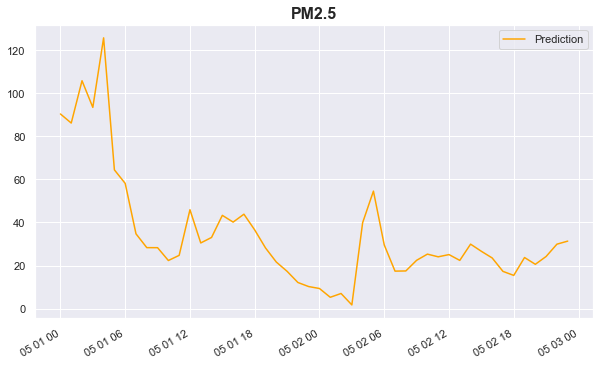

PM2.5        PM10          O3
test_id                                         
daxing_aq#0    90.313980  401.003540   46.948051
daxing_aq#1    86.101555  412.069885   79.336250
daxing_aq#2   105.740784  191.698410   89.708138
daxing_aq#3    93.372681  191.231750   95.555908
daxing_aq#4   125.634354  206.067795   99.789261
daxing_aq#5    64.368927  191.264862   96.132248
daxing_aq#6    58.102375  101.351868  105.674622
daxing_aq#7    34.702152   92.546188  108.539108
daxing_aq#8    28.290009   97.139313   89.347000
daxing_aq#9    28.269508   96.715805   68.244774
daxing_aq#10   22.314234   91.408127   66.921242
daxing_aq#11   24.711716   82.087364   62.630959
daxing_aq#12   45.878689  334.161530   53.231766
daxing_aq#13   30.465206  352.586212   52.850643
daxing_aq#14   33.013397   82.086922   48.644428
daxing_aq#15   43.270088  107.719566   31.757166
daxing_aq#16   40.142952  109.948463   33.618553
daxing_aq#17   43.806988   78.488701   41.068272
daxing_aq#18   36.501324   76.301483   39.113743
daxing_aq#19   28.151028   76.048271   37.695435
daxing_aq#20   21.605230   73.946426   25.306284
daxing_aq#21   17.302101   77.005623   17.792976
daxing_aq#22   12.119018   80.413307    9.183977
daxing_aq#23   10.227557   88.260971   15.942846
daxing_aq#24    9.327533   89.445747   35.591820
daxing_aq#25    5.254068   83.063271   64.951675
daxing_aq#26    7.016670   81.708725   86.590652
daxing_aq#27    1.712752   94.432808   94.566620
daxing_aq#28   39.889473  186.673141  101.353928
daxing_aq#29   54.509018  211.840897  102.241730
daxing_aq#30   29.560305  166.037827  107.216248
daxing_aq#31   17.388313   81.691948  102.768326
daxing_aq#32   17.469839  102.580475   96.321350
daxing_aq#33   22.406567   85.169327   96.887657
daxing_aq#34   25.280348   85.634888   89.532310
daxing_aq#35   24.030123   90.543083   88.071510
daxing_aq#36   25.067993   85.845306   85.344048
daxing_aq#37   22.370018   84.151367   81.144493
daxing_aq#38   29.908943   82.676132   70.550240
daxing_aq#39   26.586357   83.191650   64.736877
daxing_aq#40   23.507261   83.224022   53.755566
daxing_aq#41   17.273064   86.618111   49.930786
daxing_aq#42   15.406724   86.319809   46.196556
daxing_aq#43   23.702177   90.315742   31.834736
daxing_aq#44   20.560276   94.580330   22.286894
daxing_aq#45   24.188812   91.288765   10.679544
daxing_aq#46   29.898521   88.528084    7.996945
daxing_aq#47   31.316658   89.861343   14.279440

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 61.76276183128357 seconds.


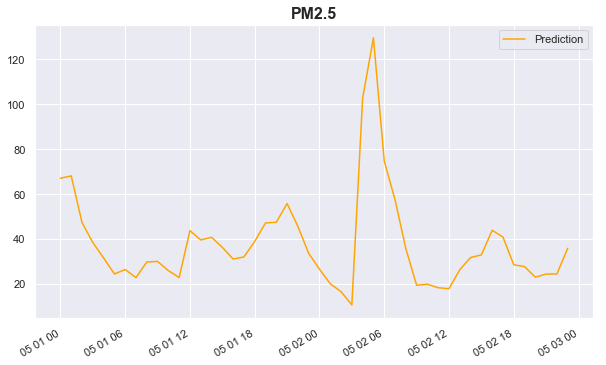

PM2.5        PM10          O3
test_id                                               
aotizhongxin_aq#0    66.951233  183.441315   52.188435
aotizhongxin_aq#1    68.016563   92.927101   73.876617
aotizhongxin_aq#2    47.203716   92.927101   88.637978
aotizhongxin_aq#3    38.330864   92.807289  100.832336
aotizhongxin_aq#4    31.428093   91.896523  104.537155
aotizhongxin_aq#5    24.318279   91.166496  108.930954
aotizhongxin_aq#6    26.285273   91.166496  109.485695
aotizhongxin_aq#7    22.657202   92.077255  110.112801
aotizhongxin_aq#8    29.627184   93.893013  104.865929
aotizhongxin_aq#9    29.901365   93.298401   87.939438
aotizhongxin_aq#10   25.791695   94.707130   74.604935
aotizhongxin_aq#11   22.712364   94.106430   62.826496
aotizhongxin_aq#12   43.611290  311.751312   56.720066
aotizhongxin_aq#13   39.460678  189.048157   39.497623
aotizhongxin_aq#14   40.652905   92.108192   34.193474
aotizhongxin_aq#15   36.166389   86.419342   36.367474
aotizhongxin_aq#16   30.961796   82.629555   27.406908
aotizhongxin_aq#17   31.873140   83.304565   29.819593
aotizhongxin_aq#18   38.791283   79.540291   29.365129
aotizhongxin_aq#19   47.031597   75.195892   31.021544
aotizhongxin_aq#20   47.339828   75.195892   26.048946
aotizhongxin_aq#21   55.674995   73.683327   25.725389
aotizhongxin_aq#22   45.502129   78.557808   26.013592
aotizhongxin_aq#23   33.483940   72.781372   33.081543
aotizhongxin_aq#24   26.461349   72.078331   41.208248
aotizhongxin_aq#25   19.937340   68.502808   63.527668
aotizhongxin_aq#26   16.410578   67.430420   79.771965
aotizhongxin_aq#27   10.514650   68.406937   99.887985
aotizhongxin_aq#28  102.671944  261.395325  106.199379
aotizhongxin_aq#29  129.518982  375.569336  104.862778
aotizhongxin_aq#30   74.669197  177.877136  102.300781
aotizhongxin_aq#31   57.395618   73.042046  102.230446
aotizhongxin_aq#32   35.684090   84.734337   99.769058
aotizhongxin_aq#33   19.277506   85.889648  110.089302
aotizhongxin_aq#34   19.715939   86.800415  104.940651
aotizhongxin_aq#35   18.177404   87.171707  101.502739
aotizhongxin_aq#36   17.731190   92.479424   91.252960
aotizhongxin_aq#37   26.196661   93.627876   82.677536
aotizhongxin_aq#38   31.638458   79.474518   74.840149
aotizhongxin_aq#39   32.791134   81.554512   67.498772
aotizhongxin_aq#40   43.761623   83.053932   58.110954
aotizhongxin_aq#41   40.750599   92.807289   50.565712
aotizhongxin_aq#42   28.399229   98.050919   42.441463
aotizhongxin_aq#43   27.587584   81.805473   31.858747
aotizhongxin_aq#44   22.866112   83.617279   23.015236
aotizhongxin_aq#45   24.271290   82.644188   23.864017
aotizhongxin_aq#46   24.307568   76.411919   26.843870
aotizhongxin_aq#47   35.748436   72.690620   26.066715

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 61.1223828792572 seconds.


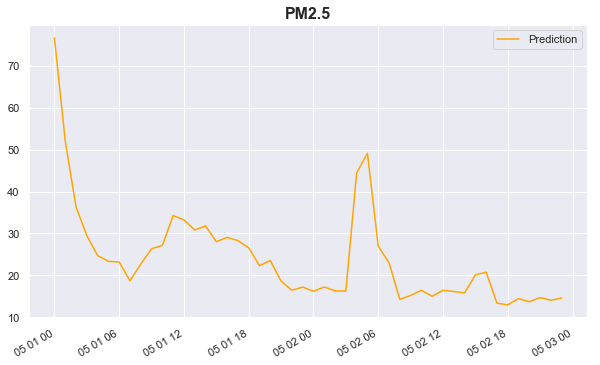

PM2.5        PM10          O3
test_id                                          
badaling_aq#0   76.586555  618.933838   58.355782
badaling_aq#1   52.065979  504.524567   78.534599
badaling_aq#2   36.330593   79.282509   75.829605
badaling_aq#3   29.504625   79.030693   80.274788
badaling_aq#4   24.743687   84.432610   81.177521
badaling_aq#5   23.370262   87.009026   88.987823
badaling_aq#6   23.203650   87.009026   86.630074
badaling_aq#7   18.717514   87.009026   89.464554
badaling_aq#8   22.724154   87.009026   77.644455
badaling_aq#9   26.371620   87.009026   73.990448
badaling_aq#10  27.172779   85.140427   69.516960
badaling_aq#11  34.266563   80.950348   64.898056
badaling_aq#12  33.235649   80.249756   58.306705
badaling_aq#13  30.833435   80.249756   44.154541
badaling_aq#14  31.780655   78.945297   23.621433
badaling_aq#15  28.056511   74.805183   17.429565
badaling_aq#16  29.066458   74.887466   14.180456
badaling_aq#17  28.305765   74.805183   16.496403
badaling_aq#18  26.594603   74.805183   19.216627
badaling_aq#19  22.350012   74.805183   23.086243
badaling_aq#20  23.581957   74.805183   24.542194
badaling_aq#21  18.643013   74.805183   20.523121
badaling_aq#22  16.483141   75.411980   20.629852
badaling_aq#23  17.231234   74.444351   29.267345
badaling_aq#24  16.240490   67.928398   28.871038
badaling_aq#25  17.258821   67.928398   41.019882
badaling_aq#26  16.351997   68.896034   71.521057
badaling_aq#27  16.284672   72.838203   94.462242
badaling_aq#28  44.432579  141.461426  100.375076
badaling_aq#29  49.075600  212.725876  102.356491
badaling_aq#30  26.976072  117.137489  108.490570
badaling_aq#31  23.048254   79.666382  103.290459
badaling_aq#32  14.309492   82.320686   99.715187
badaling_aq#33  15.238959   81.564461   96.490288
badaling_aq#34  16.468742   81.564461   87.818611
badaling_aq#35  15.048769   81.564461   76.451401
badaling_aq#36  16.480152   81.564461   51.489494
badaling_aq#37  16.185160   80.302650   29.812010
badaling_aq#38  15.855874   75.411980   21.336525
badaling_aq#39  20.120462   75.411980   35.971592
badaling_aq#40  20.786119   75.411980   32.327782
badaling_aq#41  13.419020   75.411980   27.390728
badaling_aq#42  12.993645   75.411980   24.671427
badaling_aq#43  14.499354   75.411980   19.828629
badaling_aq#44  13.736310   75.411980   16.417778
badaling_aq#45  14.723579   75.411980   16.848675
badaling_aq#46  14.113424   74.444351   20.102171
badaling_aq#47  14.610931   67.928398   30.225552

/Users/zhengdongjia/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


This took 50.09408688545227 seconds.


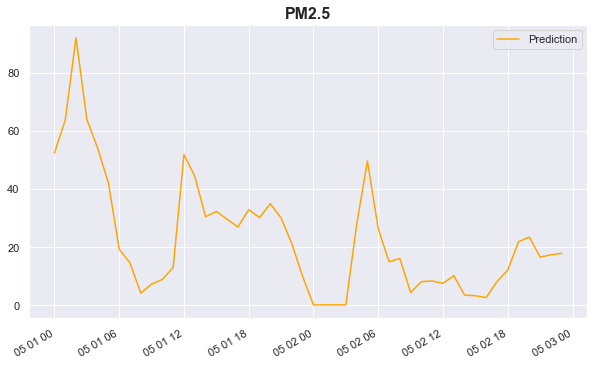

PM2.5        PM10          O3
test_id                                            
dongsihuan_aq#0   52.309853  483.156097   30.239973
dongsihuan_aq#1   63.603008  340.331970   52.458599
dongsihuan_aq#2   91.939468  259.397736   63.497669
dongsihuan_aq#3   63.920574  192.192642   66.862289
dongsihuan_aq#4   54.022541   87.982880   68.660233
dongsihuan_aq#5   42.013264  116.772995   74.512444
dongsihuan_aq#6   19.205070  106.414398   69.256081
dongsihuan_aq#7   14.423171  118.205505   75.224411
dongsihuan_aq#8    4.089238  116.072357   56.918407
dongsihuan_aq#9    7.151851  111.602310   43.348156
dongsihuan_aq#10   8.773449  105.578232   36.933445
dongsihuan_aq#11  12.893367  102.564812   40.778023
dongsihuan_aq#12  51.745594  460.167480   45.949100
dongsihuan_aq#13  44.317631  224.650696   28.228386
dongsihuan_aq#14  30.356577   96.525627   14.854288
dongsihuan_aq#15  32.155819  103.512276   15.649773
dongsihuan_aq#16  29.482565   94.312881   20.442953
dongsihuan_aq#17  26.839525   94.312881   18.676155
dongsihuan_aq#18  32.767452   92.262321   19.829245
dongsihuan_aq#19  30.052721   88.631882   25.486008
dongsihuan_aq#20  34.843227   86.434135   20.230566
dongsihuan_aq#21  29.916918   92.646866    9.213304
dongsihuan_aq#22  20.995953   93.950851    8.714478
dongsihuan_aq#23   9.734805   87.738113   15.241236
dongsihuan_aq#24   0.000000   87.738113   28.791216
dongsihuan_aq#25   0.000000   84.699432   38.173912
dongsihuan_aq#26   0.000000   78.076653   45.893318
dongsihuan_aq#27   0.000000   78.076653   55.351402
dongsihuan_aq#28  27.617344  152.659790   70.287407
dongsihuan_aq#29  49.505543  268.003937   74.646584
dongsihuan_aq#30  26.234426  148.542587   84.695480
dongsihuan_aq#31  14.838985   74.583298   83.963890
dongsihuan_aq#32  16.005030   71.454445   83.810448
dongsihuan_aq#33   4.278162   72.364006   97.226585
dongsihuan_aq#34   8.003875   73.670921  108.314651
dongsihuan_aq#35   8.230864   74.383446   97.925240
dongsihuan_aq#36   7.413143   79.689888   82.695915
dongsihuan_aq#37  10.067085   77.692108   70.846672
dongsihuan_aq#38   3.381965   77.722717   59.753269
dongsihuan_aq#39   3.158097   77.722717   55.430042
dongsihuan_aq#40   2.540352   78.766548   48.997944
dongsihuan_aq#41   8.008998   81.090302   31.230961
dongsihuan_aq#42  11.974394   83.798080   17.845787
dongsihuan_aq#43  21.745001  101.783546   11.906383
dongsihuan_aq#44  23.352558   93.264343    6.775996
dongsihuan_aq#45  16.472178  101.031509    9.710775
dongsihuan_aq#46  17.230928   90.930946   23.380379
dongsihuan_aq#47  17.769655   92.378792   21.809397

In [90]:
for key, value in airQ_data_dict.items():
    sub = xgb_final_prediction(airQ_data_dict[key], key)
    submission(sub, key)